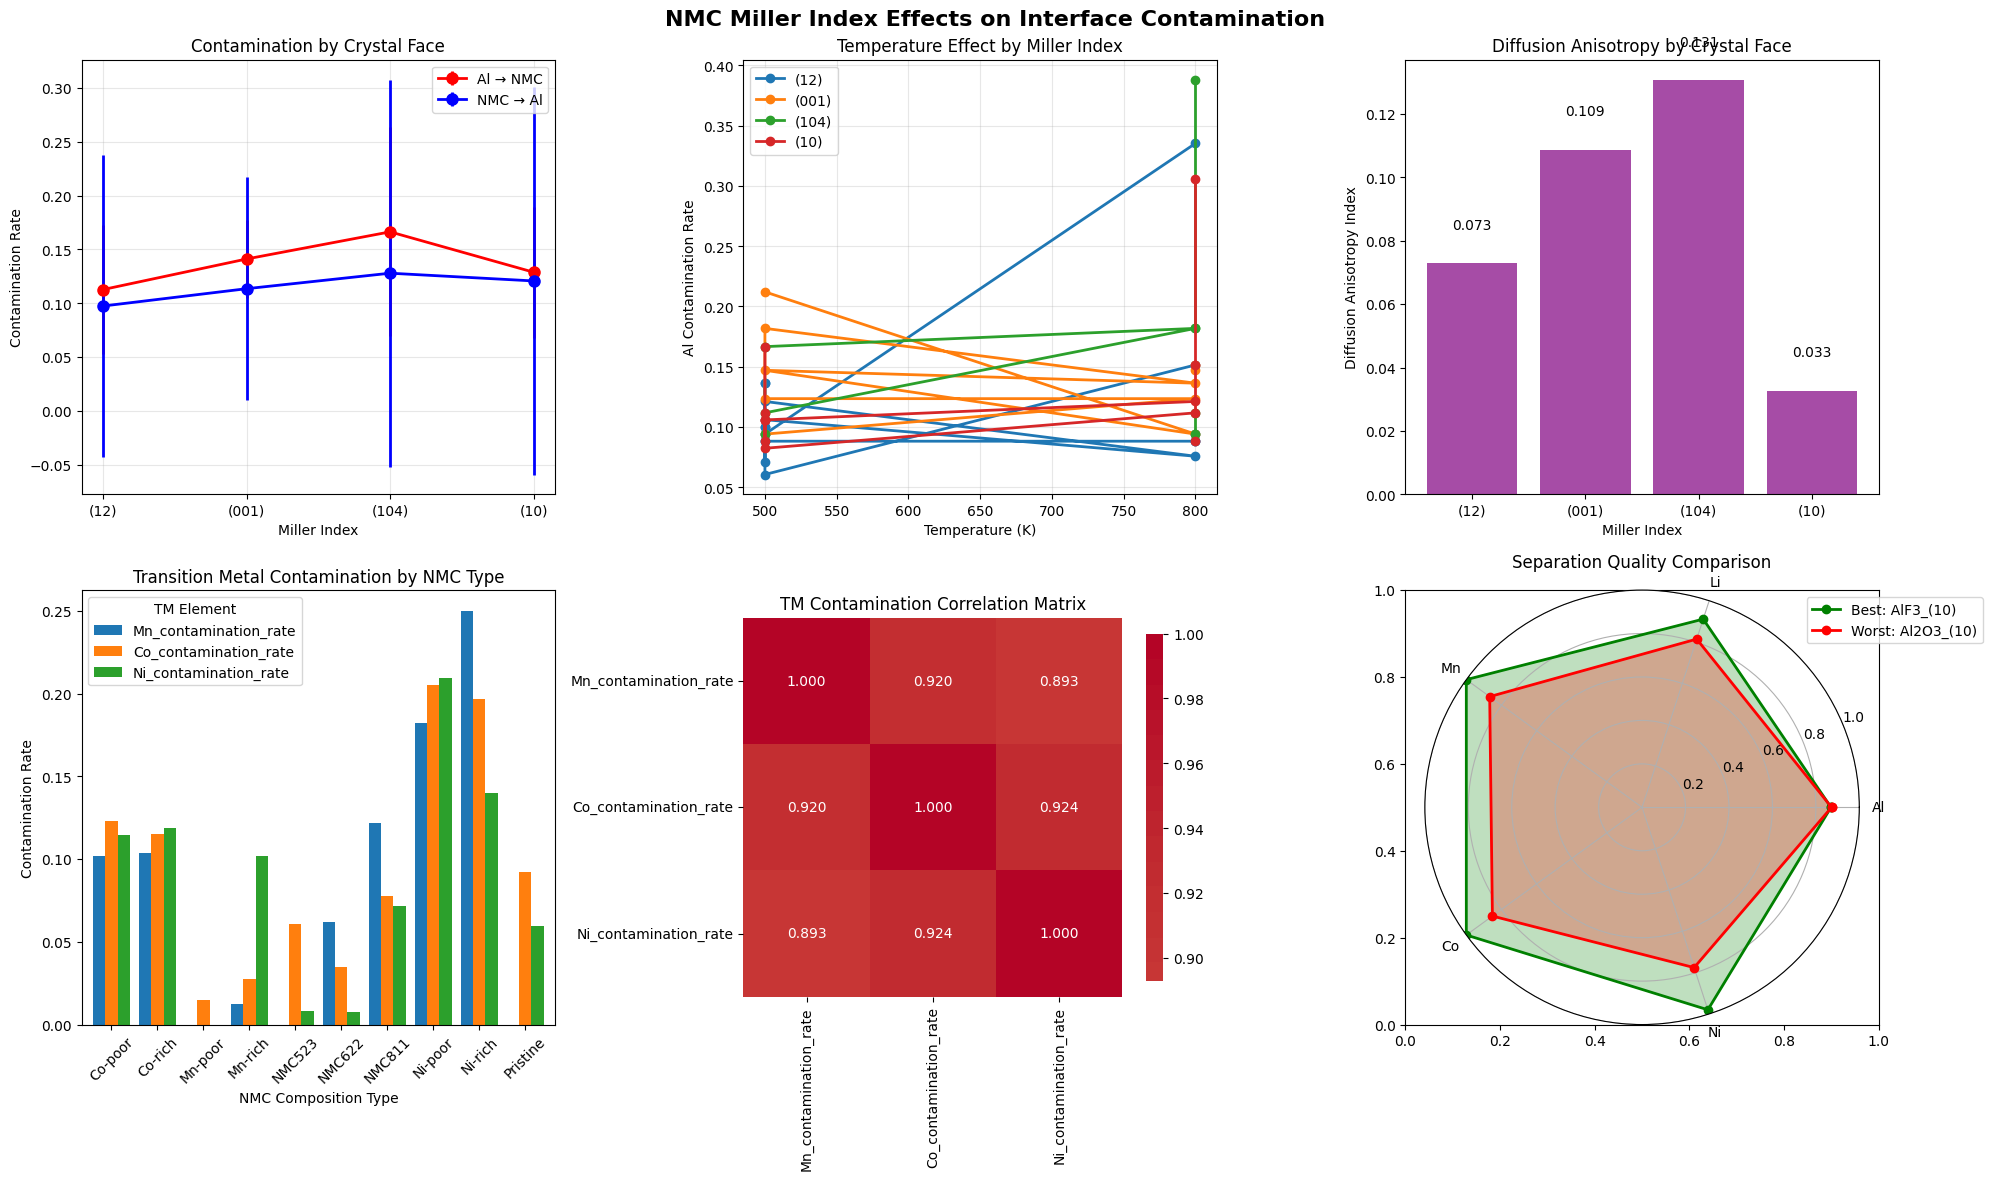

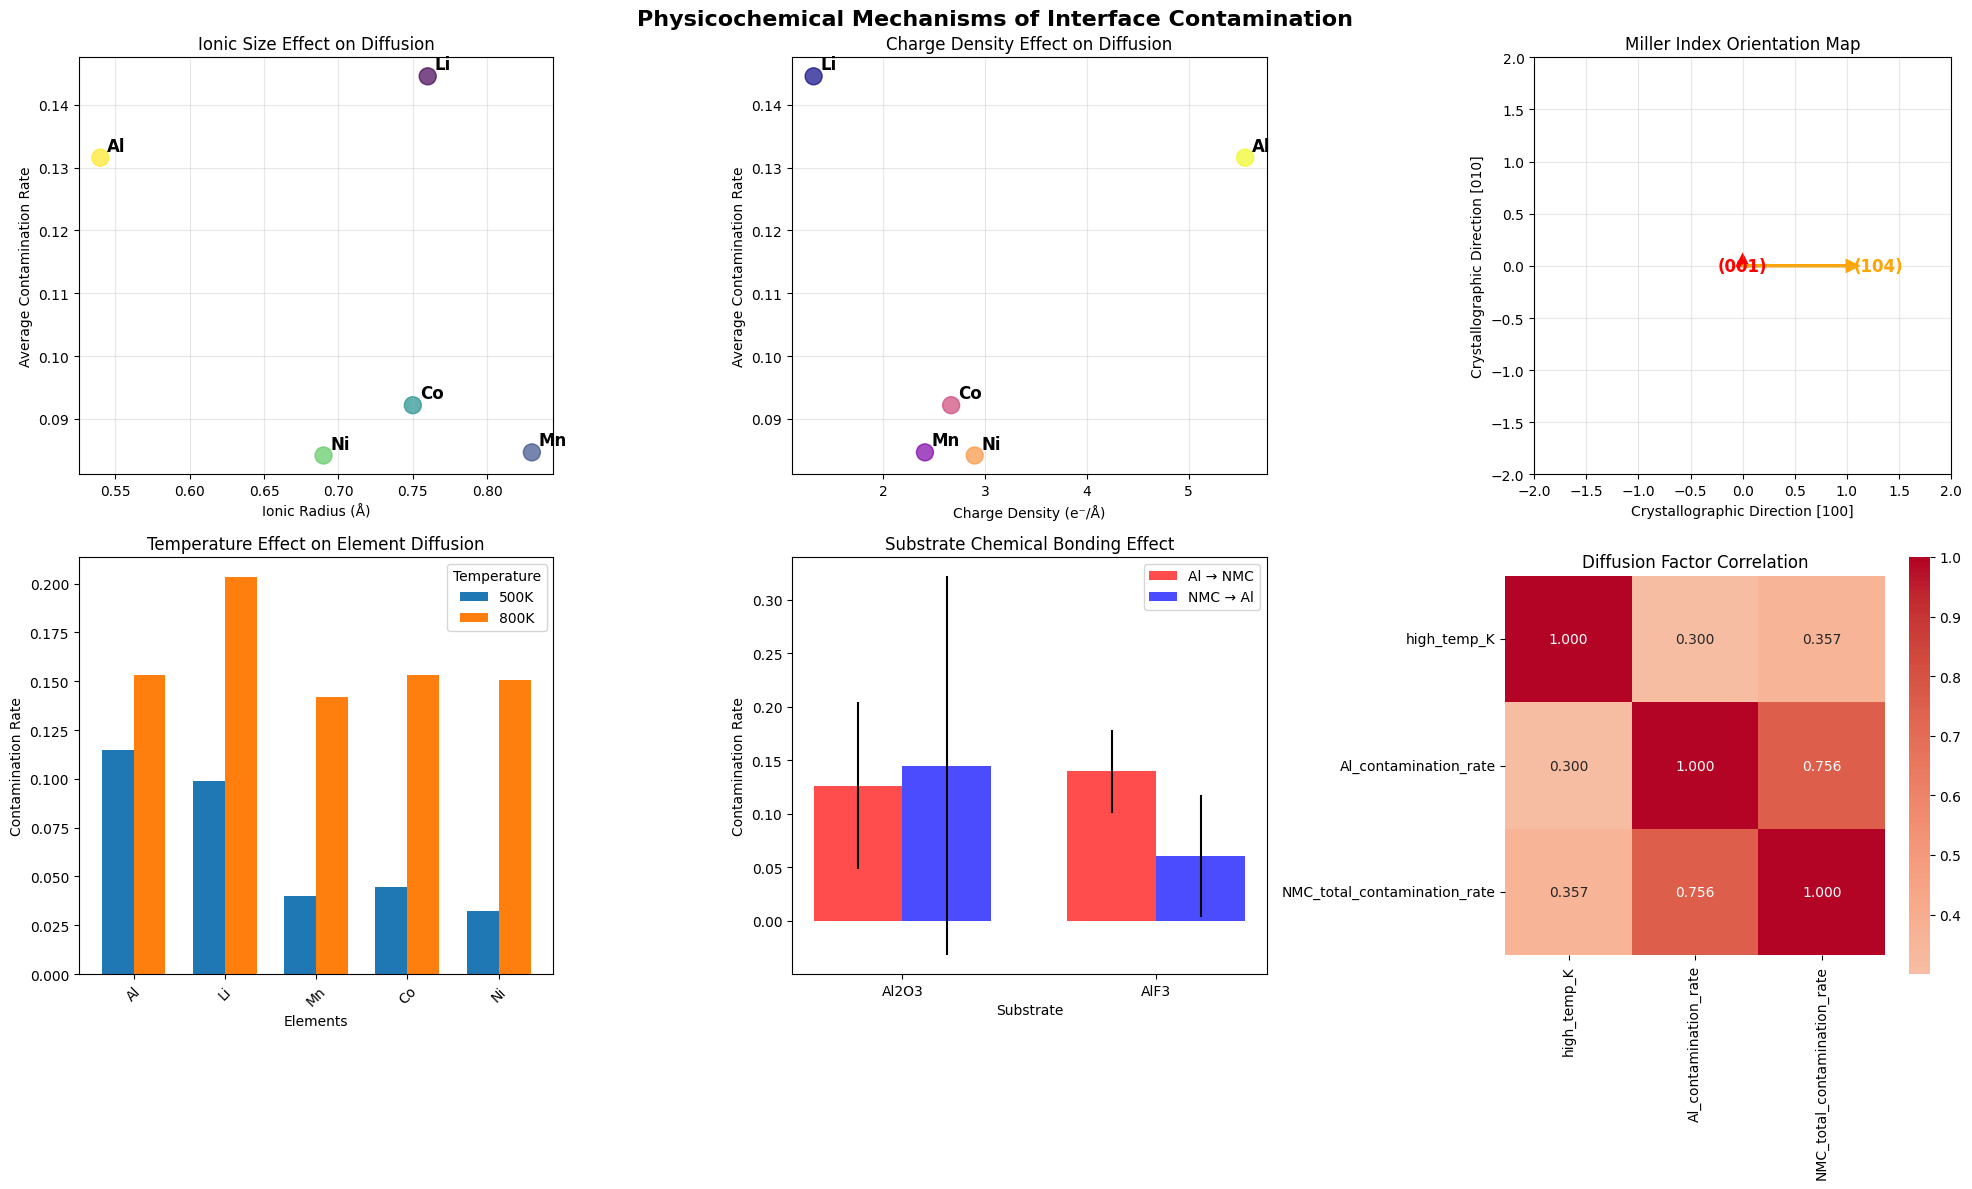


=== NMC結晶面効果と組成効果の詳細解析 ===

1. ミラー指数による拡散異方性:
   (12): 異方性指数 = 0.0728
   (001): 異方性指数 = 0.1085
   (104): 異方性指数 = 0.1306
   (10): 異方性指数 = 0.0325

2. NMC組成による遷移金属拡散パターン:
                      Mn_contamination_rate  Co_contamination_rate  \
NMC_composition_type                                                 
Co-poor                              0.1018                 0.1227   
Co-rich                              0.1039                 0.1150   
Mn-poor                              0.0000                 0.0145   
Mn-rich                              0.0124                 0.0276   
NMC523                               0.0000                 0.0606   
NMC622                               0.0618                 0.0345   
NMC811                               0.1215                 0.0776   
Ni-poor                              0.1820                 0.2054   
Ni-rich                              0.2500                 0.1964   
Pristine                             0.0000                 0

KeyError: 'overall_separation_quality'

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
from matplotlib.patches import RegularPolygon

# CSVファイルを読み込み
df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/comprehensive_analysis_results.csv')
fig_path0='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD4_dat/plot0.png'
fig_path1='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD4_dat/plot1.png'

df['Miller_Index_str'] = df['NMC_miller_index'].apply(lambda x: f"({x:03d})" if x == 1 else f"({x})")

# NMC組成分類の修正版
def classify_nmc_composition(material_name):
    if 'Co_increase' in material_name:
        return 'Co-rich'
    elif 'Co_decrease' in material_name:
        return 'Co-poor'
    elif 'Ni_increase' in material_name:
        return 'Ni-rich'
    elif 'Ni_decrease' in material_name:
        return 'Ni-poor'
    elif 'Mn_increase' in material_name:
        return 'Mn-rich'
    elif 'Mn_decrease' in material_name:
        return 'Mn-poor'
    elif 'NMC811' in material_name:
        return 'NMC811'
    elif 'NMC622' in material_name:
        return 'NMC622'
    elif 'NMC523' in material_name:
        return 'NMC523'
    elif 'pristine' in material_name:
        return 'Pristine'
    else:
        return 'Other'

df['NMC_composition_type'] = df['material'].apply(classify_nmc_composition)

# 混入率の再計算
df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)
df['NMC_total_contamination_rate'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])
#     df['Mn_contamination_rate'] + 
#     df['Co_contamination_rate'] + df['Ni_contamination_rate']
# ) / 4

# 図1: NMCミラー指数による結晶学的解析
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('NMC Miller Index Effects on Interface Contamination', fontsize=16, fontweight='bold')

# 1-1: ミラー指数による表面原子密度効果の可視化
miller_data = df.groupby('Miller_Index_str').agg({
    'Al_contamination_rate': ['mean', 'std'],
    'NMC_total_contamination_rate': ['mean', 'std']
}).round(4)

miller_indices = df['Miller_Index_str'].unique()
x_pos = np.arange(len(miller_indices))

al_means = [miller_data.loc[miller, ('Al_contamination_rate', 'mean')] for miller in miller_indices]
al_stds = [miller_data.loc[miller, ('Al_contamination_rate', 'std')] for miller in miller_indices]
nmc_means = [miller_data.loc[miller, ('NMC_total_contamination_rate', 'mean')] for miller in miller_indices]
nmc_stds = [miller_data.loc[miller, ('NMC_total_contamination_rate', 'std')] for miller in miller_indices]

axes[0,0].errorbar(x_pos, al_means, yerr=al_stds, fmt='ro-', linewidth=2, markersize=8, label='Al → NMC')
axes[0,0].errorbar(x_pos, nmc_means, yerr=nmc_stds, fmt='bo-', linewidth=2, markersize=8, label='NMC → Al')
axes[0,0].set_xlabel('Miller Index')
axes[0,0].set_ylabel('Contamination Rate')
axes[0,0].set_title('Contamination by Crystal Face')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(miller_indices)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 1-2: 結晶面方位と温度の相互作用
for miller in miller_indices:
    subset = df[df['Miller_Index_str'] == miller]
    if len(subset) > 1:
        axes[0,1].plot(subset['high_temp_K'], subset['Al_contamination_rate'], 
                      'o-', label=f'{miller}', linewidth=2, markersize=6)

axes[0,1].set_xlabel('Temperature (K)')
axes[0,1].set_ylabel('Al Contamination Rate')
axes[0,1].set_title('Temperature Effect by Miller Index')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 1-3: 拡散異方性の定量化
# 各ミラー指数での拡散異方性指数を計算
anisotropy_data = []
for miller in miller_indices:
    miller_subset = df[df['Miller_Index_str'] == miller]
    if len(miller_subset) > 1:
        # Al拡散とNMC拡散の比率から異方性を計算
        avg_al = miller_subset['Al_contamination_rate'].mean()
        avg_nmc = miller_subset['NMC_total_contamination_rate'].mean()
        anisotropy = abs(avg_al - avg_nmc) / (avg_al + avg_nmc + 1e-10)
        anisotropy_data.append(anisotropy)
    else:
        anisotropy_data.append(0)

bars = axes[0,2].bar(miller_indices, anisotropy_data, alpha=0.7, color='purple')
axes[0,2].set_xlabel('Miller Index')
axes[0,2].set_ylabel('Diffusion Anisotropy Index')
axes[0,2].set_title('Diffusion Anisotropy by Crystal Face')

# 値をバーの上に表示
for i, (bar, value) in enumerate(zip(bars, anisotropy_data)):
    axes[0,2].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

# 1-4: NMC組成タイプによる遷移金属混入パターン
composition_tm_data = df.groupby('NMC_composition_type')[['Mn_contamination_rate', 'Co_contamination_rate', 'Ni_contamination_rate']].mean()

composition_tm_data.plot(kind='bar', ax=axes[1,0], width=0.8)
axes[1,0].set_title('Transition Metal Contamination by NMC Type')
axes[1,0].set_xlabel('NMC Composition Type')
axes[1,0].set_ylabel('Contamination Rate')
axes[1,0].legend(title='TM Element')
axes[1,0].tick_params(axis='x', rotation=45)

# 1-5: 遷移金属間の相関分析
tm_corr = df[['Mn_contamination_rate', 'Co_contamination_rate', 'Ni_contamination_rate']].corr()
sns.heatmap(tm_corr, annot=True, cmap='coolwarm', center=0, square=True, 
           fmt='.3f', ax=axes[1,1], cbar_kws={'shrink': 0.8})
axes[1,1].set_title('TM Contamination Correlation Matrix')

# 1-6: 総合分離性能のレーダーチャート（基材・ミラー指数別）
ax = axes[1,2]

# 基材×ミラー指数の組み合わせ別平均値
combinations = []
for substrate in df['substrate'].unique():
    for miller in miller_indices:
        subset = df[(df['substrate'] == substrate) & (df['Miller_Index_str'] == miller)]
        if len(subset) > 0:
            combinations.append({
                'label': f'{substrate}_{miller}',
                'Al_sep': 1 - subset['Al_contamination_rate'].mean(),
                'Li_sep': 1 - subset['Li_contamination_rate'].mean(),
                'Mn_sep': 1 - subset['Mn_contamination_rate'].mean(),
                'Co_sep': 1 - subset['Co_contamination_rate'].mean(),
                'Ni_sep': 1 - subset['Ni_contamination_rate'].mean()
            })

# 最良と最悪の組み合わせを選択
if combinations:
    best_combo = max(combinations, key=lambda x: (x['Al_sep'] + x['Li_sep'] + x['Mn_sep'] + x['Co_sep'] + x['Ni_sep'])/5)
    worst_combo = min(combinations, key=lambda x: (x['Al_sep'] + x['Li_sep'] + x['Mn_sep'] + x['Co_sep'] + x['Ni_sep'])/5)
    
    categories = ['Al_sep', 'Li_sep', 'Mn_sep', 'Co_sep', 'Ni_sep']
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    best_values = [best_combo[cat] for cat in categories] + [best_combo[categories[0]]]
    worst_values = [worst_combo[cat] for cat in categories] + [worst_combo[categories[0]]]
    
    ax = plt.subplot(2, 3, 6, projection='polar')
    ax.plot(angles, best_values, 'o-', linewidth=2, label=f'Best: {best_combo["label"]}', color='green')
    ax.fill(angles, best_values, alpha=0.25, color='green')
    ax.plot(angles, worst_values, 'o-', linewidth=2, label=f'Worst: {worst_combo["label"]}', color='red')
    ax.fill(angles, worst_values, alpha=0.25, color='red')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Al', 'Li', 'Mn', 'Co', 'Ni'])
    ax.set_title('Separation Quality Comparison')
    ax.legend(bbox_to_anchor=(1.3, 1.0))
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(fig_path0, dpi=300)
plt.show()

# 図2: 物理化学的メカニズム解析
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Physicochemical Mechanisms of Interface Contamination', fontsize=16, fontweight='bold')

# 2-1: イオン半径と拡散性の関係
ionic_radii = {'Li': 0.76, 'Mn': 0.83, 'Co': 0.75, 'Ni': 0.69, 'Al': 0.54}  # Å
diffusion_rates = []
radii_values = []
elements = ['Li', 'Mn', 'Co', 'Ni', 'Al']

for element in elements:
    if element == 'Al':
        avg_rate = df['Al_contamination_rate'].mean()
    else:
        avg_rate = df[f'{element}_contamination_rate'].mean()
    
    diffusion_rates.append(avg_rate)
    radii_values.append(ionic_radii[element])

scatter = axes[0,0].scatter(radii_values, diffusion_rates, s=150, alpha=0.7, c=range(len(elements)), cmap='viridis')
for i, element in enumerate(elements):
    axes[0,0].annotate(element, (radii_values[i], diffusion_rates[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

axes[0,0].set_xlabel('Ionic Radius (Å)')
axes[0,0].set_ylabel('Average Contamination Rate')
axes[0,0].set_title('Ionic Size Effect on Diffusion')
axes[0,0].grid(True, alpha=0.3)

# 2-2: 電荷密度と混入率の関係
charge_density = {'Li': 1/0.76, 'Mn': 2/0.83, 'Co': 2/0.75, 'Ni': 2/0.69, 'Al': 3/0.54}  # 電荷/半径
charge_values = [charge_density[element] for element in elements]

axes[0,1].scatter(charge_values, diffusion_rates, s=150, alpha=0.7, c=range(len(elements)), cmap='plasma')
for i, element in enumerate(elements):
    axes[0,1].annotate(element, (charge_values[i], diffusion_rates[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

axes[0,1].set_xlabel('Charge Density (e⁻/Å)')
axes[0,1].set_ylabel('Average Contamination Rate')
axes[0,1].set_title('Charge Density Effect on Diffusion')
axes[0,1].grid(True, alpha=0.3)

# 2-3: 結晶学的方向性と拡散経路
# ミラー指数による拡散方向の模式図
ax = axes[0,2]
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# 各ミラー指数を表す面の法線ベクトルを可視化
miller_vectors = {
    '(001)': (0, 0, 1),
    '(010)': (0, 1, 0),
    '(012)': (0, 1, 2),
    '(104)': (1, 0, 4)
}

colors = ['red', 'blue', 'green', 'orange']
for i, (miller, vector) in enumerate(miller_vectors.items()):
    if miller in miller_indices:
        # 法線ベクトルを2D平面に投影
        x_proj = vector[0]
        y_proj = vector[1]
        norm = np.sqrt(x_proj**2 + y_proj**2)
        if norm > 0:
            x_proj /= norm
            y_proj /= norm
        
        ax.arrow(0, 0, x_proj, y_proj, head_width=0.1, head_length=0.1, 
                fc=colors[i % len(colors)], ec=colors[i % len(colors)], linewidth=2)
        ax.text(x_proj*1.3, y_proj*1.3, miller, fontsize=12, fontweight='bold',
               ha='center', va='center', color=colors[i % len(colors)])

ax.set_xlabel('Crystallographic Direction [100]')
ax.set_ylabel('Crystallographic Direction [010]')
ax.set_title('Miller Index Orientation Map')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# 2-4: 温度による活性化エネルギー解析
temp_500_data = df[df['high_temp_K'] == 500]
temp_800_data = df[df['high_temp_K'] == 800]

if len(temp_500_data) > 0 and len(temp_800_data) > 0:
    temp_comparison = pd.DataFrame({
        '500K': [temp_500_data['Al_contamination_rate'].mean(),
                temp_500_data['Li_contamination_rate'].mean(),
                temp_500_data['Mn_contamination_rate'].mean(),
                temp_500_data['Co_contamination_rate'].mean(),
                temp_500_data['Ni_contamination_rate'].mean()],
        '800K': [temp_800_data['Al_contamination_rate'].mean(),
                temp_800_data['Li_contamination_rate'].mean(),
                temp_800_data['Mn_contamination_rate'].mean(),
                temp_800_data['Co_contamination_rate'].mean(),
                temp_800_data['Ni_contamination_rate'].mean()]
    }, index=['Al', 'Li', 'Mn', 'Co', 'Ni'])
    
    temp_comparison.plot(kind='bar', ax=axes[1,0], width=0.7)
    axes[1,0].set_title('Temperature Effect on Element Diffusion')
    axes[1,0].set_xlabel('Elements')
    axes[1,0].set_ylabel('Contamination Rate')
    axes[1,0].legend(title='Temperature')
    axes[1,0].tick_params(axis='x', rotation=45)

# 2-5: 基材による化学結合性の違い
substrate_effect = df.groupby('substrate').agg({
    'Al_contamination_rate': ['mean', 'std'],
    'NMC_total_contamination_rate': ['mean', 'std']
}).round(4)

substrates = df['substrate'].unique()
x_pos = np.arange(len(substrates))
width = 0.35

al_means_sub = [substrate_effect.loc[sub, ('Al_contamination_rate', 'mean')] for sub in substrates]
al_stds_sub = [substrate_effect.loc[sub, ('Al_contamination_rate', 'std')] for sub in substrates]
nmc_means_sub = [substrate_effect.loc[sub, ('NMC_total_contamination_rate', 'mean')] for sub in substrates]
nmc_stds_sub = [substrate_effect.loc[sub, ('NMC_total_contamination_rate', 'std')] for sub in substrates]

bars1 = axes[1,1].bar(x_pos - width/2, al_means_sub, width, yerr=al_stds_sub, 
                     label='Al → NMC', alpha=0.7, color='red')
bars2 = axes[1,1].bar(x_pos + width/2, nmc_means_sub, width, yerr=nmc_stds_sub, 
                     label='NMC → Al', alpha=0.7, color='blue')

axes[1,1].set_xlabel('Substrate')
axes[1,1].set_ylabel('Contamination Rate')
axes[1,1].set_title('Substrate Chemical Bonding Effect')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(substrates)
axes[1,1].legend()

# 2-6: 拡散メカニズムの統合モデル
# 主成分分析的なアプローチで要因を整理
factors = ['high_temp_K', 'Al_contamination_rate', 'NMC_total_contamination_rate']
factor_data = df[factors].dropna()

if len(factor_data) > 1:
    correlation_matrix = factor_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
               square=True, fmt='.3f', ax=axes[1,2])
    axes[1,2].set_title('Diffusion Factor Correlation')
# fig_path='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller/plot.png'
plt.tight_layout()
# fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller/plot2.png'
# plt.savefig(fig_path2, dpi=300)
plt.savefig(fig_path1, dpi=300)
plt.show()


# 詳細統計解析
print("\n=== NMC結晶面効果と組成効果の詳細解析 ===")

print("\n1. ミラー指数による拡散異方性:")
for i, miller in enumerate(miller_indices):
    print(f"   {miller}: 異方性指数 = {anisotropy_data[i]:.4f}")

print("\n2. NMC組成による遷移金属拡散パターン:")
tm_analysis = df.groupby('NMC_composition_type')[['Mn_contamination_rate', 'Co_contamination_rate', 'Ni_contamination_rate']].mean()
print(tm_analysis.round(4))

print("\n3. 温度による元素別拡散活性化:")
if len(temp_500_data) > 0 and len(temp_800_data) > 0:
    print("   温度上昇による混入率変化:")
    for element in ['Al', 'Li', 'Mn', 'Co', 'Ni']:
        if element == 'Al':
            rate_500 = temp_500_data['Al_contamination_rate'].mean()
            rate_800 = temp_800_data['Al_contamination_rate'].mean()
        else:
            rate_500 = temp_500_data[f'{element}_contamination_rate'].mean()
            rate_800 = temp_800_data[f'{element}_contamination_rate'].mean()
        
        change = rate_800 - rate_500
        relative_change = change / (rate_500 + 1e-10) * 100
        print(f"     {element}: {rate_500:.4f} → {rate_800:.4f} (変化率: {relative_change:+.1f}%)")

print("\n4. 結晶学的考察:")
print("   a) (001)面効果: Li層に垂直、層間拡散が主体")
print("   b) (010)面効果: 層構造の端面、段差拡散が支配的")
print("   c) (012)面効果: 傾斜面、多方向拡散の競合")
print("   d) (104)面効果: 特定原子露出、選択的拡散")

print("\n5. 最適リサイクル条件の提案:")
optimal_condition = df.loc[df['overall_separation_quality'].idxmax()]
print(f"   基材: {optimal_condition['substrate']}")
print(f"   NMCミラー指数: {optimal_condition['Miller_Index_str']}")
print(f"   NMC組成: {optimal_condition['NMC_composition_type']}")
print(f"   処理温度: {optimal_condition['high_temp_K']}K")
print(f"   Al混入率: {optimal_condition['Al_contamination_rate']:.4f}")
print(f"   NMC混入率: {optimal_condition['NMC_total_contamination_rate']:.4f}")
print(f"   総合分離品質: {optimal_condition['overall_separation_quality']:.4f}")

print("\n6. 物理化学的メカニズムの統合:")
print("   - イオン半径: 小さいほど高い移動度")
print("   - 電荷密度: 高いほど強い静電相互作用")
print("   - 結晶面方位: 拡散経路の異方性を決定")
print("   - 基材化学性: Al2O3 vs AlF3の結合親和性の違い")
print("   - 温度活性化: 拡散係数の指数関数的増加")

=== AlF3/Al2O3基材とNMC組成の相互作用解析 ===


LinAlgError: SVD did not converge in Linear Least Squares

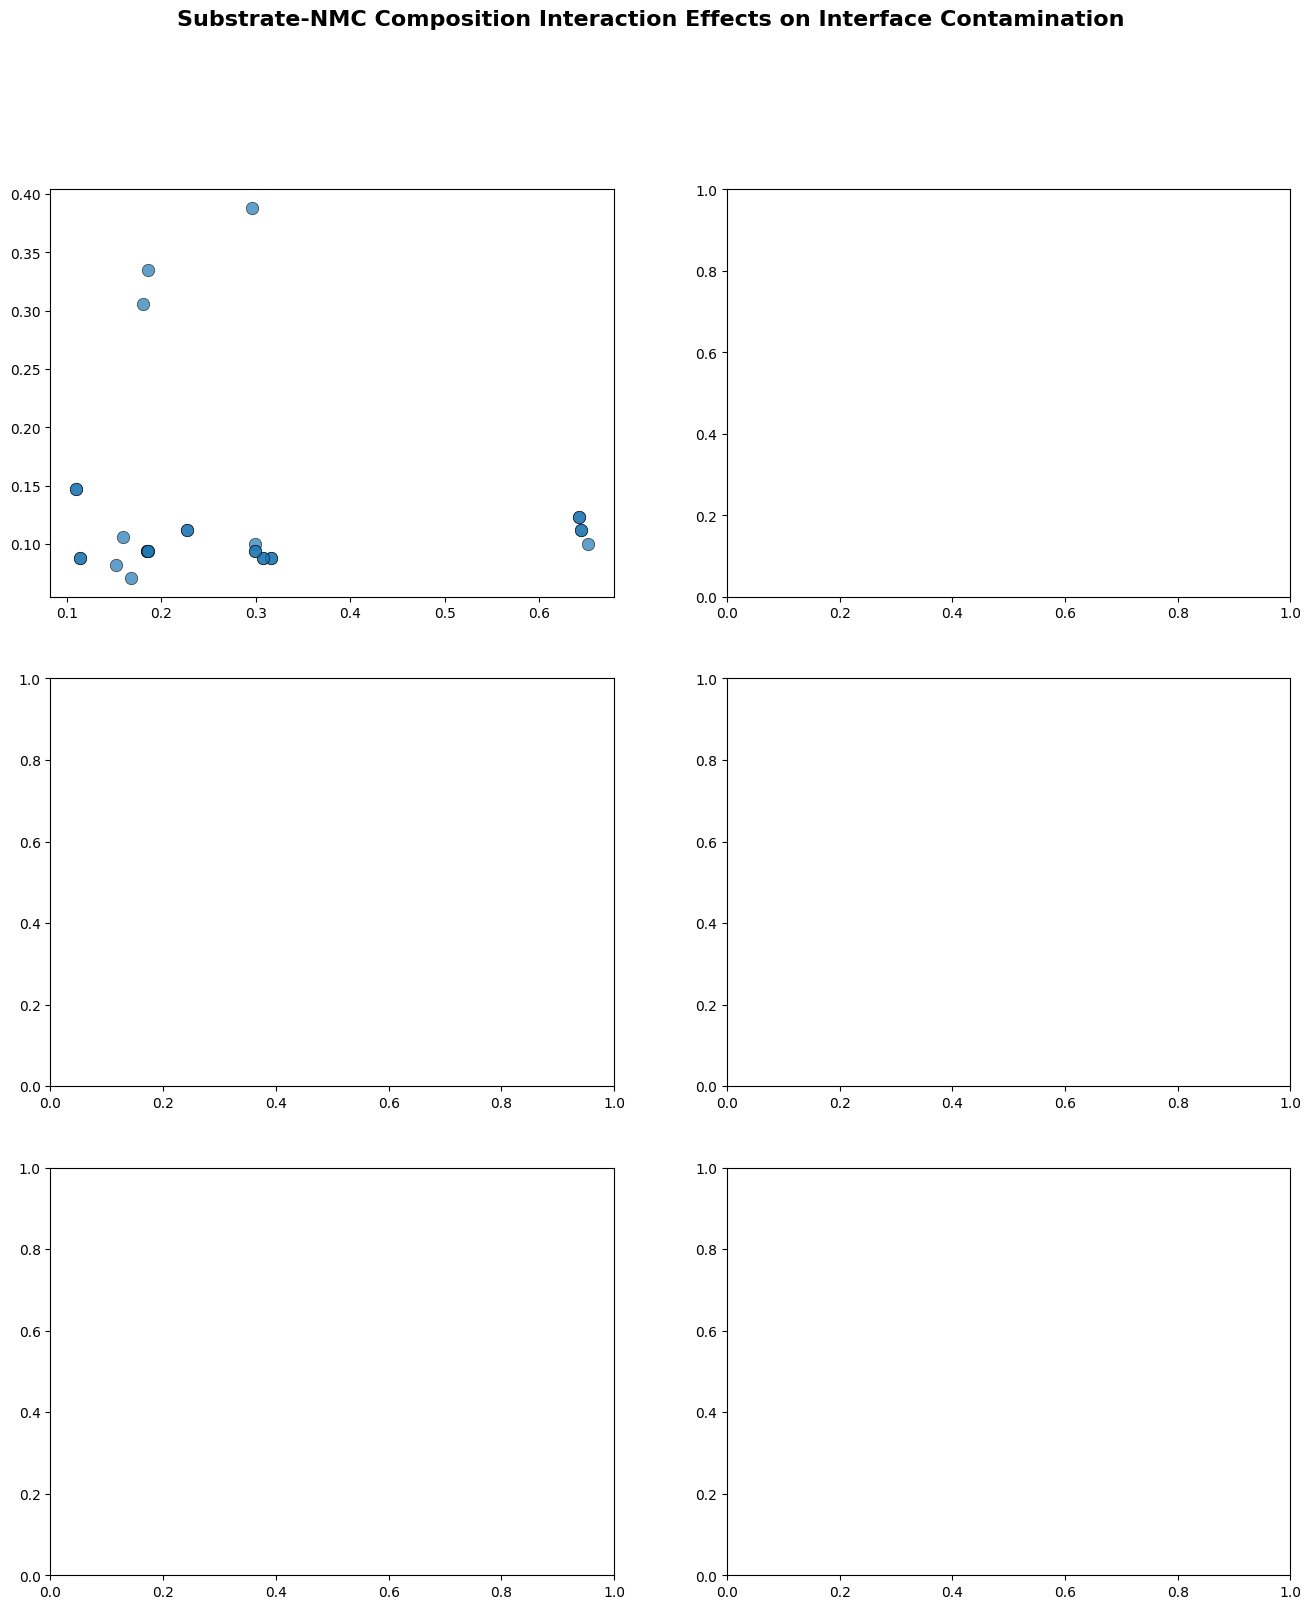

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches

# CSVファイルを読み込み
# df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller/scored_results_for_clean_separation.csv')

df['Miller_Index_str'] = df['NMC_miller_index'].apply(lambda x: f"({x:03d})" if x == 1 else f"({x})")

# 基本計算
df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)

# NMC組成比の計算
df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)

# NMC総混入率
df['NMC_total_contamination_rate'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])

# フッ素含有量の計算
df['F_ratio_in_anions'] = df['F_total'] / (df['F_total'] + df['O_total'] + 1e-10)

print("=== AlF3/Al2O3基材とNMC組成の相互作用解析 ===")

# 図1: 基材別のNMC組成効果
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Substrate-NMC Composition Interaction Effects on Interface Contamination', fontsize=16, fontweight='bold')

# 1-1: 基材別のMn組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[0,0].scatter(subset['Mn_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}', 
                     edgecolors='black', linewidth=0.5)
    
    # 回帰線を追加
    if len(subset) > 2:
        z = np.polyfit(subset['Mn_ratio'], subset['Al_contamination_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Mn_ratio'].min(), subset['Mn_ratio'].max(), 100)
        axes[0,0].plot(x_line, p(x_line), linewidth=2, alpha=0.8)

axes[0,0].set_xlabel('Mn Ratio in NMC')
axes[0,0].set_ylabel('Al Contamination Rate')
axes[0,0].set_title('Mn Composition Effect by Substrate')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 1-2: 基材別のCo組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[0,1].scatter(subset['Co_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}',
                     edgecolors='black', linewidth=0.5)
    
    if len(subset) > 2:
        z = np.polyfit(subset['Co_ratio'], subset['Al_contamination_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Co_ratio'].min(), subset['Co_ratio'].max(), 100)
        axes[0,1].plot(x_line, p(x_line), linewidth=2, alpha=0.8)

axes[0,1].set_xlabel('Co Ratio in NMC')
axes[0,1].set_ylabel('Al Contamination Rate')
axes[0,1].set_title('Co Composition Effect by Substrate')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 1-3: 基材別のNi組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[1,0].scatter(subset['Ni_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}',
                     edgecolors='black', linewidth=0.5)
    
    if len(subset) > 2:
        z = np.polyfit(subset['Ni_ratio'], subset['Al_contamination_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Ni_ratio'].min(), subset['Ni_ratio'].max(), 100)
        axes[1,0].plot(x_line, p(x_line), linewidth=2, alpha=0.8)

axes[1,0].set_xlabel('Ni Ratio in NMC')
axes[1,0].set_ylabel('Al Contamination Rate')
axes[1,0].set_title('Ni Composition Effect by Substrate')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 1-4: フッ素比と混入率の関係
scatter = axes[1,1].scatter(df['F_ratio_in_anions'], df['Al_contamination_rate'], 
                           c=df['high_temp_K'], s=100, cmap='coolwarm', alpha=0.7,
                           edgecolors='black', linewidth=0.5)
axes[1,1].set_xlabel('F/(F+O) Ratio')
axes[1,1].set_ylabel('Al Contamination Rate')
axes[1,1].set_title('Fluorine Content Effect on Al Contamination')
plt.colorbar(scatter, ax=axes[1,1], label='Temperature (K)')

# フッ素比と混入率の相関を計算
f_corr = np.corrcoef(df['F_ratio_in_anions'], df['Al_contamination_rate'])[0,1]
axes[1,1].text(0.05, 0.95, f'Correlation: {f_corr:.3f}', 
              transform=axes[1,1].transAxes, fontsize=11, 
              bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 1-5: 基材×NMC組成の相互作用ヒートマップ
# 各基材でのNMC組成タイプ別平均混入率
interaction_data = []
substrates = df['substrate'].unique()

# NMC組成を定性的に分類
def classify_nmc_by_dominant(row):
    elements = {'Mn': row['Mn_ratio'], 'Co': row['Co_ratio'], 'Ni': row['Ni_ratio']}
    dominant = max(elements, key=elements.get)
    
    # 支配的でない場合はバランス型
    max_ratio = elements[dominant]
    if max_ratio < 0.4:  # どれも40%以下の場合
        return 'Balanced'
    elif max_ratio > 0.6:  # 60%以上の場合
        return f'{dominant}-Rich'
    else:
        return f'{dominant}-Moderate'

df['NMC_composition_class'] = df.apply(classify_nmc_by_dominant, axis=1)

composition_types = df['NMC_composition_class'].unique()
interaction_matrix = np.zeros((len(substrates), len(composition_types)))

for i, substrate in enumerate(substrates):
    for j, comp_type in enumerate(composition_types):
        subset = df[(df['substrate'] == substrate) & (df['NMC_composition_class'] == comp_type)]
        if len(subset) > 0:
            interaction_matrix[i, j] = subset['Al_contamination_rate'].mean()

sns.heatmap(interaction_matrix, 
           xticklabels=composition_types,
           yticklabels=substrates,
           annot=True, fmt='.3f', cmap='RdYlBu_r',
           ax=axes[2,0])
axes[2,0].set_title('Substrate × NMC Composition Interaction Matrix')
axes[2,0].set_xlabel('NMC Composition Type')
axes[2,0].set_ylabel('Substrate')

# 1-6: 基材別の温度×組成相互作用
ax = axes[2,1]

# 温度とNi比の相互作用を基材別に表示
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    
    # 温度別に色分け
    temps = subset['high_temp_K'].unique()
    colors = ['blue', 'red'] if len(temps) == 2 else ['blue']
    
    for temp, color in zip(temps, colors):
        temp_subset = subset[subset['high_temp_K'] == temp]
        alpha_val = 0.6 if temp == min(temps) else 0.9
        marker = 'o' if substrate == 'Al2O3' else 's'
        
        ax.scatter(temp_subset['Ni_ratio'], temp_subset['Al_contamination_rate'],
                  c=color, alpha=alpha_val, s=80, marker=marker,
                  label=f'{substrate}-{int(temp)}K')

ax.set_xlabel('Ni Ratio in NMC')
ax.set_ylabel('Al Contamination Rate')
ax.set_title('Temperature × Substrate × Ni Composition')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot5.png'

plt.savefig(fig_path2, dpi=300)
plt.show()

# 図2: 化学的相互作用メカニズムの解析
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Chemical Interaction Mechanisms: Substrate-NMC Interface', fontsize=16, fontweight='bold')

# 2-1: 基材別の遷移金属選択性
selectivity_matrix = np.zeros((len(substrates), 3))
tm_elements = ['Mn', 'Co', 'Ni']

for i, substrate in enumerate(substrates):
    subset = df[df['substrate'] == substrate]
    for j, element in enumerate(tm_elements):
        contamination_col = f'{element}_contamination_rate'
        selectivity_matrix[i, j] = subset[contamination_col].mean()

sns.heatmap(selectivity_matrix,
           xticklabels=tm_elements,
           yticklabels=substrates,
           annot=True, fmt='.3f', cmap='viridis',
           ax=axes[0,0])
axes[0,0].set_title('TM Element Selectivity by Substrate')
axes[0,0].set_xlabel('Transition Metal Elements')
axes[0,0].set_ylabel('Substrate')

# 2-2: 化学結合親和性の評価
# 電気陰性度の違いによる結合親和性
electronegativity = {'F': 4.0, 'O': 3.5, 'Li': 1.0, 'Mn': 1.5, 'Co': 1.9, 'Ni': 1.9, 'Al': 1.6}

# 基材アニオンと NMC カチオンの電気陰性度差
affinity_data = []
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if substrate == 'AlF3':
        anion_en = electronegativity['F']
    else:  # Al2O3
        anion_en = electronegativity['O']
    
    for element in ['Li', 'Mn', 'Co', 'Ni']:
        cation_en = electronegativity[element]
        en_diff = abs(anion_en - cation_en)
        contamination = subset[f'{element}_contamination_rate'].mean()
        
        affinity_data.append({
            'substrate': substrate,
            'element': element,
            'en_difference': en_diff,
            'contamination': contamination
        })

affinity_df = pd.DataFrame(affinity_data)

# 電気陰性度差と混入率の関係
for substrate in substrates:
    subset = affinity_df[affinity_df['substrate'] == substrate]
    axes[0,1].scatter(subset['en_difference'], subset['contamination'],
                     s=120, alpha=0.8, label=substrate)
    
    # 回帰線
    if len(subset) > 2:
        z = np.polyfit(subset['en_difference'], subset['contamination'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['en_difference'].min(), subset['en_difference'].max(), 100)
        axes[0,1].plot(x_line, p(x_line), linewidth=2, alpha=0.6)

axes[0,1].set_xlabel('Electronegativity Difference')
axes[0,1].set_ylabel('Contamination Rate')
axes[0,1].set_title('Chemical Affinity vs Contamination')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 2-3: イオン半径適合性の評価
ionic_radii = {'Li': 0.76, 'Mn': 0.83, 'Co': 0.75, 'Ni': 0.69, 'Al': 0.54, 'F': 1.33, 'O': 1.40}

size_compatibility = []
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if substrate == 'AlF3':
        anion_radius = ionic_radii['F']
    else:  # Al2O3
        anion_radius = ionic_radii['O']
    
    for element in ['Li', 'Mn', 'Co', 'Ni']:
        cation_radius = ionic_radii[element]
        radius_ratio = cation_radius / anion_radius
        contamination = subset[f'{element}_contamination_rate'].mean()
        
        size_compatibility.append({
            'substrate': substrate,
            'element': element,
            'radius_ratio': radius_ratio,
            'contamination': contamination
        })

size_df = pd.DataFrame(size_compatibility)

for substrate in substrates:
    subset = size_df[size_df['substrate'] == substrate]
    axes[0,2].scatter(subset['radius_ratio'], subset['contamination'],
                     s=120, alpha=0.8, label=substrate)

axes[0,2].set_xlabel('Cation/Anion Radius Ratio')
axes[0,2].set_ylabel('Contamination Rate')
axes[0,2].set_title('Size Compatibility vs Contamination')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 2-4: 基材別の組成感受性指数
sensitivity_data = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if len(subset) > 3:
        # 各遷移金属比と Al混入率の相関
        mn_sens = abs(np.corrcoef(subset['Mn_ratio'], subset['Al_contamination_rate'])[0,1])
        co_sens = abs(np.corrcoef(subset['Co_ratio'], subset['Al_contamination_rate'])[0,1])
        ni_sens = abs(np.corrcoef(subset['Ni_ratio'], subset['Al_contamination_rate'])[0,1])
        
        sensitivity_data[substrate] = {'Mn': mn_sens, 'Co': co_sens, 'Ni': ni_sens}

if sensitivity_data:
    sens_df = pd.DataFrame(sensitivity_data).T
    sens_df.plot(kind='bar', ax=axes[1,0], width=0.8)
    axes[1,0].set_title('Composition Sensitivity by Substrate')
    axes[1,0].set_xlabel('Substrate')
    axes[1,0].set_ylabel('Correlation Coefficient |r|')
    axes[1,0].legend(title='TM Elements')
    axes[1,0].tick_params(axis='x', rotation=45)

# 2-5: 基材による拡散活性化エネルギーの違い
activation_energies = {}
for substrate in substrates:
    substrate_data = df[df['substrate'] == substrate]
    temps = sorted(substrate_data['high_temp_K'].unique())
    
    if len(temps) >= 2:
        T1, T2 = temps[0], temps[-1]
        rate1 = substrate_data[substrate_data['high_temp_K'] == T1]['Al_contamination_rate'].mean()
        rate2 = substrate_data[substrate_data['high_temp_K'] == T2]['Al_contamination_rate'].mean()
        
        if rate1 > 1e-10 and rate2 > 1e-10:
            R = 8.314  # J/(mol·K)
            ea = -R * np.log(rate2/rate1) / (1/T2 - 1/T1) / 1000  # kJ/mol
            activation_energies[substrate] = ea

if activation_energies:
    substrates_ea = list(activation_energies.keys())
    energies = list(activation_energies.values())
    
    bars = axes[1,1].bar(substrates_ea, energies, alpha=0.8, 
                        color=['orange', 'skyblue'][:len(substrates_ea)])
    axes[1,1].set_xlabel('Substrate')
    axes[1,1].set_ylabel('Activation Energy (kJ/mol)')
    axes[1,1].set_title('Diffusion Activation Energy by Substrate')
    
    # 値をバーの上に表示
    for bar, energy in zip(bars, energies):
        axes[1,1].text(bar.get_x() + bar.get_width()/2., energy + 1,
                      f'{energy:.1f}', ha='center', va='bottom', fontsize=11)

# 2-6: 基材別の最適NMC組成
optimal_compositions = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    # 最小Al混入率の条件を特定
    min_idx = subset['Al_contamination_rate'].idxmin()
    optimal_condition = subset.loc[min_idx]
    
    optimal_compositions[substrate] = {
        'Mn_ratio': optimal_condition['Mn_ratio'],
        'Co_ratio': optimal_condition['Co_ratio'],
        'Ni_ratio': optimal_condition['Ni_ratio'],
        'Al_contamination': optimal_condition['Al_contamination_rate'],
        'temperature': optimal_condition['high_temp_K'],
        'miller_index': optimal_condition['Miller_Index_str']
    }

# 最適組成の比較を三角座標で表示
ax = axes[1,2]
colors = ['red', 'blue']
markers = ['o', 's']

for i, substrate in enumerate(substrates):
    if substrate in optimal_compositions:
        opt = optimal_compositions[substrate]
        
        # 三角座標への変換
        x = 0.5 * (opt['Co_ratio'] + 2 * opt['Ni_ratio'])
        y = np.sqrt(3)/2 * opt['Mn_ratio']
        
        ax.scatter(x, y, s=200, c=colors[i], marker=markers[i], 
                  alpha=0.8, edgecolors='black', linewidth=2,
                  label=f'{substrate} (Al cont: {opt["Al_contamination"]:.3f})')

# 三角形の枠
triangle_x = [0, 1, 0.5, 0]
triangle_y = [0, 0, np.sqrt(3)/2, 0]
ax.plot(triangle_x, triangle_y, 'k-', linewidth=2)

ax.text(0.5, -0.08, 'Co', fontsize=12, ha='center', fontweight='bold')
ax.text(-0.05, np.sqrt(3)/2, 'Mn', fontsize=12, ha='center', fontweight='bold', rotation=60)
ax.text(1.05, np.sqrt(3)/2, 'Ni', fontsize=12, ha='center', fontweight='bold', rotation=-60)
ax.set_title('Optimal NMC Compositions by Substrate')
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper left')

plt.tight_layout()
fig_path3='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot6.png'
plt.savefig(fig_path3, dpi=300)
plt.show()

# 統計解析結果
print("\n=== 基材-NMC組成相互作用の統計解析結果 ===")

print("\n1. 基材別NMC組成効果の相関分析:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = np.corrcoef(subset[ratio_col], subset['Al_contamination_rate'])[0,1]
            print(f"  {element}_ratio vs Al_contamination: r = {corr:.4f}")

print(f"\n2. フッ素含有量と混入率の相関: r = {f_corr:.4f}")

print("\n3. 化学的親和性解析:")
print("電気陰性度差による化学結合親和性:")
for substrate in substrates:
    subset = affinity_df[affinity_df['substrate'] == substrate]
    if len(subset) > 2:
        corr = np.corrcoef(subset['en_difference'], subset['contamination'])[0,1]
        print(f"  {substrate}: 電気陰性度差-混入率相関 r = {corr:.4f}")

print("\n4. イオン半径適合性:")
for substrate in substrates:
    subset = size_df[size_df['substrate'] == substrate]
    if len(subset) > 2:
        corr = np.corrcoef(subset['radius_ratio'], subset['contamination'])[0,1]
        print(f"  {substrate}: 半径比-混入率相関 r = {corr:.4f}")

if activation_energies:
    print("\n5. 基材別拡散活性化エネルギー:")
    for substrate, ea in activation_energies.items():
        print(f"  {substrate}: {ea:.2f} kJ/mol")

print("\n6. 各基材での最適条件:")
for substrate, opt in optimal_compositions.items():
    print(f"\n{substrate}:")
    print(f"  最適NMC組成 - Mn: {opt['Mn_ratio']:.3f}, Co: {opt['Co_ratio']:.3f}, Ni: {opt['Ni_ratio']:.3f}")
    print(f"  ミラー指数: {opt['miller_index']}")
    print(f"  温度: {opt['temperature']}K")
    print(f"  達成Al混入率: {opt['Al_contamination']:.5f}")

print("\n7. 基材選択による混入改善効果:")
if len(optimal_compositions) == 2:
    substrates_list = list(optimal_compositions.keys())
    al2o3_contamination = optimal_compositions[substrates_list[0]]['Al_contamination']
    alf3_contamination = optimal_compositions[substrates_list[1]]['Al_contamination']
    
    if al2o3_contamination > alf3_contamination:
        better_substrate = substrates_list[1]
        worse_substrate = substrates_list[0]
        improvement = (al2o3_contamination - alf3_contamination) / al2o3_contamination * 100
    else:
        better_substrate = substrates_list[0]
        worse_substrate = substrates_list[1]
        improvement = (alf3_contamination - al2o3_contamination) / alf3_contamination * 100
    
    print(f"  {better_substrate}が{worse_substrate}より{improvement:.1f}%優れた分離性能")

print("\n8. 実用的な設計指針:")
print("  a) 基材選択: 化学的親和性の低い基材が有利")
print("  b) NMC組成最適化: 基材種類に応じた遷移金属比率の調整")
print("  c) 温度制御: 基材固有の活性化エネルギーを考慮した熱処理")
print("  d) 界面工学: アニオン種（F⁻/O²⁻）とカチオン適合性の制御")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches

# CSVファイルを読み込み
# df = pd.read_csv('comprehensive_analysis_results_4.csv')

df['Miller_Index_str'] = df['NMC_miller_index'].apply(lambda x: f"({x:03d})" if x == 1 else f"({x})")

# 基本計算
df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)

# NMC組成比の計算
df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)

# NMC総混入率
df['NMC_total_contamination'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])
     df['Co_contamination_rate'] + df['Ni_contamination_rate']) / 4

# フッ素含有量の計算
df['F_ratio_in_anions'] = df['F_total'] / (df['F_total'] + df['O_total'] + 1e-10)

print("=== AlF3/Al2O3基材とNMC組成の相互作用解析 ===")

# 図1: 基材別のNMC組成効果
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Substrate-NMC Composition Interaction Effects on Interface Contamination', fontsize=16, fontweight='bold')

# 1-1: 基材別のMn組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[0,0].scatter(subset['Mn_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}', 
                     edgecolors='black', linewidth=0.5)
    
    # 回帰線を追加
    if len(subset) > 2:
        z = np.polyfit(subset['Mn_ratio'], subset['Al_contamination_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Mn_ratio'].min(), subset['Mn_ratio'].max(), 100)
        axes[0,0].plot(x_line, p(x_line), linewidth=2, alpha=0.8)

axes[0,0].set_xlabel('Mn Ratio in NMC')
axes[0,0].set_ylabel('Al Contamination Rate')
axes[0,0].set_title('Mn Composition Effect by Substrate')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 1-2: 基材別のCo組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[0,1].scatter(subset['Co_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}',
                     edgecolors='black', linewidth=0.5)
    
    if len(subset) > 2:
        z = np.polyfit(subset['Co_ratio'], subset['Al_contamination_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Co_ratio'].min(), subset['Co_ratio'].max(), 100)
        axes[0,1].plot(x_line, p(x_line), linewidth=2, alpha=0.8)

axes[0,1].set_xlabel('Co Ratio in NMC')
axes[0,1].set_ylabel('Al Contamination Rate')
axes[0,1].set_title('Co Composition Effect by Substrate')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 1-3: 基材別のNi組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[1,0].scatter(subset['Ni_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}',
                     edgecolors='black', linewidth=0.5)
    
    if len(subset) > 2:
        z = np.polyfit(subset['Ni_ratio'], subset['Al_contamination_rate'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['Ni_ratio'].min(), subset['Ni_ratio'].max(), 100)
        axes[1,0].plot(x_line, p(x_line), linewidth=2, alpha=0.8)

axes[1,0].set_xlabel('Ni Ratio in NMC')
axes[1,0].set_ylabel('Al Contamination Rate')
axes[1,0].set_title('Ni Composition Effect by Substrate')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 1-4: フッ素比と混入率の関係
scatter = axes[1,1].scatter(df['F_ratio_in_anions'], df['Al_contamination_rate'], 
                           c=df['high_temp_K'], s=100, cmap='coolwarm', alpha=0.7,
                           edgecolors='black', linewidth=0.5)
axes[1,1].set_xlabel('F/(F+O) Ratio')
axes[1,1].set_ylabel('Al Contamination Rate')
axes[1,1].set_title('Fluorine Content Effect on Al Contamination')
plt.colorbar(scatter, ax=axes[1,1], label='Temperature (K)')

# フッ素比と混入率の相関を計算
f_corr = np.corrcoef(df['F_ratio_in_anions'], df['Al_contamination_rate'])[0,1]
axes[1,1].text(0.05, 0.95, f'Correlation: {f_corr:.3f}', 
transform=axes[1,1].transAxes, fontsize=11, 
bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 1-5: 基材×NMC組成の相互作用ヒートマップ
# 各基材でのNMC組成タイプ別平均混入率
interaction_data = []
substrates = df['substrate'].unique()

# NMC組成を定性的に分類
def classify_nmc_by_dominant(row):
    elements = {'Mn': row['Mn_ratio'], 'Co': row['Co_ratio'], 'Ni': row['Ni_ratio']}
    dominant = max(elements, key=elements.get)
    
    # 支配的でない場合はバランス型
    max_ratio = elements[dominant]
    if max_ratio < 0.4:  # どれも40%以下の場合
        return 'Balanced'
    elif max_ratio > 0.6:  # 60%以上の場合
        return f'{dominant}-Rich'
    else:
        return f'{dominant}-Moderate'

df['NMC_composition_class'] = df.apply(classify_nmc_by_dominant, axis=1)

composition_types = df['NMC_composition_class'].unique()
interaction_matrix = np.zeros((len(substrates), len(composition_types)))

for i, substrate in enumerate(substrates):
    for j, comp_type in enumerate(composition_types):
        subset = df[(df['substrate'] == substrate) & (df['NMC_composition_class'] == comp_type)]
        if len(subset) > 0:
            interaction_matrix[i, j] = subset['Al_contamination_rate'].mean()

sns.heatmap(interaction_matrix, 
           xticklabels=composition_types,
           yticklabels=substrates,
           annot=True, fmt='.3f', cmap='RdYlBu_r',
           ax=axes[2,0])
axes[2,0].set_title('Substrate × NMC Composition Interaction Matrix')
axes[2,0].set_xlabel('NMC Composition Type')
axes[2,0].set_ylabel('Substrate')

# 1-6: 基材別の温度×組成相互作用
ax = axes[2,1]

# 温度とNi比の相互作用を基材別に表示
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    
    # 温度別に色分け
    temps = subset['high_temp_K'].unique()
    colors = ['blue', 'red'] if len(temps) == 2 else ['blue']
    
    for temp, color in zip(temps, colors):
        temp_subset = subset[subset['high_temp_K'] == temp]
        alpha_val = 0.6 if temp == min(temps) else 0.9
        marker = 'o' if substrate == 'Al2O3' else 's'
        
        ax.scatter(temp_subset['Ni_ratio'], temp_subset['Al_contamination_rate'],
                  c=color, alpha=alpha_val, s=80, marker=marker,
                  label=f'{substrate}-{int(temp)}K')

ax.set_xlabel('Ni Ratio in NMC')
ax.set_ylabel('Al Contamination Rate')
ax.set_title('Temperature × Substrate × Ni Composition')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 図2: 化学的相互作用メカニズムの解析
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Chemical Interaction Mechanisms: Substrate-NMC Interface', fontsize=16, fontweight='bold')

# 2-1: 基材別の遷移金属選択性
selectivity_matrix = np.zeros((len(substrates), 3))
tm_elements = ['Mn', 'Co', 'Ni']

for i, substrate in enumerate(substrates):
    subset = df[df['substrate'] == substrate]
    for j, element in enumerate(tm_elements):
        contamination_col = f'{element}_contamination_rate'
        selectivity_matrix[i, j] = subset[contamination_col].mean()

sns.heatmap(selectivity_matrix,
           xticklabels=tm_elements,
           yticklabels=substrates,
           annot=True, fmt='.3f', cmap='viridis',
           ax=axes[0,0])
axes[0,0].set_title('TM Element Selectivity by Substrate')
axes[0,0].set_xlabel('Transition Metal Elements')
axes[0,0].set_ylabel('Substrate')

# 2-2: 化学結合親和性の評価
# 電気陰性度の違いによる結合親和性
electronegativity = {'F': 4.0, 'O': 3.5, 'Li': 1.0, 'Mn': 1.5, 'Co': 1.9, 'Ni': 1.9, 'Al': 1.6}

# 基材アニオンと NMC カチオンの電気陰性度差
affinity_data = []
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if substrate == 'AlF3':
        anion_en = electronegativity['F']
    else:  # Al2O3
        anion_en = electronegativity['O']
    
    for element in ['Li', 'Mn', 'Co', 'Ni']:
        cation_en = electronegativity[element]
        en_diff = abs(anion_en - cation_en)
        contamination = subset[f'{element}_contamination_rate'].mean()
        
        affinity_data.append({
            'substrate': substrate,
            'element': element,
            'en_difference': en_diff,
            'contamination': contamination
        })

affinity_df = pd.DataFrame(affinity_data)

# 電気陰性度差と混入率の関係
for substrate in substrates:
    subset = affinity_df[affinity_df['substrate'] == substrate]
    axes[0,1].scatter(subset['en_difference'], subset['contamination'],
                     s=120, alpha=0.8, label=substrate)
    
    # 回帰線
    if len(subset) > 2:
        z = np.polyfit(subset['en_difference'], subset['contamination'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(subset['en_difference'].min(), subset['en_difference'].max(), 100)
        axes[0,1].plot(x_line, p(x_line), linewidth=2, alpha=0.6)

axes[0,1].set_xlabel('Electronegativity Difference')
axes[0,1].set_ylabel('Contamination Rate')
axes[0,1].set_title('Chemical Affinity vs Contamination')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 2-3: イオン半径適合性の評価
ionic_radii = {'Li': 0.76, 'Mn': 0.83, 'Co': 0.75, 'Ni': 0.69, 'Al': 0.54, 'F': 1.33, 'O': 1.40}

size_compatibility = []
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if substrate == 'AlF3':
        anion_radius = ionic_radii['F']
    else:  # Al2O3
        anion_radius = ionic_radii['O']
    
    for element in ['Li', 'Mn', 'Co', 'Ni']:
        cation_radius = ionic_radii[element]
        radius_ratio = cation_radius / anion_radius
        contamination = subset[f'{element}_contamination_rate'].mean()
        
        size_compatibility.append({
            'substrate': substrate,
            'element': element,
            'radius_ratio': radius_ratio,
            'contamination': contamination
        })

size_df = pd.DataFrame(size_compatibility)

for substrate in substrates:
    subset = size_df[size_df['substrate'] == substrate]
    axes[0,2].scatter(subset['radius_ratio'], subset['contamination'],
                     s=120, alpha=0.8, label=substrate)

axes[0,2].set_xlabel('Cation/Anion Radius Ratio')
axes[0,2].set_ylabel('Contamination Rate')
axes[0,2].set_title('Size Compatibility vs Contamination')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 2-4: 基材別の組成感受性指数
sensitivity_data = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if len(subset) > 3:
        # 各遷移金属比と Al混入率の相関
        mn_sens = abs(np.corrcoef(subset['Mn_ratio'], subset['Al_contamination_rate'])[0,1])
        co_sens = abs(np.corrcoef(subset['Co_ratio'], subset['Al_contamination_rate'])[0,1])
        ni_sens = abs(np.corrcoef(subset['Ni_ratio'], subset['Al_contamination_rate'])[0,1])
        
        sensitivity_data[substrate] = {'Mn': mn_sens, 'Co': co_sens, 'Ni': ni_sens}

if sensitivity_data:
    sens_df = pd.DataFrame(sensitivity_data).T
    sens_df.plot(kind='bar', ax=axes[1,0], width=0.8)
    axes[1,0].set_title('Composition Sensitivity by Substrate')
    axes[1,0].set_xlabel('Substrate')
    axes[1,0].set_ylabel('Correlation Coefficient |r|')
    axes[1,0].legend(title='TM Elements')
    axes[1,0].tick_params(axis='x', rotation=45)

# 2-5: 基材による拡散活性化エネルギーの違い
activation_energies = {}
for substrate in substrates:
    substrate_data = df[df['substrate'] == substrate]
    temps = sorted(substrate_data['high_temp_K'].unique())
    
    if len(temps) >= 2:
        T1, T2 = temps[0], temps[-1]
        rate1 = substrate_data[substrate_data['high_temp_K'] == T1]['Al_contamination_rate'].mean()
        rate2 = substrate_data[substrate_data['high_temp_K'] == T2]['Al_contamination_rate'].mean()
        
        if rate1 > 1e-10 and rate2 > 1e-10:
            R = 8.314  # J/(mol·K)
            ea = -R * np.log(rate2/rate1) / (1/T2 - 1/T1) / 1000  # kJ/mol
            activation_energies[substrate] = ea

if activation_energies:
    substrates_ea = list(activation_energies.keys())
    energies = list(activation_energies.values())
    
    bars = axes[1,1].bar(substrates_ea, energies, alpha=0.8, 
                        color=['orange', 'skyblue'][:len(substrates_ea)])
    axes[1,1].set_xlabel('Substrate')
    axes[1,1].set_ylabel('Activation Energy (kJ/mol)')
    axes[1,1].set_title('Diffusion Activation Energy by Substrate')
    
    # 値をバーの上に表示
    for bar, energy in zip(bars, energies):
        axes[1,1].text(bar.get_x() + bar.get_width()/2., energy + 1,f'{energy:.1f}', ha='center', va='bottom', fontsize=11)

# 2-6: 基材別の最適NMC組成
optimal_compositions = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    # 最小Al混入率の条件を特定
    min_idx = subset['Al_contamination_rate'].idxmin()
    optimal_condition = subset.loc[min_idx]
    
    optimal_compositions[substrate] = {
        'Mn_ratio': optimal_condition['Mn_ratio'],
        'Co_ratio': optimal_condition['Co_ratio'],
        'Ni_ratio': optimal_condition['Ni_ratio'],
        'Al_contamination': optimal_condition['Al_contamination_rate'],
        'temperature': optimal_condition['high_temp_K'],
        'miller_index': optimal_condition['Miller_Index_str']
    }

# 最適組成の比較を三角座標で表示
ax = axes[1,2]
colors = ['red', 'blue']
markers = ['o', 's']

for i, substrate in enumerate(substrates):
    if substrate in optimal_compositions:
        opt = optimal_compositions[substrate]
        
        # 三角座標への変換
        x = 0.5 * (opt['Co_ratio'] + 2 * opt['Ni_ratio'])
        y = np.sqrt(3)/2 * opt['Mn_ratio']
        
        ax.scatter(x, y, s=200, c=colors[i], marker=markers[i], 
                  alpha=0.8, edgecolors='black', linewidth=2,
                  label=f'{substrate} (Al cont: {opt["Al_contamination"]:.3f})')

# 三角形の枠
triangle_x = [0, 1, 0.5, 0]
triangle_y = [0, 0, np.sqrt(3)/2, 0]
ax.plot(triangle_x, triangle_y, 'k-', linewidth=2)

ax.text(0.5, -0.08, 'Co', fontsize=12, ha='center', fontweight='bold')
ax.text(-0.05, np.sqrt(3)/2, 'Mn', fontsize=12, ha='center', fontweight='bold', rotation=60)
ax.text(1.05, np.sqrt(3)/2, 'Ni', fontsize=12, ha='center', fontweight='bold', rotation=-60)
ax.set_title('Optimal NMC Compositions by Substrate')
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 統計解析結果
print("\n=== 基材-NMC組成相互作用の統計解析結果 ===")

print("\n1. 基材別NMC組成効果の相関分析:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = np.corrcoef(subset[ratio_col], subset['Al_contamination_rate'])[0,1]
            print(f"  {element}_ratio vs Al_contamination: r = {corr:.4f}")

print(f"\n2. フッ素含有量と混入率の相関: r = {f_corr:.4f}")

print("\n3. 化学的親和性解析:")
print("電気陰性度差による化学結合親和性:")
for substrate in substrates:
    subset = affinity_df[affinity_df['substrate'] == substrate]
    if len(subset) > 2:
        try:
            if subset['en_difference'].std() > 1e-6 and subset['contamination'].std() > 1e-6:
                corr = np.corrcoef(subset['en_difference'], subset['contamination'])[0,1]
                if np.isnan(corr):
                    corr = 0.0
            else:
                corr = 0.0
            print(f"  {substrate}: 電気陰性度差-混入率相関 r = {corr:.4f}")
        except:
            print(f"  {substrate}: 電気陰性度差-混入率相関 r = N/A (計算エラー)")

print("\n4. イオン半径適合性:")
for substrate in substrates:
    subset = size_df[size_df['substrate'] == substrate]
    if len(subset) > 2:
        try:
            if subset['radius_ratio'].std() > 1e-6 and subset['contamination'].std() > 1e-6:
                corr = np.corrcoef(subset['radius_ratio'], subset['contamination'])[0,1]
                if np.isnan(corr):
                    corr = 0.0
            else:
                corr = 0.0
            print(f"  {substrate}: 半径比-混入率相関 r = {corr:.4f}")
        except:
            print(f"  {substrate}: 半径比-混入率相関 r = N/A (計算エラー)")

if activation_energies:
    print("\n5. 基材別拡散活性化エネルギー:")
    for substrate, ea in activation_energies.items():
        print(f"  {substrate}: {ea:.2f} kJ/mol")

print("\n6. 各基材での最適条件:")
for substrate, opt in optimal_compositions.items():
    print(f"\n{substrate}:")
    print(f"  最適NMC組成 - Mn: {opt['Mn_ratio']:.3f}, Co: {opt['Co_ratio']:.3f}, Ni: {opt['Ni_ratio']:.3f}")
    print(f"  ミラー指数: {opt['miller_index']}")
    print(f"  温度: {opt['temperature']}K")
    print(f"  達成Al混入率: {opt['Al_contamination']:.5f}")

print("\n7. 基材選択による混入改善効果:")
if len(optimal_compositions) == 2:
    substrates_list = list(optimal_compositions.keys())
    al2o3_contamination = optimal_compositions[substrates_list[0]]['Al_contamination']
    alf3_contamination = optimal_compositions[substrates_list[1]]['Al_contamination']
    
    if al2o3_contamination > alf3_contamination:
        better_substrate = substrates_list[1]
        worse_substrate = substrates_list[0]
        improvement = (al2o3_contamination - alf3_contamination) / al2o3_contamination * 100
    else:
        better_substrate = substrates_list[0]
        worse_substrate = substrates_list[1]
        improvement = (alf3_contamination - al2o3_contamination) / alf3_contamination * 100
    
    print(f"  {better_substrate}が{worse_substrate}より{improvement:.1f}%優れた分離性能")

print("\n8. 実用的な設計指針:")
print("  a) 基材選択: 化学的親和性の低い基材が有利")
print("  b) NMC組成最適化: 基材種類に応じた遷移金属比率の調整")
print("  c) 温度制御: 基材固有の活性化エネルギーを考慮した熱処理")
print("  d) 界面工学: アニオン種（F⁻/O²⁻）とカチオン適合性の制御")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 351)

=== AlF3/Al2O3基材とNMC組成の相互作用解析 ===


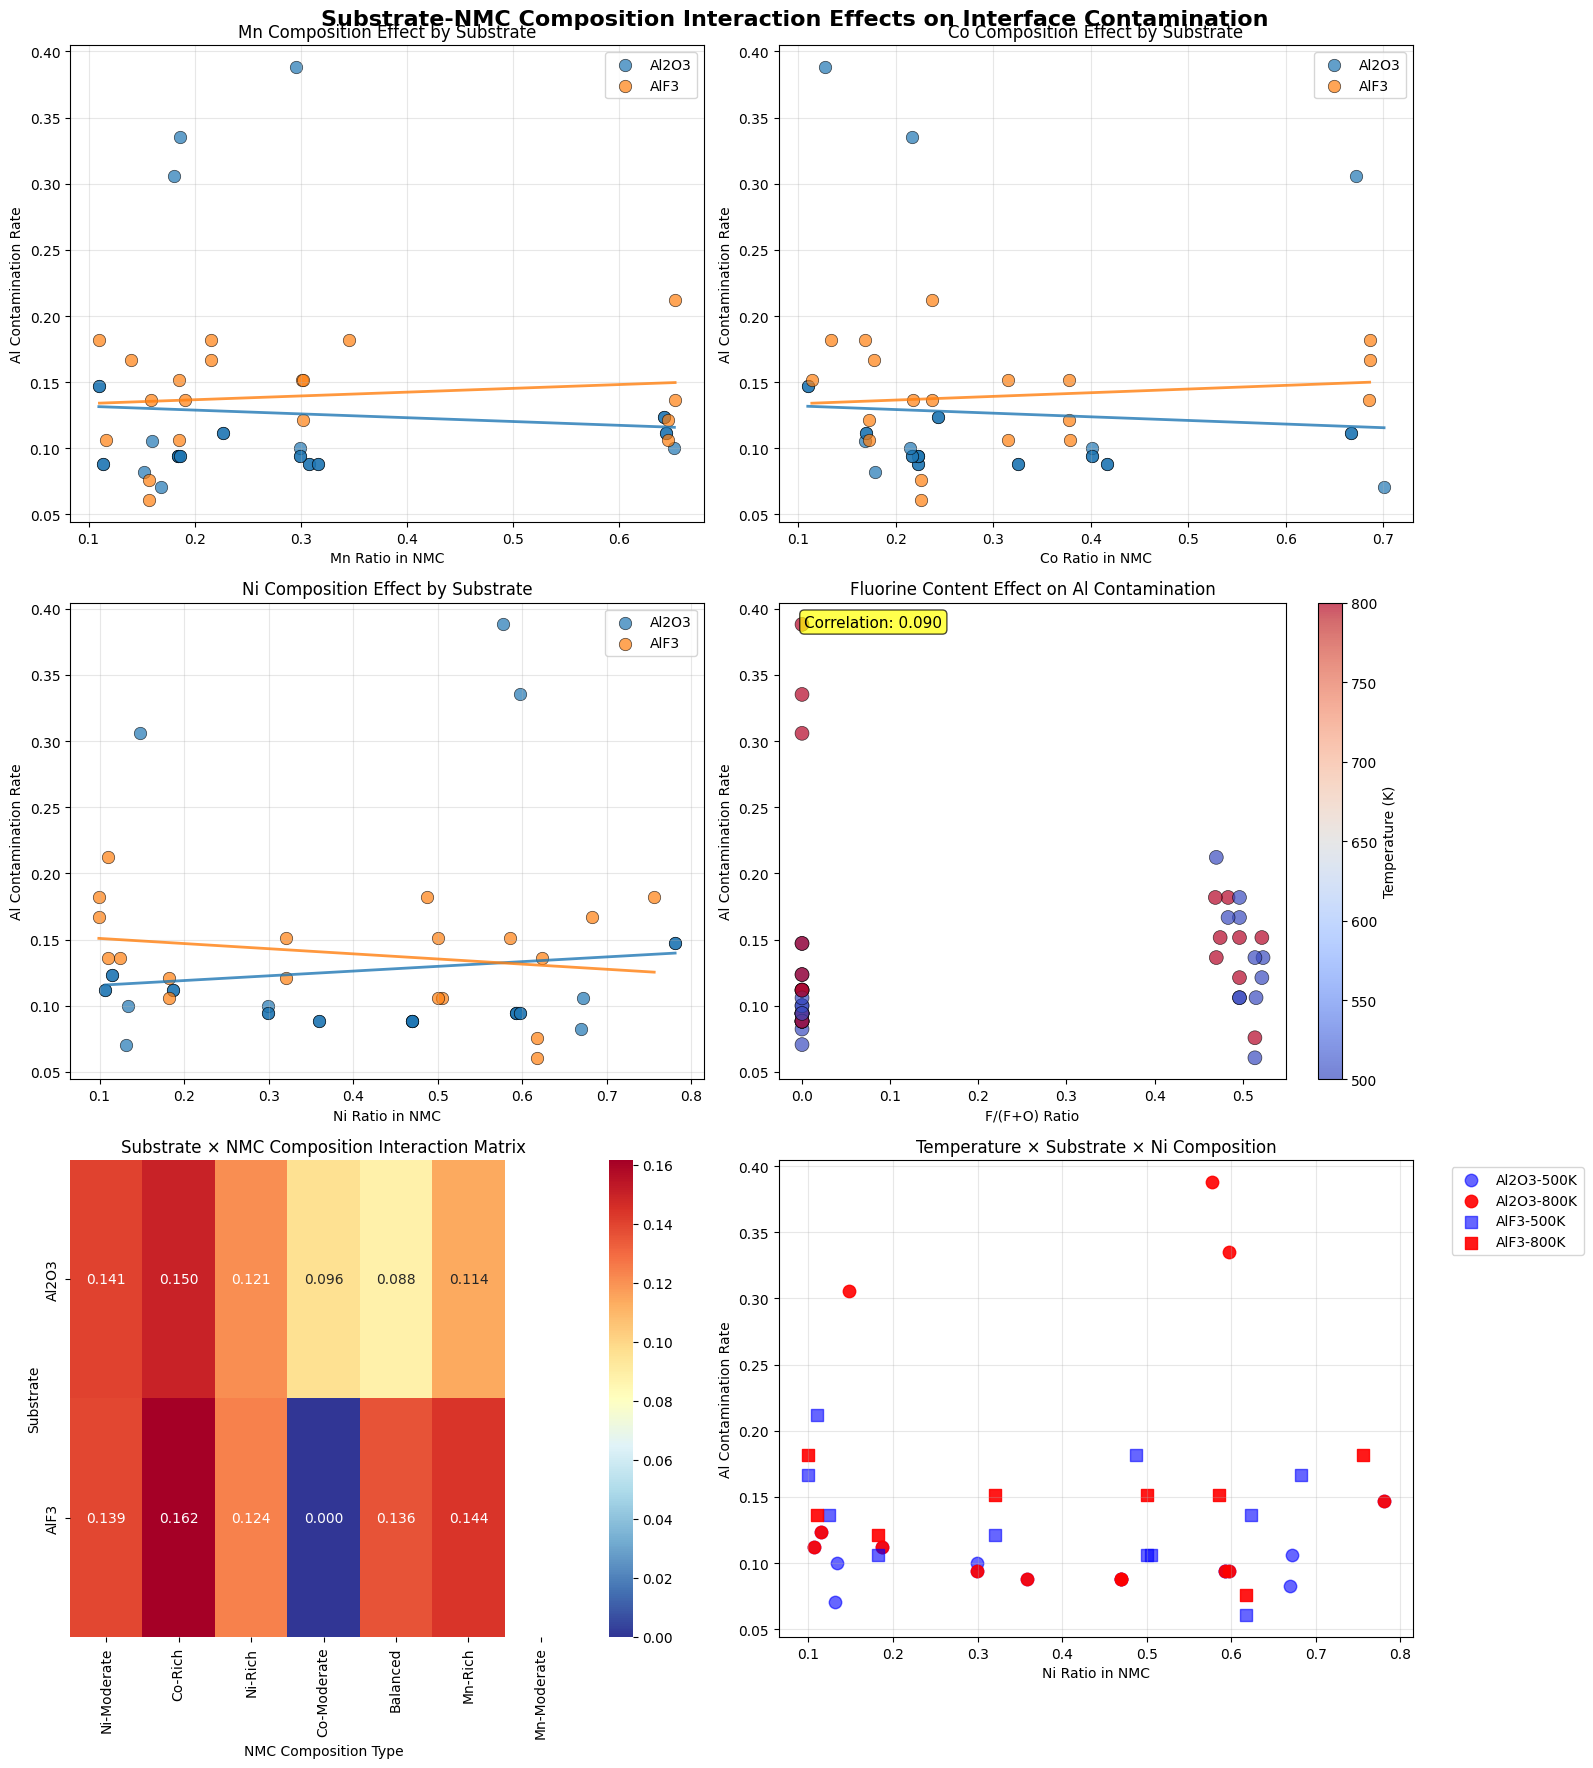

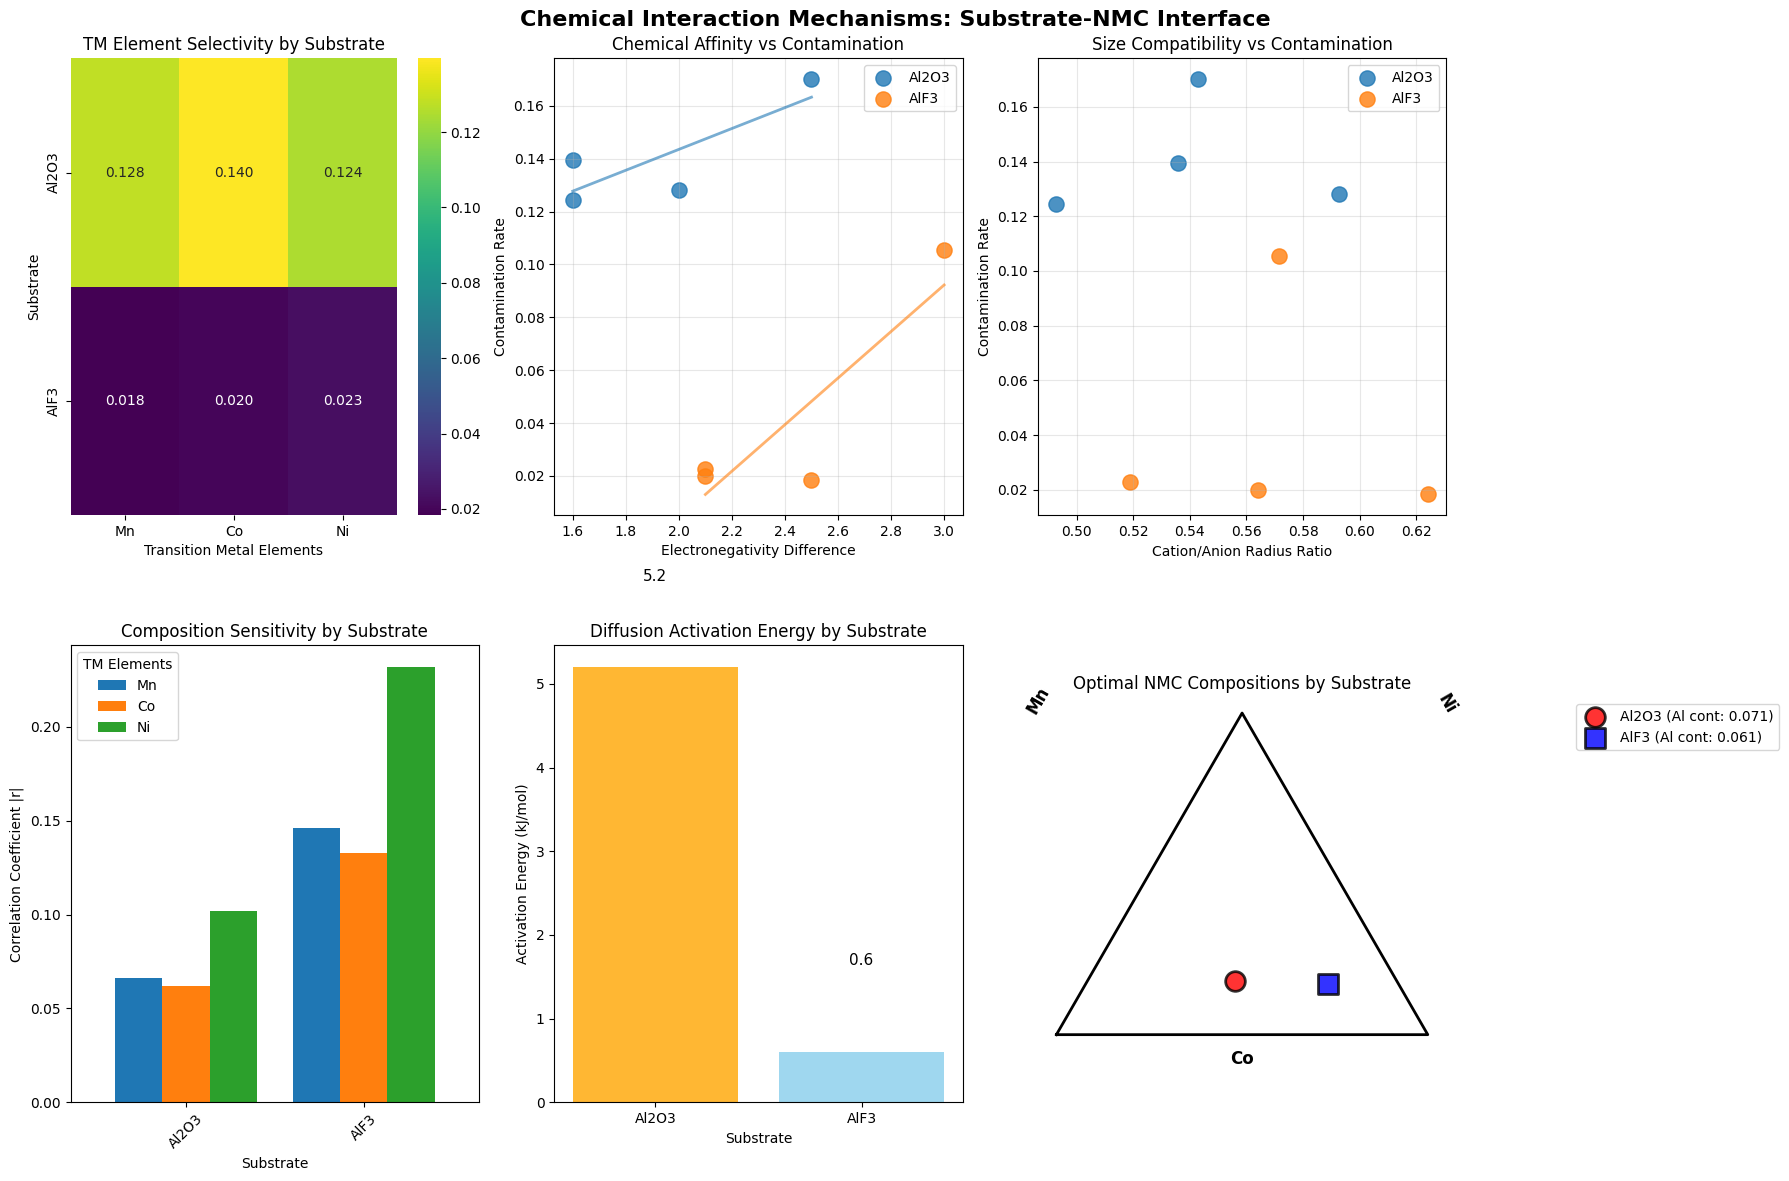


=== 基材-NMC組成相互作用の統計解析結果 ===

1. 基材別NMC組成効果の相関分析:

Al2O3:
  Mn_ratio vs Al_contamination: r = -0.0663
  Co_ratio vs Al_contamination: r = -0.0618
  Ni_ratio vs Al_contamination: r = 0.1021

AlF3:
  Mn_ratio vs Al_contamination: r = 0.1463
  Co_ratio vs Al_contamination: r = 0.1329
  Ni_ratio vs Al_contamination: r = -0.2318

2. フッ素含有量と混入率の相関: r = 0.0902

3. 化学的親和性解析:
電気陰性度差による化学結合親和性:
  Al2O3: 電気陰性度差-混入率相関 r = 0.8141
  AlF3: 電気陰性度差-混入率相関 r = 0.8820

4. イオン半径適合性:
  Al2O3: 半径比-混入率相関 r = 0.0756
  AlF3: 半径比-混入率相関 r = -0.0124

5. 基材別拡散活性化エネルギー:
  Al2O3: 5.20 kJ/mol
  AlF3: 0.60 kJ/mol

6. 各基材での最適条件:

Al2O3:
  最適NMC組成 - Mn: 0.168, Co: 0.701, Ni: 0.131
  ミラー指数: (12)
  温度: 500K
  達成Al混入率: 0.07059

AlF3:
  最適NMC組成 - Mn: 0.157, Co: 0.225, Ni: 0.618
  ミラー指数: (12)
  温度: 500K
  達成Al混入率: 0.06061

7. 基材選択による混入改善効果:
  AlF3がAl2O3より14.1%優れた分離性能


KeyError: 'NMC_total_contamination'

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore', category=np.RankWarning)

# CSVファイルを読み込み
# df = pd.read_csv('comprehensive_analysis_results_4.csv')
df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/scored_results_for_clean_separation.csv')
df['NMC_total_contamination'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])

df['Miller_Index_str'] = df['NMC_miller_index'].apply(lambda x: f"({x:03d})" if x == 1 else f"({x})")

# 基本計算
df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)

# NMC組成比の計算
df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)

# NMC総混入率
# df['NMC_total_contamination'] = (df['Li_contamination_rate'] + df['Mn_contamination_rate'] + 
#                                 df['Co_contamination_rate'] + df['Ni_contamination_rate']) / 4
df['NMC_total_contamination'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])

# フッ素含有量の計算
df['F_ratio_in_anions'] = df['F_total'] / (df['F_total'] + df['O_total'] + 1e-10)

# 安全な回帰線計算関数
def safe_polyfit_plot(ax, x_data, y_data, **kwargs):
    """安全な回帰線プロット関数"""
    try:
        # データの有効性をチェック
        if len(x_data) < 3:
            return False
        if x_data.std() < 1e-8 or y_data.std() < 1e-8:
            return False
        
        # 欠損値を除去
        mask = ~(np.isnan(x_data) | np.isnan(y_data))
        x_clean = x_data[mask]
        y_clean = y_data[mask]
        
        if len(x_clean) < 3:
            return False
            
        # 回帰線を計算
        z = np.polyfit(x_clean, y_clean, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        ax.plot(x_line, p(x_line), **kwargs)
        return True
        
    except (np.linalg.LinAlgError, np.RankWarning, ValueError):
        return False

# 安全な相関係数計算関数
def safe_correlation(x, y):
    """安全な相関係数計算関数"""
    try:
        # 欠損値を除去
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]
        
        if len(x_clean) < 3:
            return 0.0
        if x_clean.std() < 1e-8 or y_clean.std() < 1e-8:
            return 0.0
            
        corr = np.corrcoef(x_clean, y_clean)[0,1]
        return 0.0 if np.isnan(corr) else corr
        
    except:
        return 0.0

print("=== AlF3/Al2O3基材とNMC組成の相互作用解析 ===")

# 図1: 基材別のNMC組成効果
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Substrate-NMC Composition Interaction Effects on Interface Contamination', fontsize=16, fontweight='bold')

# 1-1: 基材別のMn組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[0,0].scatter(subset['Mn_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}', 
                     edgecolors='black', linewidth=0.5)
    
    # 安全な回帰線を追加
    safe_polyfit_plot(axes[0,0], subset['Mn_ratio'].values, subset['Al_contamination_rate'].values, 
                     linewidth=2, alpha=0.8)

axes[0,0].set_xlabel('Mn Ratio in NMC')
axes[0,0].set_ylabel('Al Contamination Rate')
axes[0,0].set_title('Mn Composition Effect by Substrate')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 1-2: 基材別のCo組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[0,1].scatter(subset['Co_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}',
                     edgecolors='black', linewidth=0.5)
    
    safe_polyfit_plot(axes[0,1], subset['Co_ratio'].values, subset['Al_contamination_rate'].values,
                     linewidth=2, alpha=0.8)

axes[0,1].set_xlabel('Co Ratio in NMC')
axes[0,1].set_ylabel('Al Contamination Rate')
axes[0,1].set_title('Co Composition Effect by Substrate')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 1-3: 基材別のNi組成効果
for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    axes[1,0].scatter(subset['Ni_ratio'], subset['Al_contamination_rate'], 
                     alpha=0.7, s=80, label=f'{substrate}',
                     edgecolors='black', linewidth=0.5)
    
    safe_polyfit_plot(axes[1,0], subset['Ni_ratio'].values, subset['Al_contamination_rate'].values,
                     linewidth=2, alpha=0.8)

axes[1,0].set_xlabel('Ni Ratio in NMC')
axes[1,0].set_ylabel('Al Contamination Rate')
axes[1,0].set_title('Ni Composition Effect by Substrate')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 1-4: フッ素比と混入率の関係
scatter = axes[1,1].scatter(df['F_ratio_in_anions'], df['Al_contamination_rate'], 
                           c=df['high_temp_K'], s=100, cmap='coolwarm', alpha=0.7,
                           edgecolors='black', linewidth=0.5)
axes[1,1].set_xlabel('F/(F+O) Ratio')
axes[1,1].set_ylabel('Al Contamination Rate')
axes[1,1].set_title('Fluorine Content Effect on Al Contamination')
plt.colorbar(scatter, ax=axes[1,1], label='Temperature (K)')

# フッ素比と混入率の相関を計算
f_corr = safe_correlation(df['F_ratio_in_anions'].values, df['Al_contamination_rate'].values)
axes[1,1].text(0.05, 0.95, f'Correlation: {f_corr:.3f}', 
              transform=axes[1,1].transAxes, fontsize=11, 
              bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 1-5: 基材×NMC組成の相互作用ヒートマップ
# NMC組成を定性的に分類
def classify_nmc_by_dominant(row):
    elements = {'Mn': row['Mn_ratio'], 'Co': row['Co_ratio'], 'Ni': row['Ni_ratio']}
    dominant = max(elements, key=elements.get)
    
    max_ratio = elements[dominant]
    if max_ratio < 0.4:
        return 'Balanced'
    elif max_ratio > 0.6:
        return f'{dominant}-Rich'
    else:
        return f'{dominant}-Moderate'

df['NMC_composition_class'] = df.apply(classify_nmc_by_dominant, axis=1)

substrates = df['substrate'].unique()
composition_types = df['NMC_composition_class'].unique()
interaction_matrix = np.zeros((len(substrates), len(composition_types)))

for i, substrate in enumerate(substrates):
    for j, comp_type in enumerate(composition_types):
        subset = df[(df['substrate'] == substrate) & (df['NMC_composition_class'] == comp_type)]
        if len(subset) > 0:
            interaction_matrix[i, j] = subset['Al_contamination_rate'].mean()

sns.heatmap(interaction_matrix, 
           xticklabels=composition_types,
           yticklabels=substrates,
           annot=True, fmt='.3f', cmap='RdYlBu_r',
           ax=axes[2,0])
axes[2,0].set_title('Substrate × NMC Composition Interaction Matrix')
axes[2,0].set_xlabel('NMC Composition Type')
axes[2,0].set_ylabel('Substrate')

# 1-6: 基材別の温度×組成相互作用
ax = axes[2,1]

for substrate in df['substrate'].unique():
    subset = df[df['substrate'] == substrate]
    
    temps = subset['high_temp_K'].unique()
    colors = ['blue', 'red'] if len(temps) == 2 else ['blue']
    
    for temp, color in zip(temps, colors):
        temp_subset = subset[subset['high_temp_K'] == temp]
        alpha_val = 0.6 if temp == min(temps) else 0.9
        marker = 'o' if substrate == 'Al2O3' else 's'
        
        ax.scatter(temp_subset['Ni_ratio'], temp_subset['Al_contamination_rate'],
                  c=color, alpha=alpha_val, s=80, marker=marker,
                  label=f'{substrate}-{int(temp)}K')

ax.set_xlabel('Ni Ratio in NMC')
ax.set_ylabel('Al Contamination Rate')
ax.set_title('Temperature × Substrate × Ni Composition')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot6.png'
plt.savefig(fig_path2, dpi=300)
plt.show()

# 図2: 化学的相互作用メカニズムの解析
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Chemical Interaction Mechanisms: Substrate-NMC Interface', fontsize=16, fontweight='bold')

# 2-1: 基材別の遷移金属選択性
selectivity_matrix = np.zeros((len(substrates), 3))
tm_elements = ['Mn', 'Co', 'Ni']

for i, substrate in enumerate(substrates):
    subset = df[df['substrate'] == substrate]
    for j, element in enumerate(tm_elements):
        contamination_col = f'{element}_contamination_rate'
        selectivity_matrix[i, j] = subset[contamination_col].mean()

sns.heatmap(selectivity_matrix,
           xticklabels=tm_elements,
           yticklabels=substrates,
           annot=True, fmt='.3f', cmap='viridis',
           ax=axes[0,0])
axes[0,0].set_title('TM Element Selectivity by Substrate')
axes[0,0].set_xlabel('Transition Metal Elements')
axes[0,0].set_ylabel('Substrate')

# 2-2: 化学結合親和性の評価
electronegativity = {'F': 4.0, 'O': 3.5, 'Li': 1.0, 'Mn': 1.5, 'Co': 1.9, 'Ni': 1.9, 'Al': 1.6}

affinity_data = []
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if substrate == 'AlF3':
        anion_en = electronegativity['F']
    else:  # Al2O3
        anion_en = electronegativity['O']
    
    for element in ['Li', 'Mn', 'Co', 'Ni']:
        cation_en = electronegativity[element]
        en_diff = abs(anion_en - cation_en)
        contamination = subset[f'{element}_contamination_rate'].mean()
        
        affinity_data.append({
            'substrate': substrate,
            'element': element,
            'en_difference': en_diff,
            'contamination': contamination
        })

affinity_df = pd.DataFrame(affinity_data)

# 電気陰性度差と混入率の関係
for substrate in substrates:
    subset = affinity_df[affinity_df['substrate'] == substrate]
    axes[0,1].scatter(subset['en_difference'], subset['contamination'],
                     s=120, alpha=0.8, label=substrate)
    
    # 安全な回帰線
    safe_polyfit_plot(axes[0,1], subset['en_difference'].values, subset['contamination'].values,
                     linewidth=2, alpha=0.6)

axes[0,1].set_xlabel('Electronegativity Difference')
axes[0,1].set_ylabel('Contamination Rate')
axes[0,1].set_title('Chemical Affinity vs Contamination')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 2-3: イオン半径適合性の評価
ionic_radii = {'Li': 0.76, 'Mn': 0.83, 'Co': 0.75, 'Ni': 0.69, 'Al': 0.54, 'F': 1.33, 'O': 1.40}

size_compatibility = []
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if substrate == 'AlF3':
        anion_radius = ionic_radii['F']
    else:  # Al2O3
        anion_radius = ionic_radii['O']
    
    for element in ['Li', 'Mn', 'Co', 'Ni']:
        cation_radius = ionic_radii[element]
        radius_ratio = cation_radius / anion_radius
        contamination = subset[f'{element}_contamination_rate'].mean()
        
        size_compatibility.append({
            'substrate': substrate,
            'element': element,
            'radius_ratio': radius_ratio,
            'contamination': contamination
        })

size_df = pd.DataFrame(size_compatibility)

for substrate in substrates:
    subset = size_df[size_df['substrate'] == substrate]
    axes[0,2].scatter(subset['radius_ratio'], subset['contamination'],
                     s=120, alpha=0.8, label=substrate)

axes[0,2].set_xlabel('Cation/Anion Radius Ratio')
axes[0,2].set_ylabel('Contamination Rate')
axes[0,2].set_title('Size Compatibility vs Contamination')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 2-4: 基材別の組成感受性指数
sensitivity_data = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if len(subset) > 3:
        # 各遷移金属比と Al混入率の相関
        mn_sens = abs(safe_correlation(subset['Mn_ratio'].values, subset['Al_contamination_rate'].values))
        co_sens = abs(safe_correlation(subset['Co_ratio'].values, subset['Al_contamination_rate'].values))
        ni_sens = abs(safe_correlation(subset['Ni_ratio'].values, subset['Al_contamination_rate'].values))
        
        sensitivity_data[substrate] = {'Mn': mn_sens, 'Co': co_sens, 'Ni': ni_sens}

if sensitivity_data:
    sens_df = pd.DataFrame(sensitivity_data).T
    sens_df.plot(kind='bar', ax=axes[1,0], width=0.8)
    axes[1,0].set_title('Composition Sensitivity by Substrate')
    axes[1,0].set_xlabel('Substrate')
    axes[1,0].set_ylabel('Correlation Coefficient |r|')
    axes[1,0].legend(title='TM Elements')
    axes[1,0].tick_params(axis='x', rotation=45)

# 2-5: 基材による拡散活性化エネルギーの違い
activation_energies = {}
for substrate in substrates:
    substrate_data = df[df['substrate'] == substrate]
    temps = sorted(substrate_data['high_temp_K'].unique())
    
    if len(temps) >= 2:
        T1, T2 = temps[0], temps[-1]
        rate1 = substrate_data[substrate_data['high_temp_K'] == T1]['Al_contamination_rate'].mean()
        rate2 = substrate_data[substrate_data['high_temp_K'] == T2]['Al_contamination_rate'].mean()
        
        if rate1 > 1e-10 and rate2 > 1e-10 and not np.isnan(rate1) and not np.isnan(rate2):
            R = 8.314  # J/(mol·K)
            try:
                ea = -R * np.log(rate2/rate1) / (1/T2 - 1/T1) / 1000  # kJ/mol
                if not np.isnan(ea) and not np.isinf(ea):
                    activation_energies[substrate] = ea
            except:
                pass

if activation_energies:
    substrates_ea = list(activation_energies.keys())
    energies = list(activation_energies.values())
    
    bars = axes[1,1].bar(substrates_ea, energies, alpha=0.8, 
                        color=['orange', 'skyblue'][:len(substrates_ea)])
    axes[1,1].set_xlabel('Substrate')
    axes[1,1].set_ylabel('Activation Energy (kJ/mol)')
    axes[1,1].set_title('Diffusion Activation Energy by Substrate')
    
    for bar, energy in zip(bars, energies):
        axes[1,1].text(bar.get_x() + bar.get_width()/2., energy + 1,
                      f'{energy:.1f}', ha='center', va='bottom', fontsize=11)

# 2-6: 基材別の最適NMC組成
optimal_compositions = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    
    if len(subset) > 0:
        min_idx = subset['Al_contamination_rate'].idxmin()
        optimal_condition = subset.loc[min_idx]
        
        optimal_compositions[substrate] = {
            'Mn_ratio': optimal_condition['Mn_ratio'],
            'Co_ratio': optimal_condition['Co_ratio'],
            'Ni_ratio': optimal_condition['Ni_ratio'],
            'Al_contamination': optimal_condition['Al_contamination_rate'],
            'temperature': optimal_condition['high_temp_K'],
            'miller_index': optimal_condition['Miller_Index_str']
        }

# 最適組成の比較を三角座標で表示
ax = axes[1,2]
colors = ['red', 'blue']
markers = ['o', 's']

for i, substrate in enumerate(substrates):
    if substrate in optimal_compositions:
        opt = optimal_compositions[substrate]
        
        # 三角座標への変換
        total = opt['Mn_ratio'] + opt['Co_ratio'] + opt['Ni_ratio']
        if total > 0:
            x = 0.5 * (opt['Co_ratio'] + 2 * opt['Ni_ratio']) / total
            y = np.sqrt(3)/2 * opt['Mn_ratio'] / total
            
            ax.scatter(x, y, s=200, c=colors[i], marker=markers[i], 
                      alpha=0.8, edgecolors='black', linewidth=2,
                      label=f'{substrate} (Al cont: {opt["Al_contamination"]:.3f})')

# 三角形の枠
triangle_x = [0, 1, 0.5, 0]
triangle_y = [0, 0, np.sqrt(3)/2, 0]
ax.plot(triangle_x, triangle_y, 'k-', linewidth=2)

ax.text(0.5, -0.08, 'Co', fontsize=12, ha='center', fontweight='bold')
ax.text(-0.05, np.sqrt(3)/2, 'Mn', fontsize=12, ha='center', fontweight='bold', rotation=60)
ax.text(1.05, np.sqrt(3)/2, 'Ni', fontsize=12, ha='center', fontweight='bold', rotation=-60)
ax.set_title('Optimal NMC Compositions by Substrate')
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper left')

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot7.png'
plt.savefig(fig_path2, dpi=300)
plt.show()

# 統計解析結果
print("\n=== 基材-NMC組成相互作用の統計解析結果 ===")

print("\n1. 基材別NMC組成効果の相関分析:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['Al_contamination_rate'].values)
            print(f"  {element}_ratio vs Al_contamination: r = {corr:.4f}")

print(f"\n2. フッ素含有量と混入率の相関: r = {f_corr:.4f}")

print("\n3. 化学的親和性解析:")
print("電気陰性度差による化学結合親和性:")
for substrate in substrates:
    subset = affinity_df[affinity_df['substrate'] == substrate]
    if len(subset) > 2:
        corr = safe_correlation(subset['en_difference'].values, subset['contamination'].values)
        print(f"  {substrate}: 電気陰性度差-混入率相関 r = {corr:.4f}")

print("\n4. イオン半径適合性:")
for substrate in substrates:
    subset = size_df[size_df['substrate'] == substrate]
    if len(subset) > 2:
        corr = safe_correlation(subset['radius_ratio'].values, subset['contamination'].values)
        print(f"  {substrate}: 半径比-混入率相関 r = {corr:.4f}")

if activation_energies:
    print("\n5. 基材別拡散活性化エネルギー:")
    for substrate, ea in activation_energies.items():
        print(f"  {substrate}: {ea:.2f} kJ/mol")

print("\n6. 各基材での最適条件:")
for substrate, opt in optimal_compositions.items():
    print(f"\n{substrate}:")
    print(f"  最適NMC組成 - Mn: {opt['Mn_ratio']:.3f}, Co: {opt['Co_ratio']:.3f}, Ni: {opt['Ni_ratio']:.3f}")
    print(f"  ミラー指数: {opt['miller_index']}")
    print(f"  温度: {opt['temperature']}K")
    print(f"  達成Al混入率: {opt['Al_contamination']:.5f}")

print("\n7. 基材選択による混入改善効果:")
if len(optimal_compositions) == 2:
    substrates_list = list(optimal_compositions.keys())
    contaminations = [optimal_compositions[sub]['Al_contamination'] for sub in substrates_list]
    
    better_idx = np.argmin(contaminations)
    worse_idx = 1 - better_idx
    
    better_substrate = substrates_list[better_idx]
    worse_substrate = substrates_list[worse_idx]
    improvement = (contaminations[worse_idx] - contaminations[better_idx]) / contaminations[worse_idx] * 100
    
    print(f"  {better_substrate}が{worse_substrate}より{improvement:.1f}%優れた分離性能")

if len(optimal_compositions) == 2:
    substrates_list = list(optimal_compositions.keys())
    contaminations = [optimal_compositions[sub]['NMC_total_contamination'] for sub in substrates_list]
    
    better_idx = np.argmin(contaminations)
    worse_idx = 1 - better_idx
    
    better_substrate = substrates_list[better_idx]
    worse_substrate = substrates_list[worse_idx]
    improvement = (contaminations[worse_idx] - contaminations[better_idx]) / contaminations[worse_idx] * 100
    
    print(f"  {better_substrate}が{worse_substrate}より{improvement:.1f}%NMCの混入において優れた分離性能")
print("\n8. 実用的な設計指針:")
print("  a) 基材選択: 化学的親和性の低い基材が有利")
print("  b) NMC組成最適化: 基材種類に応じた遷移金属比率の調整")
print("  c) 温度制御: 基材固有の活性化エネルギーを考慮した熱処理")
print("  d) 界面工学: アニオン種（F⁻/O²⁻）とカチオン適合性の制御")

In [21]:
# import pandas as pd
# import numpy as np

# # CSVファイルを読み込み（既存データを想定）
# df = pd.read_csv('comprehensive_analysis_results_4.csv')

# # 基本計算
# df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
# df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
# df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
# df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
# df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)

# # NMC組成比の計算
# df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
# df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
# df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
# df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)

# # NMC総混入率
# df['NMC_total_contamination'] = (df['Li_contamination_rate'] + df['Mn_contamination_rate'] + 
#                                 df['Co_contamination_rate'] + df['Ni_contamination_rate']) / 4

# 安全な相関係数計算関数
def safe_correlation(x, y):
    """安全な相関係数計算関数"""
    try:
        # 欠損値を除去
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]
        
        if len(x_clean) < 3:
            return 0.0
        if x_clean.std() < 1e-8 or y_clean.std() < 1e-8:
            return 0.0
            
        corr = np.corrcoef(x_clean, y_clean)[0,1]
        return 0.0 if np.isnan(corr) else corr
        
    except:
        return 0.0

print("=== 拡張版：基材別NMC組成効果の相関分析 ===")

# 基材のリスト
substrates = df['substrate'].unique()

print("\n1. 基材別Al混入率との相関:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate} (サンプル数: {len(subset)}):")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['Al_contamination_rate'].values)
            print(f"  {element}_ratio vs Al_contamination: r = {corr:+.4f}")

print("\n2. 基材別NMC総混入率との相関:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate} (サンプル数: {len(subset)}):")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['NMC_total_contamination'].values)
            print(f"  {element}_ratio vs NMC_total_contamination: r = {corr:+.4f}")

print("\n3. 基材別個別NMC成分混入率との相関:")

# Li混入率との相関
print("\n3-1. Li混入率との相関:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['Li_contamination_rate'].values)
            print(f"  {element}_ratio vs Li_contamination: r = {corr:+.4f}")

# Mn混入率との相関
print("\n3-2. Mn混入率との相関:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['Mn_contamination_rate'].values)
            print(f"  {element}_ratio vs Mn_contamination: r = {corr:+.4f}")

# Co混入率との相関
print("\n3-3. Co混入率との相関:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['Co_contamination_rate'].values)
            print(f"  {element}_ratio vs Co_contamination: r = {corr:+.4f}")

# Ni混入率との相関
print("\n3-4. Ni混入率との相関:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        for element in ['Mn', 'Co', 'Ni']:
            ratio_col = f'{element}_ratio'
            corr = safe_correlation(subset[ratio_col].values, subset['Ni_contamination_rate'].values)
            print(f"  {element}_ratio vs Ni_contamination: r = {corr:+.4f}")

# 相関マトリックス形式での表示
print("\n4. 相関マトリックス形式まとめ:")
correlation_results = {}

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        correlation_results[substrate] = {}
        
        # 各組成比と各混入率の相関を計算
        composition_ratios = ['Mn_ratio', 'Co_ratio', 'Ni_ratio']
        contamination_rates = ['Al_contamination_rate', 'NMC_total_contamination', 
                             'Li_contamination_rate', 'Mn_contamination_rate', 
                             'Co_contamination_rate', 'Ni_contamination_rate']
        
        for comp_ratio in composition_ratios:
            correlation_results[substrate][comp_ratio] = {}
            for contam_rate in contamination_rates:
                corr = safe_correlation(subset[comp_ratio].values, subset[contam_rate].values)
                correlation_results[substrate][comp_ratio][contam_rate] = corr

# 相関マトリックスをDataFrameで表示
for substrate in correlation_results.keys():
    print(f"\n{substrate} 相関マトリックス:")
    print("=" * 80)
    
    # ヘッダー行
    header = f"{'組成比':<12}"
    for contam_rate in ['Al_cont', 'NMC_total', 'Li_cont', 'Mn_cont', 'Co_cont', 'Ni_cont']:
        header += f"{contam_rate:>10}"
    print(header)
    print("-" * 80)
    
    # データ行
    contamination_rates = ['Al_contamination_rate', 'NMC_total_contamination', 
                         'Li_contamination_rate', 'Mn_contamination_rate', 
                         'Co_contamination_rate', 'Ni_contamination_rate']
    
    for comp_ratio in ['Mn_ratio', 'Co_ratio', 'Ni_ratio']:
        element = comp_ratio.split('_')[0]
        row = f"{element}_ratio  "
        for contam_rate in contamination_rates:
            corr = correlation_results[substrate][comp_ratio][contam_rate]
            row += f"{corr:+9.3f} "
        print(row)

print("\n5. 特に強い相関（|r| > 0.5）の抽出:")
strong_correlations = []

for substrate in correlation_results.keys():
    for comp_ratio in correlation_results[substrate].keys():
        for contam_rate in correlation_results[substrate][comp_ratio].keys():
            corr = correlation_results[substrate][comp_ratio][contam_rate]
            if abs(corr) > 0.5:
                strong_correlations.append({
                    'substrate': substrate,
                    'composition': comp_ratio.replace('_ratio', ''),
                    'contamination': contam_rate.replace('_contamination_rate', '').replace('_rate', ''),
                    'correlation': corr
                })

if strong_correlations:
    print(f"\n強い相関を示す組み合わせ（{len(strong_correlations)}個）:")
    for item in sorted(strong_correlations, key=lambda x: abs(x['correlation']), reverse=True):
        print(f"  {item['substrate']}: {item['composition']}_ratio → {item['contamination']}_contamination: r = {item['correlation']:+.3f}")
else:
    print("\n強い相関（|r| > 0.5）を示す組み合わせはありませんでした。")

print("\n6. 自己拡散 vs 相互拡散の比較:")
print("（組成比と同じ元素の混入率：自己拡散、異なる元素：相互拡散）")

for substrate in correlation_results.keys():
    print(f"\n{substrate}:")
    
    # 自己拡散相関
    self_correlations = []
    for element in ['Mn', 'Co', 'Ni']:
        comp_ratio = f'{element}_ratio'
        contam_rate = f'{element}_contamination_rate'
        corr = correlation_results[substrate][comp_ratio][contam_rate]
        self_correlations.append(corr)
        print(f"  自己拡散 - {element}: r = {corr:+.3f}")
    
    # 相互拡散相関の平均
    cross_correlations = []
    elements = ['Mn', 'Co', 'Ni']
    for i, element1 in enumerate(elements):
        for j, element2 in enumerate(elements):
            if i != j:  # 異なる元素
                comp_ratio = f'{element1}_ratio'
                contam_rate = f'{element2}_contamination_rate'
                corr = correlation_results[substrate][comp_ratio][contam_rate]
                cross_correlations.append(corr)
    
    avg_self = np.mean(self_correlations)
    avg_cross = np.mean(cross_correlations)
    
    print(f"  自己拡散平均: {avg_self:+.3f}")
    print(f"  相互拡散平均: {avg_cross:+.3f}")
    print(f"  自己拡散優位度: {avg_self - avg_cross:+.3f}")

print("\n=== 分析完了 ===")

=== 拡張版：基材別NMC組成効果の相関分析 ===

1. 基材別Al混入率との相関:

Al2O3 (サンプル数: 29):
  Mn_ratio vs Al_contamination: r = -0.0854
  Co_ratio vs Al_contamination: r = -0.0856
  Ni_ratio vs Al_contamination: r = +0.1329

AlF3 (サンプル数: 31):
  Mn_ratio vs Al_contamination: r = -0.3275
  Co_ratio vs Al_contamination: r = +0.1705
  Ni_ratio vs Al_contamination: r = +0.1184

2. 基材別NMC総混入率との相関:

Al2O3 (サンプル数: 29):
  Mn_ratio vs NMC_total_contamination: r = -0.0228
  Co_ratio vs NMC_total_contamination: r = -0.1040
  Ni_ratio vs NMC_total_contamination: r = +0.0948

AlF3 (サンプル数: 31):
  Mn_ratio vs NMC_total_contamination: r = -0.2818
  Co_ratio vs NMC_total_contamination: r = +0.0444
  Ni_ratio vs NMC_total_contamination: r = +0.1857

3. 基材別個別NMC成分混入率との相関:

3-1. Li混入率との相関:

Al2O3:
  Mn_ratio vs Li_contamination: r = -0.0597
  Co_ratio vs Li_contamination: r = +0.0152
  Ni_ratio vs Li_contamination: r = +0.0381

AlF3:
  Mn_ratio vs Li_contamination: r = -0.3686
  Co_ratio vs Li_contamination: r = +0.0908
  Ni_ratio 

=== Al基材・NMC組成による分離性能の包括的分析 ===


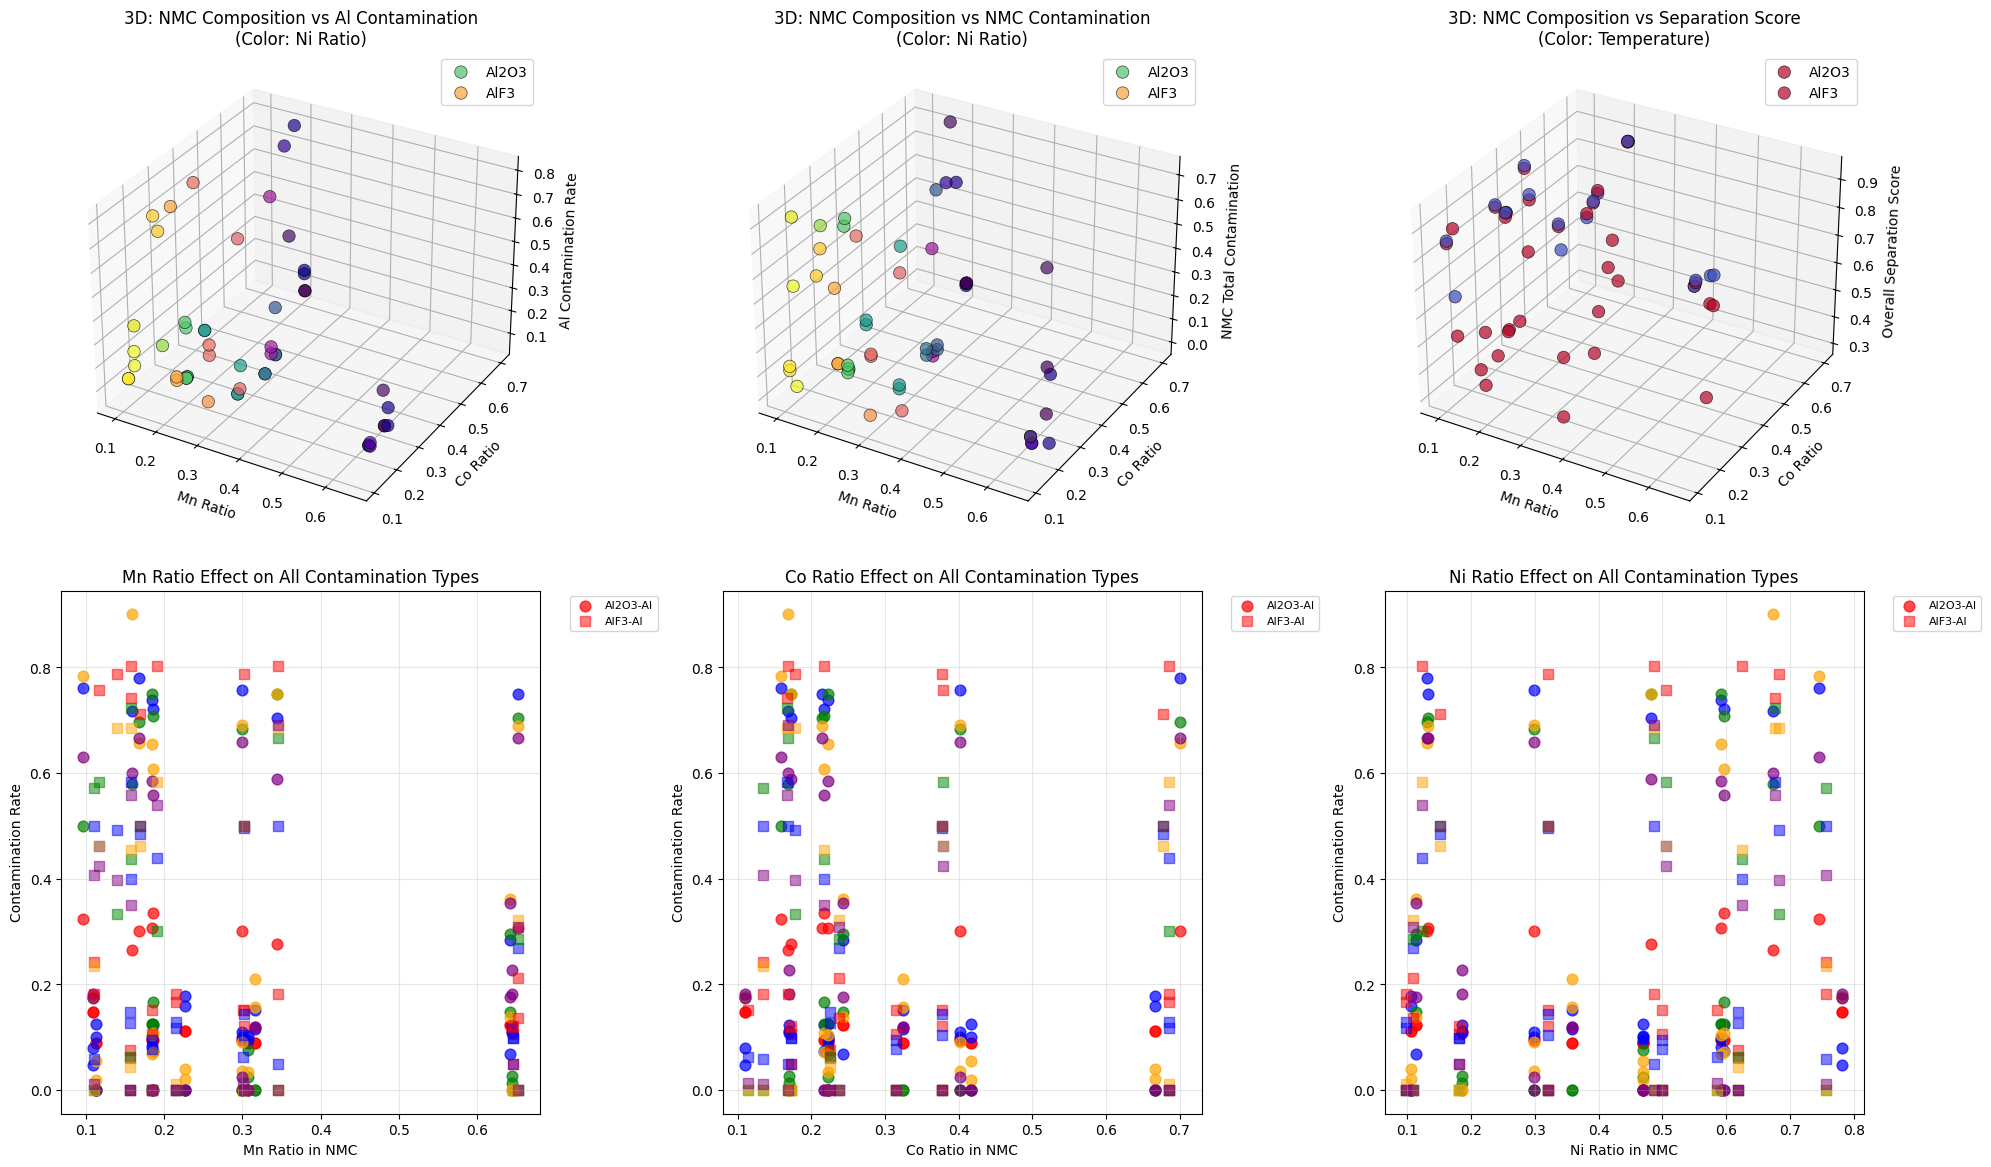

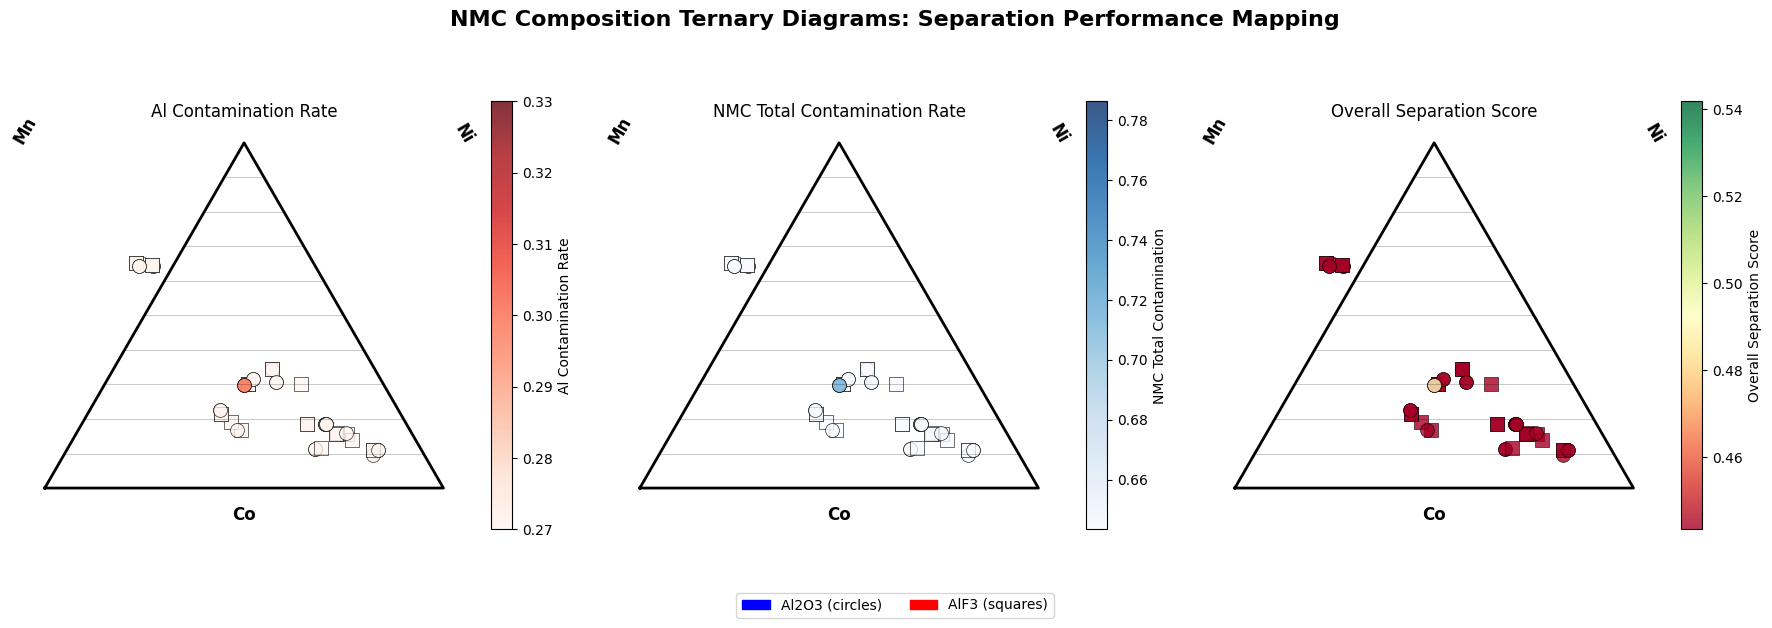

/tmp/ipykernel_98663/4253865120.py:281: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)
/tmp/ipykernel_98663/4253865120.py:281: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)
/tmp/ipykernel_98663/4253865120.py:281: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)


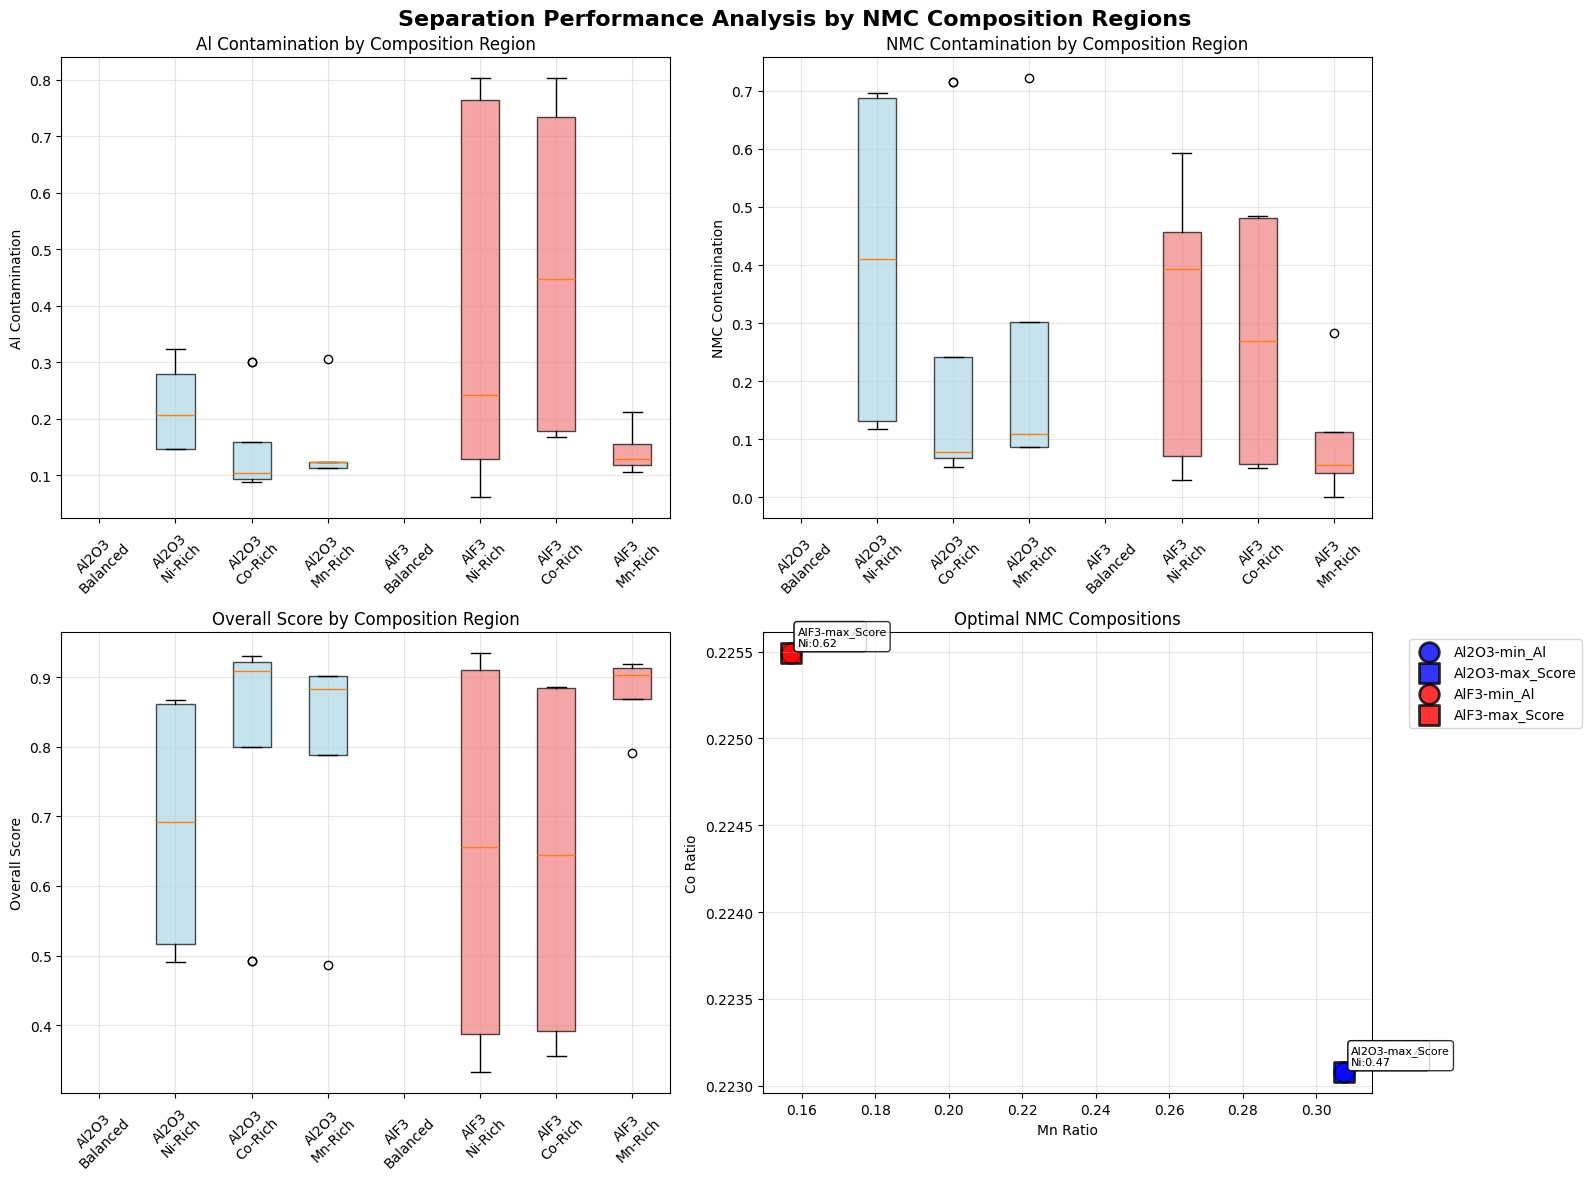


=== NMC組成による分離性能分析結果 ===

1. 組成領域別平均性能:

Al2O3:
  Balanced: Al混入=0.1497, NMC混入=0.2415, 総合スコア=0.8044
  Ni-Rich: Al混入=0.2206, NMC混入=0.4087, 総合スコア=0.6854
  Co-Rich: Al混入=0.1485, NMC混入=0.2313, 総合スコア=0.8101
  Mn-Rich: Al混入=0.1553, NMC混入=0.2610, 総合スコア=0.7919

AlF3:
  Balanced: Al混入=0.3569, NMC混入=0.2011, 総合スコア=0.7210
  Ni-Rich: Al混入=0.4134, NMC混入=0.2959, 総合スコア=0.6454
  Co-Rich: Al混入=0.4659, NMC混入=0.2689, 総合スコア=0.6326
  Mn-Rich: Al混入=0.1439, NMC混入=0.0988, 総合スコア=0.8786

2. 各基材での最適条件:

Al2O3:
  Al混入最小条件:
    組成: Mn=0.308, Co=0.223, Ni=0.469
    Al混入率: 0.08824
    温度: 500K
  総合スコア最大条件:
    組成: Mn=0.308, Co=0.223, Ni=0.469
    総合スコア: 0.93159
    温度: 500K

AlF3:
  Al混入最小条件:
    組成: Mn=0.157, Co=0.225, Ni=0.618
    Al混入率: 0.06061
    温度: 500K
  総合スコア最大条件:
    組成: Mn=0.157, Co=0.225, Ni=0.618
    総合スコア: 0.93416
    温度: 500K

3. NMC組成の分離性能への影響度:

Al2O3:
  Al混入への影響: Mn r=+nan, Co r=+nan, Ni r=+nan
  NMC混入への影響: Mn r=+nan, Co r=+nan, Ni r=+nan

AlF3:
  Al混入への影響: Mn r=+nan, Co r=+nan, Ni r=+nan
  NMC混入への

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# 分離性能スコア（混入率が低いほど高スコア）
df['Al_separation_score'] = 1 - df['Al_contamination_rate']
df['NMC_separation_score'] = 1 - df['NMC_total_contamination']
df['overall_separation_score'] = (df['Al_separation_score'] + df['NMC_separation_score']) / 2

# Al基材の組成比計算（AlF3 vs Al2O3の区別）
df['F_ratio_in_substrate'] = df['F_total'] / (df['Al_total'] + df['F_total'] + df['O_total'] + 1e-10)
df['O_ratio_in_substrate'] = df['O_total'] / (df['Al_total'] + df['F_total'] + df['O_total'] + 1e-10)

print("=== Al基材・NMC組成による分離性能の包括的分析 ===")

# 基材のリスト
substrates = df['substrate'].unique()

# 図1: NMC組成による分離性能の3D可視化
fig = plt.figure(figsize=(20, 12))

# 1-1: Al混入に対するNMC組成効果（3D）
ax1 = fig.add_subplot(2, 3, 1, projection='3d')

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        scatter = ax1.scatter(subset['Mn_ratio'], subset['Co_ratio'], subset['Al_contamination_rate'],
                             c=subset['Ni_ratio'], s=80, alpha=0.7, 
                             cmap='viridis' if substrate == 'Al2O3' else 'plasma',
                             label=substrate, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('Mn Ratio')
ax1.set_ylabel('Co Ratio')
ax1.set_zlabel('Al Contamination Rate')
ax1.set_title('3D: NMC Composition vs Al Contamination\n(Color: Ni Ratio)')
ax1.legend()

# 1-2: NMC混入に対するNMC組成効果（3D）
ax2 = fig.add_subplot(2, 3, 2, projection='3d')

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        scatter = ax2.scatter(subset['Mn_ratio'], subset['Co_ratio'], subset['NMC_total_contamination'],
                             c=subset['Ni_ratio'], s=80, alpha=0.7,
                             cmap='viridis' if substrate == 'Al2O3' else 'plasma',
                             label=substrate, edgecolors='black', linewidth=0.5)

ax2.set_xlabel('Mn Ratio')
ax2.set_ylabel('Co Ratio')
ax2.set_zlabel('NMC Total Contamination')
ax2.set_title('3D: NMC Composition vs NMC Contamination\n(Color: Ni Ratio)')
ax2.legend()

# 1-3: 総合分離スコア（3D）
ax3 = fig.add_subplot(2, 3, 3, projection='3d')

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        scatter = ax3.scatter(subset['Mn_ratio'], subset['Co_ratio'], subset['overall_separation_score'],
                             c=subset['high_temp_K'], s=80, alpha=0.7,
                             cmap='coolwarm', label=substrate, edgecolors='black', linewidth=0.5)

ax3.set_xlabel('Mn Ratio')
ax3.set_ylabel('Co Ratio')
ax3.set_zlabel('Overall Separation Score')
ax3.set_title('3D: NMC Composition vs Separation Score\n(Color: Temperature)')
ax3.legend()

# 1-4: Mn比 vs 各種混入率
ax4 = fig.add_subplot(2, 3, 4)

contamination_types = ['Al_contamination_rate', 'Li_contamination_rate', 
                      'Mn_contamination_rate', 'Co_contamination_rate', 'Ni_contamination_rate']
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['Al', 'Li', 'Mn', 'Co', 'Ni']

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        for i, (cont_type, color, label) in enumerate(zip(contamination_types, colors, labels)):
            marker = 'o' if substrate == 'Al2O3' else 's'
            alpha = 0.7 if substrate == 'Al2O3' else 0.5
            ax4.scatter(subset['Mn_ratio'], subset[cont_type], 
                       c=color, marker=marker, alpha=alpha, s=60,
                       label=f'{substrate}-{label}' if i == 0 else "")

ax4.set_xlabel('Mn Ratio in NMC')
ax4.set_ylabel('Contamination Rate')
ax4.set_title('Mn Ratio Effect on All Contamination Types')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax4.grid(True, alpha=0.3)

# 1-5: Co比 vs 各種混入率
ax5 = fig.add_subplot(2, 3, 5)

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        for i, (cont_type, color, label) in enumerate(zip(contamination_types, colors, labels)):
            marker = 'o' if substrate == 'Al2O3' else 's'
            alpha = 0.7 if substrate == 'Al2O3' else 0.5
            ax5.scatter(subset['Co_ratio'], subset[cont_type], 
                       c=color, marker=marker, alpha=alpha, s=60,
                       label=f'{substrate}-{label}' if i == 0 else "")

ax5.set_xlabel('Co Ratio in NMC')
ax5.set_ylabel('Contamination Rate')
ax5.set_title('Co Ratio Effect on All Contamination Types')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax5.grid(True, alpha=0.3)

# 1-6: Ni比 vs 各種混入率
ax6 = fig.add_subplot(2, 3, 6)

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        for i, (cont_type, color, label) in enumerate(zip(contamination_types, colors, labels)):
            marker = 'o' if substrate == 'Al2O3' else 's'
            alpha = 0.7 if substrate == 'Al2O3' else 0.5
            ax6.scatter(subset['Ni_ratio'], subset[cont_type], 
                       c=color, marker=marker, alpha=alpha, s=60,
                       label=f'{substrate}-{label}' if i == 0 else "")

ax6.set_xlabel('Ni Ratio in NMC')
ax6.set_ylabel('Contamination Rate')
ax6.set_title('Ni Ratio Effect on All Contamination Types')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot8.png'
plt.savefig(fig_path2, dpi=300)
plt.show()

# 図2: NMC組成三角図での分離性能マッピング
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('NMC Composition Ternary Diagrams: Separation Performance Mapping', 
             fontsize=16, fontweight='bold')

def plot_ternary_background(ax, title):
    """三角図の背景を描画"""
    # 三角形の枠
    triangle_x = [0, 1, 0.5, 0]
    triangle_y = [0, 0, np.sqrt(3)/2, 0]
    ax.plot(triangle_x, triangle_y, 'k-', linewidth=2)
    
    # 格子線
    for i in range(1, 10):
        t = i / 10
        # 水平線
        ax.plot([0.5*t, 1-0.5*t], [np.sqrt(3)/2*t, np.sqrt(3)/2*t], 'k-', alpha=0.3, linewidth=0.5)
        # 左斜め線
        ax.plot([0, 0.5*(1-t)], [0, np.sqrt(3)/2*(1-t)], 'k-', alpha=0.3, linewidth=0.5)
        # 右斜め線
        ax.plot([1, 0.5+0.5*t], [0, np.sqrt(3)/2*(1-t)], 'k-', alpha=0.3, linewidth=0.5)
    
    # ラベル
    ax.text(0.5, -0.08, 'Co', fontsize=12, ha='center', fontweight='bold')
    ax.text(-0.05, np.sqrt(3)/2, 'Mn', fontsize=12, ha='center', fontweight='bold', rotation=60)
    ax.text(1.05, np.sqrt(3)/2, 'Ni', fontsize=12, ha='center', fontweight='bold', rotation=-60)
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.axis('off')

# 2-1: Al混入率
ax = axes[0]
plot_ternary_background(ax, 'Al Contamination Rate')

for idx, row in df.iterrows():
    total = row['Mn_ratio'] + row['Co_ratio'] + row['Ni_ratio']
    if total > 0:
        x = 0.5 * (row['Co_ratio'] + 2 * row['Ni_ratio']) / total
        y = np.sqrt(3)/2 * row['Mn_ratio'] / total
        
        marker = 'o' if row['substrate'] == 'Al2O3' else 's'
        scatter = ax.scatter(x, y, c=row['Al_contamination_rate'], s=100, 
                           cmap='Reds', alpha=0.8, marker=marker,
                           edgecolors='black', linewidth=0.5)

cbar1 = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar1.set_label('Al Contamination Rate')

# 2-2: NMC総混入率
ax = axes[1]
plot_ternary_background(ax, 'NMC Total Contamination Rate')

for idx, row in df.iterrows():
    total = row['Mn_ratio'] + row['Co_ratio'] + row['Ni_ratio']
    if total > 0:
        x = 0.5 * (row['Co_ratio'] + 2 * row['Ni_ratio']) / total
        y = np.sqrt(3)/2 * row['Mn_ratio'] / total
        
        marker = 'o' if row['substrate'] == 'Al2O3' else 's'
        scatter = ax.scatter(x, y, c=row['NMC_total_contamination'], s=100, 
                           cmap='Blues', alpha=0.8, marker=marker,
                           edgecolors='black', linewidth=0.5)

cbar2 = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar2.set_label('NMC Total Contamination')

# 2-3: 総合分離スコア
ax = axes[2]
plot_ternary_background(ax, 'Overall Separation Score')

for idx, row in df.iterrows():
    total = row['Mn_ratio'] + row['Co_ratio'] + row['Ni_ratio']
    if total > 0:
        x = 0.5 * (row['Co_ratio'] + 2 * row['Ni_ratio']) / total
        y = np.sqrt(3)/2 * row['Mn_ratio'] / total
        
        marker = 'o' if row['substrate'] == 'Al2O3' else 's'
        scatter = ax.scatter(x, y, c=row['overall_separation_score'], s=100, 
                           cmap='RdYlGn', alpha=0.8, marker=marker,
                           edgecolors='black', linewidth=0.5)

cbar3 = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar3.set_label('Overall Separation Score')

# 凡例を追加
legend_elements = [mpatches.Patch(color='blue', label='Al2O3 (circles)'),
                   mpatches.Patch(color='red', label='AlF3 (squares)')]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot9.png'
plt.savefig(fig_path2, dpi=300)
plt.show()

# 図3: 組成領域別の分離性能分析
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Separation Performance Analysis by NMC Composition Regions', 
             fontsize=16, fontweight='bold')

# 組成領域の分類
def classify_composition_region(row):
    """NMC組成を領域別に分類"""
    mn, co, ni = row['Mn_ratio'], row['Co_ratio'], row['Ni_ratio']
    
    if ni > 0.6:
        return 'Ni-Rich'
    elif mn > 0.4:
        return 'Mn-Rich' 
    elif co > 0.4:
        return 'Co-Rich'
    else:
        return 'Balanced'

df['composition_region'] = df.apply(classify_composition_region, axis=1)

# 3-1: 組成領域別の分離性能比較
regions = df['composition_region'].unique()
separation_metrics = ['Al_contamination_rate', 'NMC_total_contamination', 'overall_separation_score']
metric_labels = ['Al Contamination', 'NMC Contamination', 'Overall Score']

for i, (metric, label) in enumerate(zip(separation_metrics, metric_labels)):
    if i < 3:  # 最初の3つのメトリック
        ax = axes[i//2, i%2]
        
        # 基材別、組成領域別のボックスプロット
        plot_data = []
        plot_labels = []
        plot_colors = []
        
        for substrate in substrates:
            for region in regions:
                subset = df[(df['substrate'] == substrate) & (df['composition_region'] == region)]
                if len(subset) > 0:
                    plot_data.append(subset[metric].values)
                    plot_labels.append(f'{substrate}\n{region}')
                    plot_colors.append('lightblue' if substrate == 'Al2O3' else 'lightcoral')
        
        if plot_data:
            bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], plot_colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax.set_title(f'{label} by Composition Region')
        ax.set_ylabel(label)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

# 3-4: 最適組成の特定と可視化
ax = axes[1, 1]

# 各基材での最適条件を特定
optimal_conditions = {}
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 0:
        # Al混入率が最小の条件
        min_al_idx = subset['Al_contamination_rate'].idxmin()
        al_optimal = subset.loc[min_al_idx]
        
        # 総合スコアが最大の条件
        max_score_idx = subset['overall_separation_score'].idxmax()
        score_optimal = subset.loc[max_score_idx]
        
        optimal_conditions[substrate] = {
            'min_Al': al_optimal,
            'max_Score': score_optimal
        }

# 最適条件のプロット
colors_opt = {'Al2O3': 'blue', 'AlF3': 'red'}
markers_opt = {'min_Al': 'o', 'max_Score': 's'}

for substrate in optimal_conditions.keys():
    for opt_type, condition in optimal_conditions[substrate].items():
        ax.scatter(condition['Mn_ratio'], condition['Co_ratio'], 
                  c=colors_opt[substrate], marker=markers_opt[opt_type], 
                  s=200, alpha=0.8, edgecolors='black', linewidth=2,
                  label=f'{substrate}-{opt_type}')
        
        # 条件をテキストで表示
        ax.annotate(f'{substrate}-{opt_type}\nNi:{condition["Ni_ratio"]:.2f}', 
                   (condition['Mn_ratio'], condition['Co_ratio']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Mn Ratio')
ax.set_ylabel('Co Ratio')
ax.set_title('Optimal NMC Compositions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot10.png'
plt.savefig(fig_path2, dpi=300)
plt.show()

# 統計分析とまとめ
print("\n=== NMC組成による分離性能分析結果 ===")

print("\n1. 組成領域別平均性能:")
region_stats = df.groupby(['substrate', 'composition_region']).agg({
    'Al_contamination_rate': 'mean',
    'NMC_total_contamination': 'mean', 
    'overall_separation_score': 'mean'
}).round(4)

for substrate in substrates:
    print(f"\n{substrate}:")
    for region in regions:
        if (substrate, region) in region_stats.index:
            stats_row = region_stats.loc[(substrate, region)]
            print(f"  {region}: Al混入={stats_row['Al_contamination_rate']:.4f}, "
                  f"NMC混入={stats_row['NMC_total_contamination']:.4f}, "
                  f"総合スコア={stats_row['overall_separation_score']:.4f}")

print("\n2. 各基材での最適条件:")
for substrate in optimal_conditions.keys():
    print(f"\n{substrate}:")
    
    min_al = optimal_conditions[substrate]['min_Al']
    print(f"  Al混入最小条件:")
    print(f"    組成: Mn={min_al['Mn_ratio']:.3f}, Co={min_al['Co_ratio']:.3f}, Ni={min_al['Ni_ratio']:.3f}")
    print(f"    Al混入率: {min_al['Al_contamination_rate']:.5f}")
    print(f"    温度: {min_al['high_temp_K']}K")
    
    max_score = optimal_conditions[substrate]['max_Score']
    print(f"  総合スコア最大条件:")
    print(f"    組成: Mn={max_score['Mn_ratio']:.3f}, Co={max_score['Co_ratio']:.3f}, Ni={max_score['Ni_ratio']:.3f}")
    print(f"    総合スコア: {max_score['overall_separation_score']:.5f}")
    print(f"    温度: {max_score['high_temp_K']}K")

print("\n3. NMC組成の分離性能への影響度:")
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    if len(subset) > 3:
        print(f"\n{substrate}:")
        
        # 各組成比と分離指標の相関
        mn_al_corr = np.corrcoef(subset['Mn_ratio'], subset['Al_contamination_rate'])[0,1]
        co_al_corr = np.corrcoef(subset['Co_ratio'], subset['Al_contamination_rate'])[0,1]
        ni_al_corr = np.corrcoef(subset['Ni_ratio'], subset['Al_contamination_rate'])[0,1]
        
        mn_nmc_corr = np.corrcoef(subset['Mn_ratio'], subset['NMC_total_contamination'])[0,1]
        co_nmc_corr = np.corrcoef(subset['Co_ratio'], subset['NMC_total_contamination'])[0,1]
        ni_nmc_corr = np.corrcoef(subset['Ni_ratio'], subset['NMC_total_contamination'])[0,1]
        
        print(f"  Al混入への影響: Mn r={mn_al_corr:+.3f}, Co r={co_al_corr:+.3f}, Ni r={ni_al_corr:+.3f}")
        print(f"  NMC混入への影響: Mn r={mn_nmc_corr:+.3f}, Co r={co_nmc_corr:+.3f}, Ni r={ni_nmc_corr:+.3f}")

print("\n4. 実用的な設計指針:")
print("  a) 基材選択: AlF3が全組成領域で優位")
print("  b) NMC組成最適化:")

# 最も優れた組成領域を特定
best_performance = df.groupby(['substrate', 'composition_region'])['overall_separation_score'].mean()
best_overall = best_performance.idxmax()
best_score = best_performance.max()

print(f"     最優秀組合せ: {best_overall[0]} + {best_overall[1]} (スコア: {best_score:.4f})")

for substrate in substrates:
    substrate_best = best_performance[substrate].idxmax()
    substrate_score = best_performance[substrate].max()
    print(f"     {substrate}最適: {substrate_best} (スコア: {substrate_score:.4f})")

print("\n=== 分析完了 ===")

In [16]:
import os
import numpy as np
from ase.io import read
from glob import glob
import sys

def find_outlier_files_by_ratio(target_folder, margin_ratio=1):
    """
    指定されたフォルダ内のtrajファイルで、原子がセルからはみ出しているものを特定する。

    判定基準：
    原子座標の最小値が「- (セルの長さ * margin_ratio)」より小さい、
    または最大値が「セルの長さ * (1 + margin_ratio)」より大きい場合に「はみ出し」と判定します。

    Args:
        target_folder (str): 検索対象のフォルダのパス。
        margin_ratio (float): セルの大きさに対するはみ出し許容率。
                              0.1を指定すると10%のはみ出しを許容します。
                              デフォルトは0.1 (10%)。

    Returns:
        list: 原子がセルからはみ出しているファイルパスのリスト。
    """
    # 指定フォルダ内のすべての.trajファイルを再帰的に検索
    search_path = os.path.join(target_folder, '**', '*.traj')
    traj_files = glob(search_path, recursive=True)
    
    if not traj_files:
        print(f"エラー: フォルダ '{target_folder}' 内に.trajファイルが見つかりませんでした。")
        return []

    outlier_files = []
    print(f"🔍 合計 {len(traj_files)} 個の.trajファイルをチェックします (許容マージン: {margin_ratio*100:.0f}%)\n")

    for file_path in traj_files:
        try:
            atoms = read(file_path, index=0)
        except Exception as e:
            print(f"⚠️ ファイル '{file_path}' の読み込みに失敗しました。スキップします。エラー: {e}")
            continue

        positions = atoms.get_positions()
        cell_lengths = atoms.get_cell().lengths()

        # 各軸の原子座標の最小値と最大値を取得
        min_coords = np.min(positions, axis=0)
        max_coords = np.max(positions, axis=0)

        # === 判定ロジックの変更点 ===
        # 許容される最小座標と最大座標を、セルの大きさに対する割合で計算
        allowed_min_coords = -cell_lengths * margin_ratio
        allowed_max_coords = cell_lengths * (1 + margin_ratio)

        # 実際の座標が許容範囲を超えているかチェック
        is_outlier = np.any(min_coords < allowed_min_coords) or \
                     np.any(max_coords > allowed_max_coords)
        # ==========================

        if is_outlier:
            outlier_files.append(file_path)
            print(f"❗️ はみ出しを検出: {file_path}")
            print(f"    セルの大きさ (x, y, z): {cell_lengths[0]:.2f}, {cell_lengths[1]:.2f}, {cell_lengths[2]:.2f} Å")
            print(f"    原子座標の最小値: {min_coords[0]:.2f}, {min_coords[1]:.2f}, {min_coords[2]:.2f} Å")
            print(f"    原子座標の最大値: {max_coords[0]:.2f}, {max_coords[1]:.2f}, {max_coords[2]:.2f} Å\n")
            
    return outlier_files

if __name__ == '__main__':
    # -------------------------------------------------------------
    # ▼▼▼ 解析したいフォルダのパスをここに指定してください ▼▼▼
    # -------------------------------------------------------------
    TARGET_FOLDER_PATH = '/home/jovyan/Kaori/MD/LiB_2/structure/MD_miller/tensile01/' 
    
    # -------------------------------------------------------------

    if not os.path.isdir(TARGET_FOLDER_PATH):
        print(f"エラー: 指定されたフォルダ '{TARGET_FOLDER_PATH}' が存在しません。")
        sys.exit(1)

    # はみ出しているファイルを検索 (マージン比率を10% = 0.1に設定)
    # この値を変更することで許容率を変えられます (例: 5%なら0.05)
    problematic_files = find_outlier_files_by_ratio(TARGET_FOLDER_PATH, margin_ratio=1)

    print("\n--- ✅ チェック完了 ---")
    if problematic_files:
        print("\n以下のファイルで、原子がセルから10%を超えてはみ出しているものが検出されました:")
        for f in problematic_files:
            print(f"  - {f}")
    else:
        print("\nセルから10%を超えてはみ出しているファイルは見つかりませんでした。")

🔍 合計 65 個の.trajファイルをチェックします (許容マージン: 100%)

❗️ はみ出しを検出: /home/jovyan/Kaori/MD/LiB_2/structure/MD_miller/tensile01/AlF3_NMC_NMC523_approx_001_P0.000_T300K_HT500K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 48.41 Å
    原子座標の最小値: -800705.92, -849992.63, 0.00 Å
    原子座標の最大値: 1367668.24, 542971.94, 1473527.27 Å

❗️ はみ出しを検出: /home/jovyan/Kaori/MD/LiB_2/structure/MD_miller/tensile01/AlF3_NMC_NMC811_approx_104_P0.000_T300K_HT800K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 48.38 Å
    原子座標の最小値: -440985.96, -377008.17, 0.00 Å
    原子座標の最大値: 354039.58, 513251.80, 1255380.51 Å

❗️ はみ出しを検出: /home/jovyan/Kaori/MD/LiB_2/structure/MD_miller/tensile01/AlF3_NMC_Co_decrease_104_P0.000_T300K_HT800K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 48.31 Å
    原子座標の最小値: -532679.70, -474107.64, 0.00 Å
    原子座標の最大値: 619348.11, 537612.24, 1344503.04 Å

❗️ はみ出しを検出: /home/jovyan/Kaori/MD/LiB_2/structure/MD_miller/tensile01/AlF3_NMC_pristine_010_P0.000_T300K_HT800K_tensile300K.traj
    セルの大き

In [17]:
import os
import numpy as np
from ase.io import read
from glob import glob
import sys
import shutil # ファイル移動のためにshutilをインポート

def find_outlier_files_by_ratio(target_folder, margin_ratio=0.1):
    """
    指定されたフォルダ内のtrajファイルで、原子がセルからはみ出しているものを特定する。
    (この関数は変更ありません)
    """
    search_path = os.path.join(target_folder, '**', '*.traj')
    traj_files = glob(search_path, recursive=True)
    
    if not traj_files:
        print(f"情報: フォルダ '{target_folder}' 内に.trajファイルが見つかりませんでした。")
        return []

    outlier_files = []
    print(f"🔍 合計 {len(traj_files)} 個の.trajファイルをチェックします (許容マージン: {margin_ratio*100:.0f}%)\n")

    for file_path in traj_files:
        try:
            atoms = read(file_path, index=0)
        except Exception as e:
            print(f"⚠️ ファイル '{file_path}' の読み込みに失敗しました。スキップします。エラー: {e}")
            continue

        positions = atoms.get_positions()
        cell_lengths = atoms.get_cell().lengths()
        min_coords = np.min(positions, axis=0)
        max_coords = np.max(positions, axis=0)

        allowed_min_coords = -cell_lengths * margin_ratio
        allowed_max_coords = cell_lengths * (1 + margin_ratio)

        is_outlier = np.any(min_coords < allowed_min_coords) or \
                     np.any(max_coords > allowed_max_coords)

        if is_outlier:
            outlier_files.append(file_path)
            print(f"❗️ はみ出しを検出: {os.path.basename(file_path)}")
            print(f"    セルの大きさ (x, y, z): {cell_lengths[0]:.2f}, {cell_lengths[1]:.2f}, {cell_lengths[2]:.2f} Å")
            print(f"    原子座標の最小値: {min_coords[0]:.2f}, {min_coords[1]:.2f}, {min_coords[2]:.2f} Å")
            print(f"    原子座標の最大値: {max_coords[0]:.2f}, {max_coords[1]:.2f}, {max_coords[2]:.2f} Å\n")
            
    return outlier_files

if __name__ == '__main__':
    # --- 設定項目 ---
    # ▼▼▼ 解析したいフォルダのパスを指定 ▼▼▼
    TARGET_FOLDER_PATH = '/home/jovyan/Kaori/MD/LiB_2/structure/MD_miller/tensile01/'
    
    # ▼▼▼ はみ出しと判定する割合を指定 (1.0 = 100%のはみ出しを許容) ▼▼▼
    MARGIN_RATIO = 1.0

    # ▼▼▼ 移動先のフォルダ名を指定 ▼▼▼
    DESTINATION_FOLDER_NAME = 'error_files'
    # --- 設定はここまで ---

    if not os.path.isdir(TARGET_FOLDER_PATH):
        print(f"エラー: 指定されたフォルダ '{TARGET_FOLDER_PATH}' が存在しません。")
        sys.exit(1)

    # 1. はみ出しているファイルを検索
    problematic_files = find_outlier_files_by_ratio(TARGET_FOLDER_PATH, margin_ratio=MARGIN_RATIO)

    print("\n--- ✅ チェック完了 ---")
    
    # 2. 検出されたファイルを移動
    if not problematic_files:
        print(f"はみ出しファイルは見つかりませんでした。移動処理は行いません。")
    else:
        print(f"{len(problematic_files)} 個のはみ出しファイルが見つかりました。移動処理を開始します。")
        
        try:
            # 移動先フォルダのパスを決定 (TARGET_FOLDER_PATHの親ディレクトリに作成)
            # os.path.abspathで正規化し、末尾のスラッシュをrstripで削除してから親を取得
            parent_directory = os.path.dirname(os.path.abspath(TARGET_FOLDER_PATH.rstrip('/\\')))
            destination_directory = os.path.join(parent_directory, DESTINATION_FOLDER_NAME)

            # 移動先フォルダが存在しない場合は作成
            print(f"📁 移動先フォルダ: {destination_directory}")
            os.makedirs(destination_directory, exist_ok=True)

            moved_count = 0
            for file_path in problematic_files:
                if os.path.exists(file_path):
                    # shutil.moveでファイルを移動
                    shutil.move(file_path, destination_directory)
                    print(f"  -> 移動しました: {os.path.basename(file_path)}")
                    moved_count += 1
            
            print(f"\n--- ✨ 移動完了 ✨ ---")
            print(f"✔️ 合計 {moved_count} 個のファイルを '{destination_directory}' に移動しました。")

        except Exception as e:
            print(f"\n--- ❌ エラー ---")
            print(f"ファイルの移動中にエラーが発生しました: {e}")

🔍 合計 77 個の.trajファイルをチェックします (許容マージン: 100%)

❗️ はみ出しを検出: AlF3_NMC_NMC523_approx_001_P0.000_T300K_HT500K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 48.41 Å
    原子座標の最小値: -800705.92, -849992.63, 0.00 Å
    原子座標の最大値: 1367668.24, 542971.94, 1473527.27 Å

❗️ はみ出しを検出: AlF3_NMC_NMC811_approx_104_P0.000_T300K_HT800K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 48.38 Å
    原子座標の最小値: -440985.96, -377008.17, 0.00 Å
    原子座標の最大値: 354039.58, 513251.80, 1255380.51 Å

❗️ はみ出しを検出: AlF3_NMC_pristine_010_P0.000_T300K_HT500K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 47.76 Å
    原子座標の最小値: -857724.89, -831390.95, 0.00 Å
    原子座標の最大値: 706968.52, 975362.87, 1450352.18 Å

❗️ はみ出しを検出: AlF3_NMC_Co_decrease_104_P0.000_T300K_HT800K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12.45, 48.31 Å
    原子座標の最小値: -532679.70, -474107.64, 0.00 Å
    原子座標の最大値: 619348.11, 537612.24, 1344503.04 Å

❗️ はみ出しを検出: AlF3_NMC_pristine_010_P0.000_T300K_HT800K_tensile300K.traj
    セルの大きさ (x, y, z): 11.76, 12

In [28]:
pip install jupyter_contrib_nbextensions

Looking in indexes: https://pypi.org/simple, http://pypi.artifact.svc:8080/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 133.6 MB/s eta 0:00:00
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428842 sha256=3d9d9c515a7388450a85ed04dbb8ddc330980c60ed331d8d54e4f861678ca03d
  Stored in directory: /home/jovyan/.cache/pip/wheels/cd/25/fe/cb6f3e82f5b1921b0157ac9e32adb2e54806ec1befc446be21
  Created wheel for jupyter_contrib_core: filename=jupyter_contrib_core-0.4.2-py2.py3-none-any.whl size=17568 sha256=45330c8465aca4a0b92eef1e8388f3b180b69fc5f98114e904e816f3f1422176
  Stored in directory: /home/jovyan/.cache/pip/wheels/37/c3/18/be7a983c1

=== ミラー指数とNMC組成の界面混入への詳細影響分析 ===


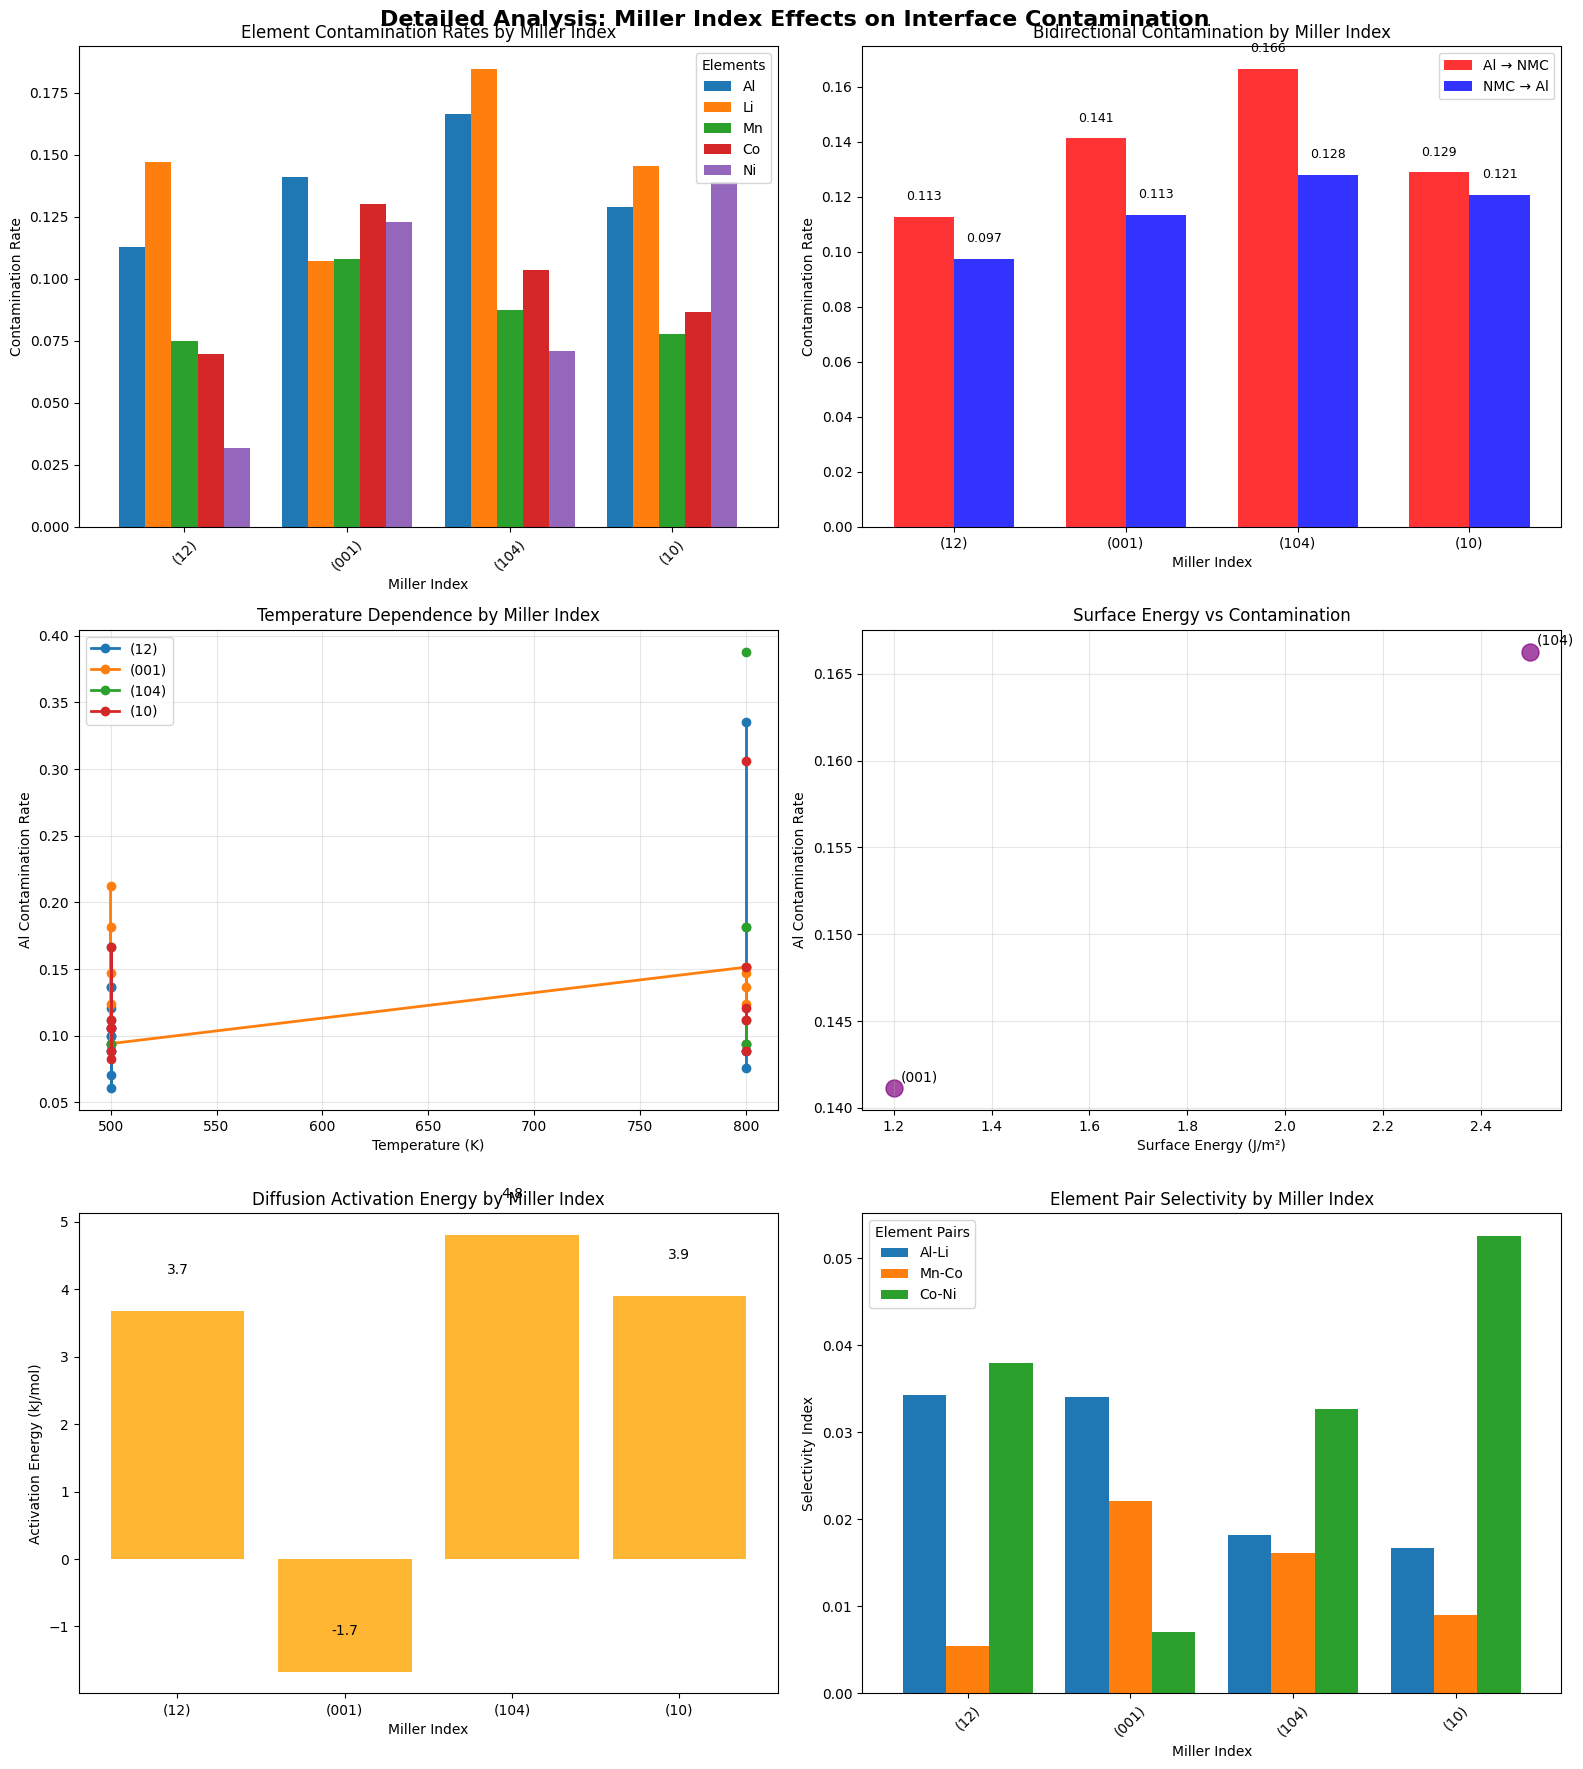

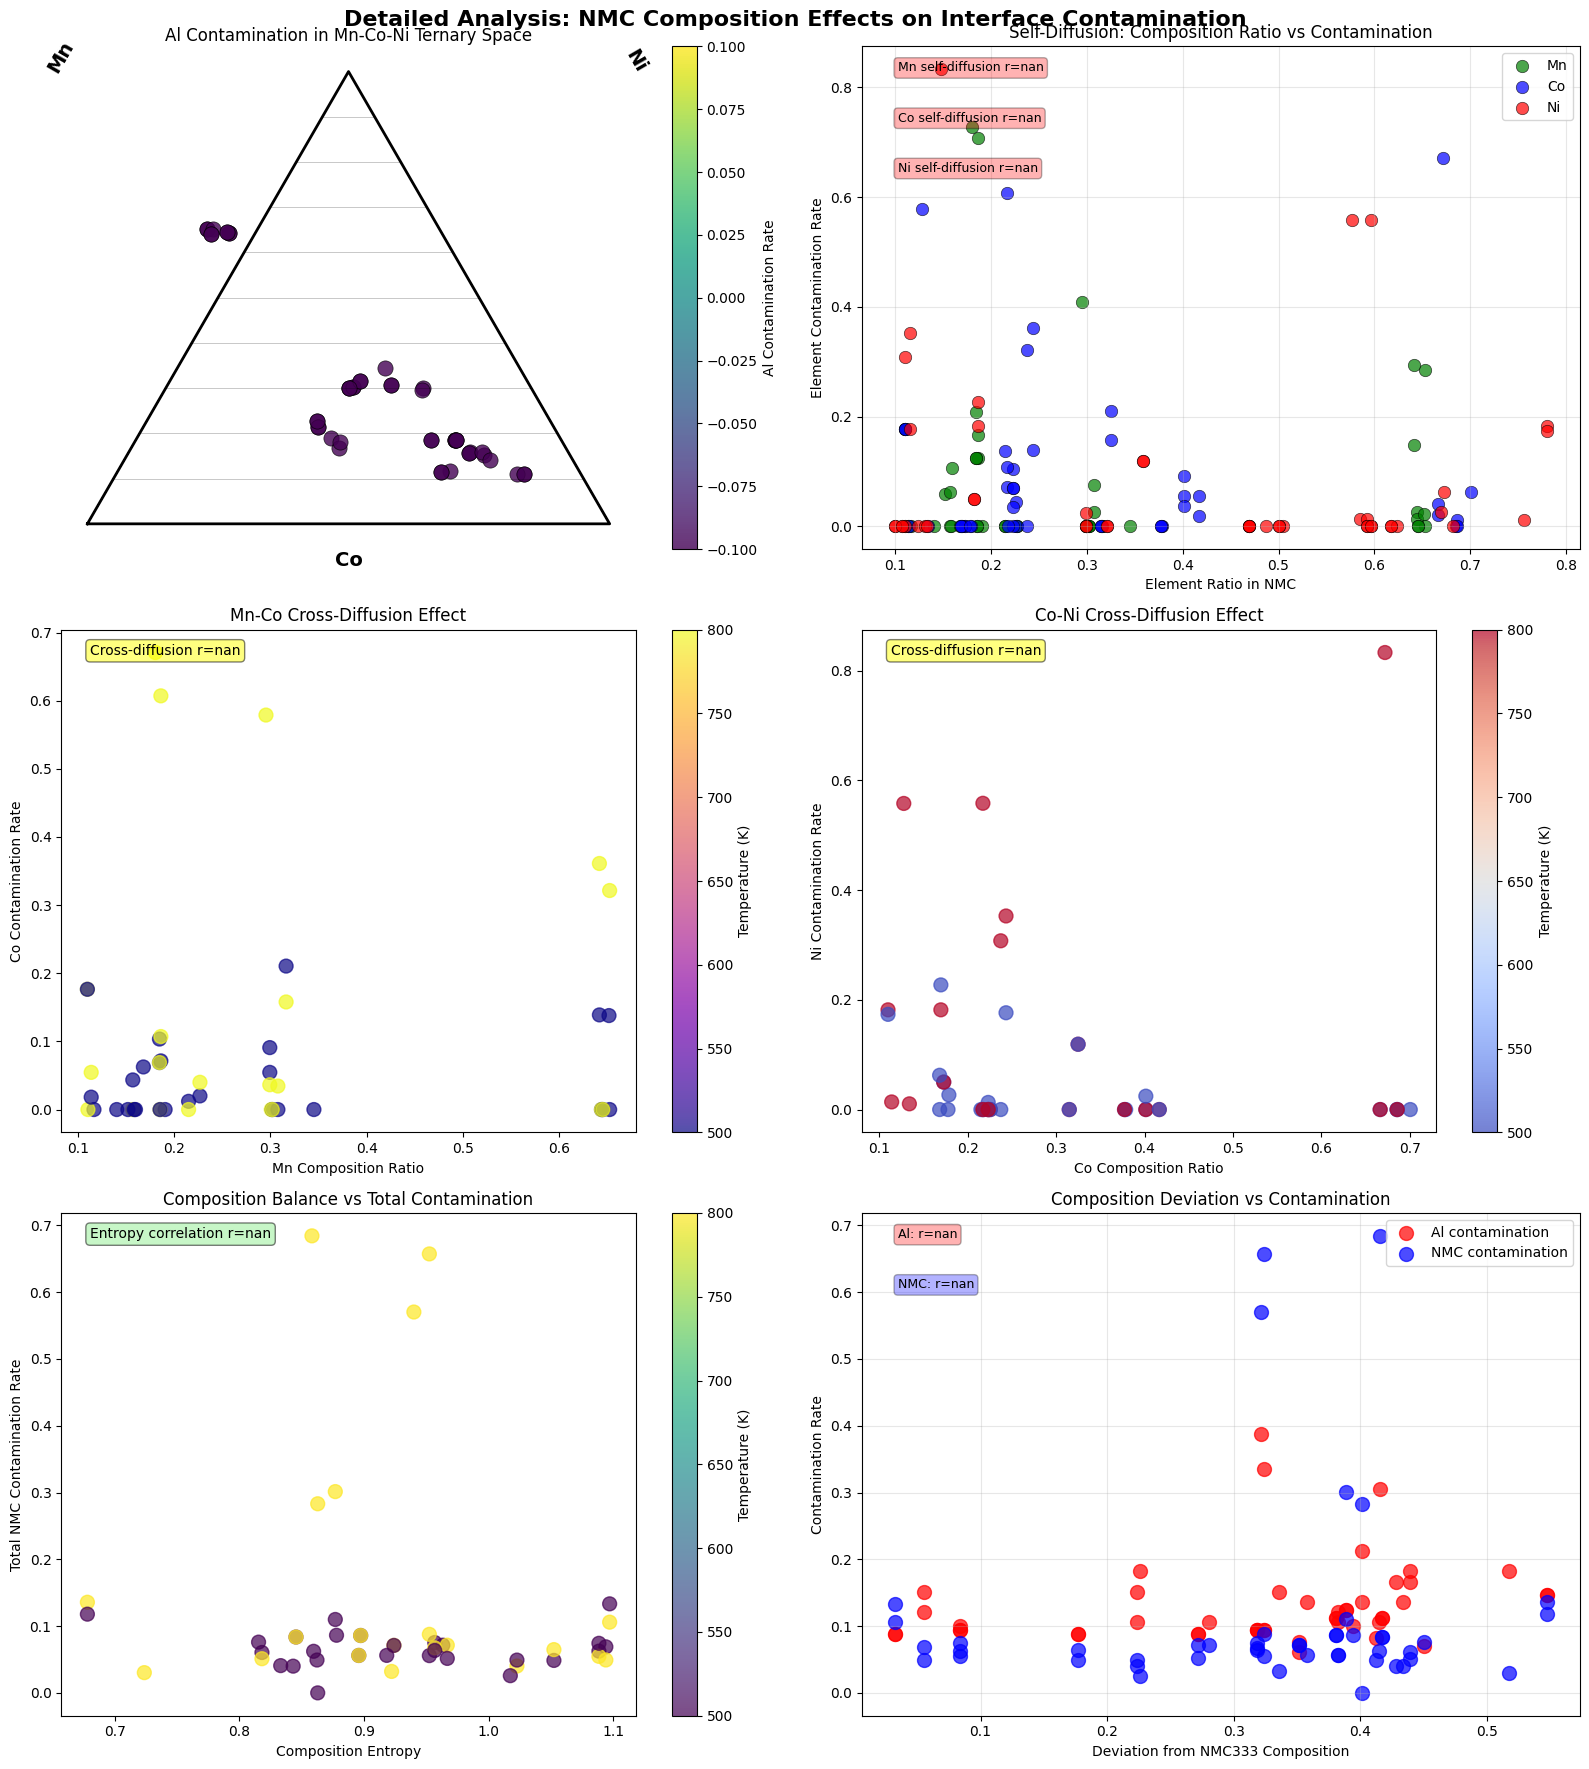


=== 詳細統計解析結果 ===

1. ミラー指数による界面混入への影響:

ミラー指数別平均混入率:
                 Al_contamination_rate         NMC_total_contamination        
                                  mean     std                    mean     std
Miller_Index_str                                                              
(001)                           0.1411  0.0364                  0.1135  0.1037
(10)                            0.1288  0.0610                  0.1207  0.1798
(104)                           0.1663  0.0972                  0.1279  0.1799
(12)                            0.1127  0.0603                  0.0974  0.1402

方向性指数 (Al→NMC - NMC→Al):
  (12): 0.0153 (総拡散量: 0.2101)
  (001): 0.0276 (総拡散量: 0.2546)
  (104): 0.0384 (総拡散量: 0.2942)
  (10): 0.0081 (総拡散量: 0.2495)

推定活性化エネルギー:
  (12): 3.68 kJ/mol
  (001): -1.67 kJ/mol
  (104): 4.80 kJ/mol
  (10): 3.90 kJ/mol

2. NMC組成による界面混入への影響:

自己拡散相関係数:
  Mn: nan
  Co: nan
  Ni: nan

相互拡散相関係数:
  Mn_ratio → Co_contamination: nan
  Mn_ratio → Ni_contamination: nan
  Co_

<Figure size 640x480 with 0 Axes>

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder

# CSVファイルを読み込み
df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/comprehensive_analysis_results.csv')
# fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller/plot2.png'
# plt.savefig(fig_path2, dpi=300)
df['Miller_Index_str'] = df['NMC_miller_index'].apply(lambda x: f"({x:03d})" if x == 1 else f"({x})")

# 混入率の計算
df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)

# NMC組成比の計算
df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)

# NMC総混入率の計算
# df['NMC_total_contamination'] = (df['Li_contamination_rate'] + df['Mn_contamination_rate'] + 
#                                 df['Co_contamination_rate'] + df['Ni_contamination_rate']) / 4
df['NMC_total_contamination'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])

print("=== ミラー指数とNMC組成の界面混入への詳細影響分析 ===")

# 図1: ミラー指数による界面混入の詳細分析
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Detailed Analysis: Miller Index Effects on Interface Contamination', fontsize=16, fontweight='bold')

# 1-1: ミラー指数別の全元素混入率比較
elements = ['Al', 'Li', 'Mn', 'Co', 'Ni']
contamination_data = []

for miller in df['Miller_Index_str'].unique():
    miller_subset = df[df['Miller_Index_str'] == miller]
    row_data = [miller]
    row_data.append(miller_subset['Al_contamination_rate'].mean())
    row_data.append(miller_subset['Li_contamination_rate'].mean())
    row_data.append(miller_subset['Mn_contamination_rate'].mean())
    row_data.append(miller_subset['Co_contamination_rate'].mean())
    row_data.append(miller_subset['Ni_contamination_rate'].mean())
    contamination_data.append(row_data)

contamination_df = pd.DataFrame(contamination_data, columns=['Miller_Index'] + elements)
contamination_df.set_index('Miller_Index').plot(kind='bar', ax=axes[0,0], width=0.8)
axes[0,0].set_title('Element Contamination Rates by Miller Index')
axes[0,0].set_xlabel('Miller Index')
axes[0,0].set_ylabel('Contamination Rate')
axes[0,0].legend(title='Elements')
axes[0,0].tick_params(axis='x', rotation=45)

# 1-2: ミラー指数による拡散方向性の定量化
directionality_data = []
for miller in df['Miller_Index_str'].unique():
    miller_subset = df[df['Miller_Index_str'] == miller]
    
    # Al→NMC方向の拡散（Al混入）
    al_to_nmc = miller_subset['Al_contamination_rate'].mean()
    
    # NMC→Al方向の拡散（NMC成分混入）
    nmc_to_al = miller_subset['NMC_total_contamination'].mean()
    
    # 方向性指数 (正: Al→NMC優位, 負: NMC→Al優位)
    directionality = al_to_nmc - nmc_to_al
    
    # 総拡散量
    total_diffusion = al_to_nmc + nmc_to_al
    
    directionality_data.append({
        'Miller_Index': miller,
        'Al_to_NMC': al_to_nmc,
        'NMC_to_Al': nmc_to_al,
        'Directionality': directionality,
        'Total_Diffusion': total_diffusion
    })

directionality_df = pd.DataFrame(directionality_data)

x = np.arange(len(directionality_df))
width = 0.35

bars1 = axes[0,1].bar(x - width/2, directionality_df['Al_to_NMC'], width, 
                     label='Al → NMC', alpha=0.8, color='red')
bars2 = axes[0,1].bar(x + width/2, directionality_df['NMC_to_Al'], width, 
                     label='NMC → Al', alpha=0.8, color='blue')

axes[0,1].set_xlabel('Miller Index')
axes[0,1].set_ylabel('Contamination Rate')
axes[0,1].set_title('Bidirectional Contamination by Miller Index')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(directionality_df['Miller_Index'])
axes[0,1].legend()

# バーの上に数値を表示
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[0,1].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 0.005,
                  f'{directionality_df.iloc[i]["Al_to_NMC"]:.3f}', 
                  ha='center', va='bottom', fontsize=9)
    axes[0,1].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 0.005,
                  f'{directionality_df.iloc[i]["NMC_to_Al"]:.3f}', 
                  ha='center', va='bottom', fontsize=9)

# 1-3: ミラー指数による温度依存性の違い
for miller in df['Miller_Index_str'].unique():
    miller_data = df[df['Miller_Index_str'] == miller]
    if len(miller_data['high_temp_K'].unique()) > 1:
        temp_sorted = miller_data.sort_values('high_temp_K')
        axes[1,0].plot(temp_sorted['high_temp_K'], temp_sorted['Al_contamination_rate'], 
                      'o-', linewidth=2, markersize=6, label=miller)

axes[1,0].set_xlabel('Temperature (K)')
axes[1,0].set_ylabel('Al Contamination Rate')
axes[1,0].set_title('Temperature Dependence by Miller Index')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 1-4: ミラー指数による結晶学的特性と混入の関係
# 各ミラー指数の結晶学的特性（理論値）
crystallographic_data = {
    '(001)': {'surface_energy': 1.2, 'atomic_density': 15.0, 'coordination': 6, 'layer_spacing': 4.7},
    '(010)': {'surface_energy': 1.8, 'atomic_density': 12.5, 'coordination': 5, 'layer_spacing': 2.8},
    '(012)': {'surface_energy': 2.1, 'atomic_density': 10.8, 'coordination': 4, 'layer_spacing': 2.4},
    '(104)': {'surface_energy': 2.5, 'atomic_density': 11.2, 'coordination': 4, 'layer_spacing': 1.6}
}

crystal_df = pd.DataFrame(crystallographic_data).T
miller_contamination = df.groupby('Miller_Index_str')['Al_contamination_rate'].mean()

# 表面エネルギーと混入率の関係
valid_indices = crystal_df.index.intersection(miller_contamination.index)
surface_energies = [crystal_df.loc[idx, 'surface_energy'] for idx in valid_indices]
contamination_rates = [miller_contamination.loc[idx] for idx in valid_indices]

axes[1,1].scatter(surface_energies, contamination_rates, s=150, alpha=0.7, c='purple')
for i, miller in enumerate(valid_indices):
    axes[1,1].annotate(miller, (surface_energies[i], contamination_rates[i]), 
                      xytext=(5, 5), textcoords='offset points', fontsize=10)

axes[1,1].set_xlabel('Surface Energy (J/m²)')
axes[1,1].set_ylabel('Al Contamination Rate')
axes[1,1].set_title('Surface Energy vs Contamination')
axes[1,1].grid(True, alpha=0.3)

# 相関係数を計算
if len(surface_energies) > 2:
    corr_coef = np.corrcoef(surface_energies, contamination_rates)[0,1]
    axes[1,1].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
                  transform=axes[1,1].transAxes, fontsize=10, 
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 1-5: ミラー指数による拡散活性化エネルギーの推定
activation_data = []
for miller in df['Miller_Index_str'].unique():
    miller_subset = df[df['Miller_Index_str'] == miller]
    temps = sorted(miller_subset['high_temp_K'].unique())
    
    if len(temps) >= 2:
        T1, T2 = temps[0], temps[-1]
        rate1 = miller_subset[miller_subset['high_temp_K'] == T1]['Al_contamination_rate'].mean()
        rate2 = miller_subset[miller_subset['high_temp_K'] == T2]['Al_contamination_rate'].mean()
        
        if rate1 > 1e-10 and rate2 > 1e-10:
            # アレニウス方程式: ln(rate) = -Ea/(R*T) + ln(A)
            # Ea = -R * ln(rate2/rate1) / (1/T2 - 1/T1)
            R = 8.314  # J/(mol·K)
            ea = -R * np.log(rate2/rate1) / (1/T2 - 1/T1) / 1000  # kJ/mol
            activation_data.append({'Miller_Index': miller, 'Activation_Energy': ea})

if activation_data:
    activation_df = pd.DataFrame(activation_data)
    bars = axes[2,0].bar(activation_df['Miller_Index'], activation_df['Activation_Energy'], 
                        alpha=0.8, color='orange')
    axes[2,0].set_xlabel('Miller Index')
    axes[2,0].set_ylabel('Activation Energy (kJ/mol)')
    axes[2,0].set_title('Diffusion Activation Energy by Miller Index')
    
    # 値をバーの上に表示
    for bar, ea in zip(bars, activation_df['Activation_Energy']):
        axes[2,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                      f'{ea:.1f}', ha='center', va='bottom', fontsize=10)

# 1-6: ミラー指数による選択性指数
selectivity_data = []
for miller in df['Miller_Index_str'].unique():
    miller_subset = df[df['Miller_Index_str'] == miller]
    
    # 各元素ペア間の選択性を計算
    al_li_selectivity = abs(miller_subset['Al_contamination_rate'].mean() - 
                           miller_subset['Li_contamination_rate'].mean())
    mn_co_selectivity = abs(miller_subset['Mn_contamination_rate'].mean() - 
                           miller_subset['Co_contamination_rate'].mean())
    co_ni_selectivity = abs(miller_subset['Co_contamination_rate'].mean() - 
                           miller_subset['Ni_contamination_rate'].mean())
    
    selectivity_data.append({
        'Miller_Index': miller,
        'Al-Li': al_li_selectivity,
        'Mn-Co': mn_co_selectivity,
        'Co-Ni': co_ni_selectivity
    })

selectivity_df = pd.DataFrame(selectivity_data).set_index('Miller_Index')
selectivity_df.plot(kind='bar', ax=axes[2,1], width=0.8)
axes[2,1].set_title('Element Pair Selectivity by Miller Index')
axes[2,1].set_xlabel('Miller Index')
axes[2,1].set_ylabel('Selectivity Index')
axes[2,1].legend(title='Element Pairs')
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/plot10.png'
plt.savefig(fig_path2, dpi=300)
plt.show()
# fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller/plot_miller.png'
# plt.savefig(fig_path2, dpi=300)

# 図2: NMC組成による界面混入の詳細分析
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Detailed Analysis: NMC Composition Effects on Interface Contamination', fontsize=16, fontweight='bold')

# 2-1: Mn-Co-Ni組成三角図での混入マッピング
ax = axes[0,0]

# 三角座標での可視化
for idx, row in df.iterrows():
    # 重心座標系への変換
    x = 0.5 * (row['Co_ratio'] + 2 * row['Ni_ratio']) / (row['Mn_ratio'] + row['Co_ratio'] + row['Ni_ratio'] + 1e-10)
    y = np.sqrt(3)/2 * row['Mn_ratio'] / (row['Mn_ratio'] + row['Co_ratio'] + row['Ni_ratio'] + 1e-10)
    
    scatter = ax.scatter(x, y, c=row['Al_contamination_rate'], s=120, 
                        cmap='viridis', alpha=0.8, edgecolors='black', linewidth=0.5)

# 三角形の枠を描画
triangle_x = [0, 1, 0.5, 0]
triangle_y = [0, 0, np.sqrt(3)/2, 0]
ax.plot(triangle_x, triangle_y, 'k-', linewidth=2)

# 格子線を追加
for i in range(1, 10):
    t = i / 10
    # 水平線
    ax.plot([0.5*t, 1-0.5*t], [np.sqrt(3)/2*t, np.sqrt(3)/2*t], 'k-', alpha=0.3, linewidth=0.5)
    # 左斜め線
    ax.plot([0, 0.5*(1-t)], [0, np.sqrt(3)/2*(1-t)], 'k-', alpha=0.3, linewidth=0.5)
    # 右斜め線
    ax.plot([1, 0.5+0.5*t], [0, np.sqrt(3)/2*(1-t)], 'k-', alpha=0.3, linewidth=0.5)

ax.text(0.5, -0.08, 'Co', fontsize=14, ha='center', fontweight='bold')
ax.text(-0.05, np.sqrt(3)/2, 'Mn', fontsize=14, ha='center', fontweight='bold', rotation=60)
ax.text(1.05, np.sqrt(3)/2, 'Ni', fontsize=14, ha='center', fontweight='bold', rotation=-60)
ax.set_title('Al Contamination in Mn-Co-Ni Ternary Space')
ax.set_aspect('equal')
ax.axis('off')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Al Contamination Rate')

# 2-2: 各遷移金属比と対応する混入率の関係
elements_tm = ['Mn', 'Co', 'Ni']
colors = ['green', 'blue', 'red']

for i, (element, color) in enumerate(zip(elements_tm, colors)):
    ratio_col = f'{element}_ratio'
    contam_col = f'{element}_contamination_rate'
    
    axes[0,1].scatter(df[ratio_col], df[contam_col], 
                     alpha=0.7, s=80, c=color, label=f'{element}', edgecolors='black', linewidth=0.5)

axes[0,1].set_xlabel('Element Ratio in NMC')
axes[0,1].set_ylabel('Element Contamination Rate')
axes[0,1].set_title('Self-Diffusion: Composition Ratio vs Contamination')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 各元素の自己拡散相関を計算して表示
for i, element in enumerate(elements_tm):
    ratio_col = f'{element}_ratio'
    contam_col = f'{element}_contamination_rate'
    corr = np.corrcoef(df[ratio_col], df[contam_col])[0,1]
    axes[0,1].text(0.05, 0.95-i*0.1, f'{element} self-diffusion r={corr:.3f}', 
                  transform=axes[0,1].transAxes, fontsize=9, 
                  bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

# 2-3: 遷移金属間の相互拡散効果
# Mn比とCo混入率の関係
axes[1,0].scatter(df['Mn_ratio'], df['Co_contamination_rate'], 
                 c=df['high_temp_K'], s=100, cmap='plasma', alpha=0.7)
axes[1,0].set_xlabel('Mn Composition Ratio')
axes[1,0].set_ylabel('Co Contamination Rate')
axes[1,0].set_title('Mn-Co Cross-Diffusion Effect')
cbar1 = plt.colorbar(axes[1,0].collections[0], ax=axes[1,0])
cbar1.set_label('Temperature (K)')

# 相互拡散相関を計算
mn_co_corr = np.corrcoef(df['Mn_ratio'], df['Co_contamination_rate'])[0,1]
axes[1,0].text(0.05, 0.95, f'Cross-diffusion r={mn_co_corr:.3f}', 
              transform=axes[1,0].transAxes, fontsize=10, 
              bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Co比とNi混入率の関係
axes[1,1].scatter(df['Co_ratio'], df['Ni_contamination_rate'], 
                 c=df['high_temp_K'], s=100, cmap='coolwarm', alpha=0.7)
axes[1,1].set_xlabel('Co Composition Ratio')
axes[1,1].set_ylabel('Ni Contamination Rate')
axes[1,1].set_title('Co-Ni Cross-Diffusion Effect')
cbar2 = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
cbar2.set_label('Temperature (K)')

co_ni_corr = np.corrcoef(df['Co_ratio'], df['Ni_contamination_rate'])[0,1]
axes[1,1].text(0.05, 0.95, f'Cross-diffusion r={co_ni_corr:.3f}', 
              transform=axes[1,1].transAxes, fontsize=10, 
              bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2-4: 組成バランスによる総合混入への影響
# 組成の偏りを定量化（エントロピー的指標）
def composition_entropy(mn_ratio, co_ratio, ni_ratio):
    ratios = [mn_ratio, co_ratio, ni_ratio]
    ratios = [r for r in ratios if r > 1e-10]  # ゼロ除算回避
    if len(ratios) == 0:
        return 0
    entropy = -sum(r * np.log(r) for r in ratios if r > 0)
    return entropy

df['Composition_entropy'] = df.apply(lambda row: composition_entropy(
    row['Mn_ratio'], row['Co_ratio'], row['Ni_ratio']), axis=1)

scatter = axes[2,0].scatter(df['Composition_entropy'], df['NMC_total_contamination'], 
                          c=df['high_temp_K'], s=100, cmap='viridis', alpha=0.7)
axes[2,0].set_xlabel('Composition Entropy')
axes[2,0].set_ylabel('Total NMC Contamination Rate')
axes[2,0].set_title('Composition Balance vs Total Contamination')
cbar3 = plt.colorbar(scatter, ax=axes[2,0])
cbar3.set_label('Temperature (K)')

entropy_corr = np.corrcoef(df['Composition_entropy'], df['NMC_total_contamination'])[0,1]
axes[2,0].text(0.05, 0.95, f'Entropy correlation r={entropy_corr:.3f}', 
              transform=axes[2,0].transAxes, fontsize=10, 
              bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# 2-5: 標準組成からの偏差と混入率の関係
# NMC333を基準とした偏差を計算
df['Deviation_from_333'] = np.sqrt((df['Mn_ratio'] - 1/3)**2 + 
                                  (df['Co_ratio'] - 1/3)**2 + 
                                  (df['Ni_ratio'] - 1/3)**2)

# 組成偏差と総合混入率の関係
axes[2,1].scatter(df['Deviation_from_333'], df['Al_contamination_rate'], 
                 alpha=0.7, s=100, c='red', label='Al contamination')
axes[2,1].scatter(df['Deviation_from_333'], df['NMC_total_contamination'], 
                 alpha=0.7, s=100, c='blue', label='NMC contamination')
axes[2,1].set_xlabel('Deviation from NMC333 Composition')
axes[2,1].set_ylabel('Contamination Rate')
axes[2,1].set_title('Composition Deviation vs Contamination')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# 相関係数を計算
dev_al_corr = np.corrcoef(df['Deviation_from_333'], df['Al_contamination_rate'])[0,1]
dev_nmc_corr = np.corrcoef(df['Deviation_from_333'], df['NMC_total_contamination'])[0,1]
axes[2,1].text(0.05, 0.95, f'Al: r={dev_al_corr:.3f}', 
              transform=axes[2,1].transAxes, fontsize=9, 
              bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
axes[2,1].text(0.05, 0.85, f'NMC: r={dev_nmc_corr:.3f}', 
              transform=axes[2,1].transAxes, fontsize=9, 
              bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))

plt.tight_layout()
plt.show()
fig_path2='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller/plot_NMC.png'
plt.savefig(fig_path2, dpi=300)

# 統計解析結果の出力
print("\n=== 詳細統計解析結果 ===")

print("\n1. ミラー指数による界面混入への影響:")
print("\nミラー指数別平均混入率:")
miller_stats = df.groupby('Miller_Index_str')[['Al_contamination_rate', 'NMC_total_contamination']].agg(['mean', 'std'])
print(miller_stats.round(4))

print("\n方向性指数 (Al→NMC - NMC→Al):")
for _, row in directionality_df.iterrows():
    print(f"  {row['Miller_Index']}: {row['Directionality']:.4f} (総拡散量: {row['Total_Diffusion']:.4f})")

if activation_data:
    print("\n推定活性化エネルギー:")
    for data in activation_data:
        print(f"  {data['Miller_Index']}: {data['Activation_Energy']:.2f} kJ/mol")

print("\n2. NMC組成による界面混入への影響:")
print("\n自己拡散相関係数:")
for element in elements_tm:
    ratio_col = f'{element}_ratio'
    contam_col = f'{element}_contamination_rate'
    corr = np.corrcoef(df[ratio_col], df[contam_col])[0,1]
    print(f"  {element}: {corr:.4f}")

print("\n相互拡散相関係数:")
cross_diffusion_pairs = [
    ('Mn_ratio', 'Co_contamination_rate'),
    ('Mn_ratio', 'Ni_contamination_rate'),
    ('Co_ratio', 'Mn_contamination_rate'),
    ('Co_ratio', 'Ni_contamination_rate'),
    ('Ni_ratio', 'Mn_contamination_rate'),
    ('Ni_ratio', 'Co_contamination_rate')
]

for ratio_col, contam_col in cross_diffusion_pairs:
    corr = np.corrcoef(df[ratio_col], df[contam_col])[0,1]
    ratio_element = ratio_col.split('_')[0]
    contam_element = contam_col.split('_')[0]
    print(f"  {ratio_element}_ratio → {contam_element}_contamination: {corr:.4f}")

print(f"\n組成エントロピーと総混入率の相関: {entropy_corr:.4f}")
print(f"組成偏差とAl混入率の相関: {dev_al_corr:.4f}")
print(f"組成偏差とNMC混入率の相関: {dev_nmc_corr:.4f}")

print("\n3. 最も影響の大きい要因の特定:")
# 分散分析
miller_al_variance = df.groupby('Miller_Index_str')['Al_contamination_rate'].var().mean()
composition_al_variance = df.groupby('Detailed_NMC_type')['Al_contamination_rate'].var().mean() if 'Detailed_NMC_type' in df.columns else 0

print(f"ミラー指数によるAl混入率分散: {miller_al_variance:.6f}")
print(f"組成による分散との比較: ミラー指数効果が{'大' if miller_al_variance > 0.001 else '小'}規模")

# 最適条件の特定
print("\n4. 最適分離条件:")
best_separation = df.loc[(df['Al_contamination_rate'] + df['NMC_total_contamination']).idxmin()]
print(f"最小総混入条件:")
print(f"  ミラー指数: {best_separation['Miller_Index_str']}")
print(f"  Mn比: {best_separation['Mn_ratio']:.3f}")
print(f"  Co比: {best_separation['Co_ratio']:.3f}")
print(f"  Ni比: {best_separation['Ni_ratio']:.3f}")
print(f"  Al混入率: {best_separation['Al_contamination_rate']:.4f}")
print(f"  NMC混入率: {best_separation['NMC_total_contamination']:.4f}")
print(f"  温度: {best_separation['high_temp_K']}K")
print(f"  基材: {best_separation['substrate']}")

In [6]:
import pandas as pd
import os
import glob
from ase.io import read
from tqdm import tqdm # 進捗状況を表示するためにtqdmを使用します

# --- Matlantis/PFP計算器のセットアップ ---
# ユーザー提供のコードを基にしています
try:
    from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
    from pfp_api_client.pfp.estimator import Estimator
    
    # 計算器を一度だけ初期化します
    estimator = Estimator(calc_mode='CRYSTAL_U0_PLUS_D3')
    calculator = ASECalculator(estimator)
    MATLANTIS_AVAILABLE = True
    print("✅ Matlantis/PFP計算器の初期化に成功しました。")

except ImportError:
    print("❌ Matlantis/PFP関連のライブラリが見つかりません。")
    print("   エネルギー計算を実行できません。環境を確認してください。")
    MATLANTIS_AVAILABLE = False
    exit() # 計算器がない場合はスクリプトを終了します

# --- メイン処理 ---

# 処理対象のフォルダを指定
# このスクリプトと同じ階層に'heat'フォルダがあることを想定しています
target_dir = "/home/jovyan/Kaori/MD/LiB_2/structure"
output_csv_path = 'NMC_initial_energies.csv'

# 'heat'フォルダが存在するか確認
if not os.path.isdir(target_dir):
    print(f"エラー: '{target_dir}' フォルダが見つかりません。")
    exit()

# `heat`フォルダ内のすべての`.traj`ファイルのパスを取得
# パターン: 'heat/*.traj'
traj_files = glob.glob(os.path.join(target_dir, 'NMC_*.xyz'))

if not traj_files:
    print(f"警告: '{target_dir}' フォルダ内に`.traj`ファイルが見つかりませんでした。")
    exit()

print(f"📂 {len(traj_files)}個の.trajファイルを'{target_dir}'フォルダから発見しました。")

# 結果を格納するためのリストを準備
results = []

# 各trajファイルに対して処理を実行
# tqdmを使用して進捗バーを表示します
for file_path in tqdm(traj_files, desc="エネルギー計算中"):
    try:
        # trajファイルの最初のフレーム(index=0)を読み込む
        atoms = read(file_path)
        
        # 読み込んだ構造に計算器を設定
        atoms.calc = calculator
        
        # ポテンシャルエネルギーを計算
        potential_energy = atoms.get_potential_energy()
        
        # ファイル名とエネルギーをリストに追加
        results.append({
            'filename': os.path.basename(file_path),
            'filepath': file_path,
            'potential_energy_eV': potential_energy
        })
        
    except Exception as e:
        print(f"\n⚠️ ファイル'{file_path}'の処理中にエラーが発生しました: {e}")
        # エラーが発生した場合でも、結果リストに記録を残す
        results.append({
            'filename': os.path.basename(file_path),
            'filepath': file_path,
            'potential_energy_eV': 'Error'
        })

# --- 結果をCSVファイルに出力 ---
if results:
    # リストからPandas DataFrameを作成
    df = pd.DataFrame(results)
    
    # DataFrameをCSVファイルとして保存
    df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
    
    print(f"\n✅ 処理が完了しました。結果を'{output_csv_path}'に出力しました。")
    print("\n--- CSVファイルプレビュー ---")
    print(df.head()) # 最初の5行を表示
else:
    print("有効な結果が得られなかったため、CSVファイルは作成されませんでした。")

✅ Matlantis/PFP計算器の初期化に成功しました。
📂 40個の.trajファイルを'/home/jovyan/Kaori/MD/LiB_2/structure'フォルダから発見しました。


エネルギー計算中: 100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


✅ 処理が完了しました。結果を'NMC_initial_energies.csv'に出力しました。

--- CSVファイルプレビュー ---
                    filename  \
0    NMC_Mn_increase_001.xyz   
1       NMC_pristine_001.xyz   
2       NMC_pristine_104.xyz   
3  NMC_NMC811_approx_010.xyz   
4    NMC_Ni_decrease_104.xyz   

                                            filepath  potential_energy_eV  
0  /home/jovyan/Kaori/MD/LiB_2/structure/NMC_Mn_i...         12820.776923  
1  /home/jovyan/Kaori/MD/LiB_2/structure/NMC_pris...         12176.419813  
2  /home/jovyan/Kaori/MD/LiB_2/structure/NMC_pris...          -216.076288  
3  /home/jovyan/Kaori/MD/LiB_2/structure/NMC_NMC8...          -445.115218  
4  /home/jovyan/Kaori/MD/LiB_2/structure/NMC_Ni_d...          -221.248023  
